# Analysis of human RAS saturation mutagenesis data

In this tutorial, we compare computational predictions from Rhapsody, PolyPhen-2 and EVmutation against experimental functional assessments of human RAS mutants presented in:
[Bandaru P et al, *Deconstruction of the Ras switching cycle through saturation mutagenesis*, Elife (2017)](https://elifesciences.org/articles/27810)

All results and figures presented here are described and interpreted in the Rhapsody paper and all data needed to fully reproduce them are provided.

In [1]:
import sys, os, pickle, csv, glob
import numpy as np
import prody as pd

In [2]:
# If needed, insert here local path to Rhapsody folder with the command:
# sys.path.insert(0, '/LOCAL_PATH/rhapsody/')
import rhapsody as rd

## Re-training of unbiased classifier

A few RAS mutations are found in the Integrated Dataset used for training. In order to get completely unbiased predictions, we will retrain a classifier by excluding those variants from the training dataset.

**NB:** The Uniprot name for gene HRAS is `P01112`.

In [3]:
# import the numpy structured array containing precomputed features 
# for the optimized training dataset
ID = np.load('../00-Training_Dataset/local/data/precomputed_features-ID_opt.npy')

ID_del = ID[ID['true_label'] == 1]  # deleterious SAVs
ID_neu = ID[ID['true_label'] == 0]  # neutral SAVs

known_del_SAVs = [SAV['SAV_coords'] for SAV in ID_del 
                  if SAV['SAV_coords'].startswith('P01112')]
known_neu_SAVs = [SAV['SAV_coords'] for SAV in ID_neu 
                  if SAV['SAV_coords'].startswith('P01112')]

print(f'{len(known_del_SAVs)} known deleterious RAS SAVs:')
print(known_del_SAVs)
print(f'\n{len(known_neu_SAVs)} known neutral RAS SAVs:')
print(known_neu_SAVs)

15 known deleterious RAS SAVs:
['P01112 117 K R', 'P01112 12 G A', 'P01112 12 G C', 'P01112 12 G D', 'P01112 12 G E', 'P01112 12 G S', 'P01112 12 G V', 'P01112 13 G C', 'P01112 13 G D', 'P01112 146 A V', 'P01112 22 Q K', 'P01112 58 T I', 'P01112 61 Q K', 'P01112 61 Q L', 'P01112 63 E K']

0 known neutral RAS SAVs:
[]


Let's exclude these variants from the dataset. 

In [4]:
ID_subset = ID[ [not SAV.startswith('P01112') for SAV in ID['SAV_coords']] ]
len(ID_subset)

20346

We use this subset of the Integrated Dataset to train unbiased versions of the Rhapsody classifiers:

In [5]:
if not os.path.isdir('local'):
    os.mkdir('local')

In [6]:
folder = 'local/results/'

if not os.path.isdir(folder):
    os.mkdir(folder)
    
    logfile = os.path.join(folder, 'RF_training.log')
    pd.LOGGER.start(logfile)
    
    for clsf_version in ['full', 'reduced']:
        # training of the Random Forest classifier on the given set of features
        featset = rd.DEFAULT_FEATSETS[clsf_version]
        sel = ['SAV_coords', 'true_label'] + featset
        rd.trainRFclassifier(ID_subset[sel])
        
        # store output files
        _folder = os.path.join(folder, clsf_version)
        os.mkdir(_folder)
        for file in glob.glob('*png') + ['trained_classifier.pkl',]:
            os.rename(file, os.path.join(_folder, file))
            
        pd.LOGGER.info('')

    pd.LOGGER.close(logfile)
else:
    print('Precomputed classifiers found.')

@> Logging into file: local/results/RF_training.log
@> Logging started at 2019-07-03 14:07:05.794179
@> 3918 out of 20346 cases ignored with missing features.
@> CV iteration # 1:   AUROC = 0.859   AUPRC = 0.922   OOB score = 0.808
@> CV iteration # 2:   AUROC = 0.864   AUPRC = 0.925   OOB score = 0.810
@> CV iteration # 3:   AUROC = 0.848   AUPRC = 0.914   OOB score = 0.812
@> CV iteration # 4:   AUROC = 0.872   AUPRC = 0.930   OOB score = 0.808
@> CV iteration # 5:   AUROC = 0.854   AUPRC = 0.922   OOB score = 0.812
@> CV iteration # 6:   AUROC = 0.857   AUPRC = 0.923   OOB score = 0.811
@> CV iteration # 7:   AUROC = 0.849   AUPRC = 0.919   OOB score = 0.811
@> CV iteration # 8:   AUROC = 0.866   AUPRC = 0.929   OOB score = 0.812
@> CV iteration # 9:   AUROC = 0.845   AUPRC = 0.911   OOB score = 0.811
@> CV iteration #10:   AUROC = 0.849   AUPRC = 0.915   OOB score = 0.812
@> ------------------------------------------------------------
@> Cross-validation summary:
@> training datase

In [7]:
full_clsf = 'local/results/full/trained_classifier.pkl'
reduced_clsf = 'local/results/reduced/trained_classifier.pkl'

## Rhapsody predictions
We perform a complete scanning of all amino acid variants (*in silico* saturation mutagenesis) using the custom classifiers we just trained.

**NB:** PolyPhen-2 predictions are precomputed and saved in `data/pph2`

In [8]:
folder = 'local/results/predictions/'

if not os.path.isdir(folder):
    # run rhapsody
    rh = rd.rhapsody('data/pph2/pph2-full.txt', query_type='PolyPhen2',
                     main_classifier=full_clsf, aux_classifier=reduced_clsf)
    # store output files
    os.mkdir(folder)
    for f in glob.glob('rhapsody-*.*'):
        os.rename(f, os.path.join(folder, f))
else:
    with open(os.path.join(folder, 'rhapsody-pickle.pkl'), 'rb') as f:
        rh = pickle.load(f)
    print('Precomputed predictions imported.')

@> Logging into file: rhapsody-log.txt
@> Logging started at 2019-07-03 14:13:01.842065
@> Imported feature set:
@>    'wt_PSIC'* 
@>    'Delta_PSIC'* 
@>    'SASA'* 
@>    'ANM_MSF-chain'* 
@>    'ANM_effectiveness-chain'* 
@>    'ANM_sensitivity-chain'* 
@>    'stiffness-chain'* 
@>    'entropy' 
@>    'ranked_MI' 
@>    'BLOSUM'* 
@>    (* auxiliary feature set)
@> PolyPhen-2's output parsed.
@> Sequence-conservation features have been retrieved from PolyPhen-2's output.
@> Mapping SAVs to PDB structures...
@> [1/3591] Mapping SAV 'P01112 1 M A' to PDB...
@> WARNING Unable to recover pickle: File 'UniprotMap-P01112.pkl' not found
@> PDB file is found in the local folder (/home/lponzoni/.../121p.pdb.gz).
@> 166 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> PDB file is found in the local folder (/home/lponzoni/.../1aa9.pdb.gz).
@> 171 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> PDB file is found in the local folder (/home/lponzoni/.../1agp.pdb.gz).
@> 166 atoms and

@> 166 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> PDB file is found in the local folder (/home/lponzoni/.../2rga.pdb.gz).
@> 166 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> PDB file is found in the local folder (/home/lponzoni/.../2rgb.pdb.gz).
@> 166 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> PDB file is found in the local folder (/home/lponzoni/.../2rgc.pdb.gz).
@> 166 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> PDB file is found in the local folder (/home/lponzoni/.../2rgd.pdb.gz).
@> 166 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> PDB file is found in the local folder (/home/lponzoni/.../2rge.pdb.gz).
@> 158 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> PDB file is found in the local folder (/home/lponzoni/.../2rgg.pdb.gz).
@> 159 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> PDB file is found in the local folder (/home/lponzoni/.../2uzi.pdb.gz).
@> 384 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> 

@> PDB file is found in the local folder (/home/lponzoni/.../4rsg.pdb.gz).
@> 162 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> PDB file is found in the local folder (/home/lponzoni/.../4uru.pdb.gz).
@> 619 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> PDB file is found in the local folder (/home/lponzoni/.../4urv.pdb.gz).
@> 617 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> PDB file is found in the local folder (/home/lponzoni/.../4urw.pdb.gz).
@> 620 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> PDB file is found in the local folder (/home/lponzoni/.../4urx.pdb.gz).
@> 619 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> PDB file is found in the local folder (/home/lponzoni/.../4ury.pdb.gz).
@> 616 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> PDB file is found in the local folder (/home/lponzoni/.../4urz.pdb.gz).
@> 621 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> PDB file is found in the local folder (/home/lponzoni/.../4

@> [20/3591] Mapping SAV 'P01112 127 S M' to PDB...
@> [21/3591] Mapping SAV 'P01112 127 S N' to PDB...
@> [22/3591] Mapping SAV 'P01112 127 S P' to PDB...
@> [23/3591] Mapping SAV 'P01112 127 S Q' to PDB...
@> [24/3591] Mapping SAV 'P01112 127 S R' to PDB...
@> [25/3591] Mapping SAV 'P01112 127 S T' to PDB...
@> [26/3591] Mapping SAV 'P01112 127 S F' to PDB...
@> [27/3591] Mapping SAV 'P01112 127 S V' to PDB...
@> [28/3591] Mapping SAV 'P01112 126 E M' to PDB...
@> [29/3591] Mapping SAV 'P01112 126 E K' to PDB...
@> [30/3591] Mapping SAV 'P01112 125 V D' to PDB...
@> [31/3591] Mapping SAV 'P01112 125 V E' to PDB...
@> [32/3591] Mapping SAV 'P01112 125 V F' to PDB...
@> [33/3591] Mapping SAV 'P01112 125 V G' to PDB...
@> [34/3591] Mapping SAV 'P01112 125 V H' to PDB...
@> [35/3591] Mapping SAV 'P01112 125 V I' to PDB...
@> [36/3591] Mapping SAV 'P01112 125 V K' to PDB...
@> [37/3591] Mapping SAV 'P01112 125 V L' to PDB...
@> [38/3591] Mapping SAV 'P01112 125 V M' to PDB...
@> [39/3591]

@> [177/3591] Mapping SAV 'P01112 124 T A' to PDB...
@> [178/3591] Mapping SAV 'P01112 124 T C' to PDB...
@> [179/3591] Mapping SAV 'P01112 124 T D' to PDB...
@> [180/3591] Mapping SAV 'P01112 124 T E' to PDB...
@> [181/3591] Mapping SAV 'P01112 123 R N' to PDB...
@> [182/3591] Mapping SAV 'P01112 124 T F' to PDB...
@> [183/3591] Mapping SAV 'P01112 124 T H' to PDB...
@> [184/3591] Mapping SAV 'P01112 124 T I' to PDB...
@> [185/3591] Mapping SAV 'P01112 124 T K' to PDB...
@> [186/3591] Mapping SAV 'P01112 124 T L' to PDB...
@> [187/3591] Mapping SAV 'P01112 124 T M' to PDB...
@> [188/3591] Mapping SAV 'P01112 124 T N' to PDB...
@> [189/3591] Mapping SAV 'P01112 124 T P' to PDB...
@> [190/3591] Mapping SAV 'P01112 124 T Q' to PDB...
@> [191/3591] Mapping SAV 'P01112 124 T R' to PDB...
@> [192/3591] Mapping SAV 'P01112 124 T S' to PDB...
@> [193/3591] Mapping SAV 'P01112 124 T V' to PDB...
@> [194/3591] Mapping SAV 'P01112 124 T G' to PDB...
@> [195/3591] Mapping SAV 'P01112 122 A D' to 

@> [332/3591] Mapping SAV 'P01112 141 Y C' to PDB...
@> [333/3591] Mapping SAV 'P01112 141 Y D' to PDB...
@> [334/3591] Mapping SAV 'P01112 140 P M' to PDB...
@> [335/3591] Mapping SAV 'P01112 136 S V' to PDB...
@> [336/3591] Mapping SAV 'P01112 136 S T' to PDB...
@> [337/3591] Mapping SAV 'P01112 136 S R' to PDB...
@> [338/3591] Mapping SAV 'P01112 132 D M' to PDB...
@> [339/3591] Mapping SAV 'P01112 132 D N' to PDB...
@> [340/3591] Mapping SAV 'P01112 132 D P' to PDB...
@> [341/3591] Mapping SAV 'P01112 132 D Q' to PDB...
@> [342/3591] Mapping SAV 'P01112 132 D R' to PDB...
@> [343/3591] Mapping SAV 'P01112 132 D S' to PDB...
@> [344/3591] Mapping SAV 'P01112 132 D T' to PDB...
@> [345/3591] Mapping SAV 'P01112 132 D V' to PDB...
@> [346/3591] Mapping SAV 'P01112 132 D W' to PDB...
@> [347/3591] Mapping SAV 'P01112 132 D Y' to PDB...
@> [348/3591] Mapping SAV 'P01112 133 L A' to PDB...
@> [349/3591] Mapping SAV 'P01112 132 D L' to PDB...
@> [350/3591] Mapping SAV 'P01112 133 L C' to 

@> [487/3591] Mapping SAV 'P01112 101 K W' to PDB...
@> [488/3591] Mapping SAV 'P01112 101 K Y' to PDB...
@> [489/3591] Mapping SAV 'P01112 102 R A' to PDB...
@> [490/3591] Mapping SAV 'P01112 102 R T' to PDB...
@> [491/3591] Mapping SAV 'P01112 102 R C' to PDB...
@> [492/3591] Mapping SAV 'P01112 102 R E' to PDB...
@> [493/3591] Mapping SAV 'P01112 102 R F' to PDB...
@> [494/3591] Mapping SAV 'P01112 102 R G' to PDB...
@> [495/3591] Mapping SAV 'P01112 102 R H' to PDB...
@> [496/3591] Mapping SAV 'P01112 102 R I' to PDB...
@> [497/3591] Mapping SAV 'P01112 102 R K' to PDB...
@> [498/3591] Mapping SAV 'P01112 102 R L' to PDB...
@> [499/3591] Mapping SAV 'P01112 102 R M' to PDB...
@> [500/3591] Mapping SAV 'P01112 102 R N' to PDB...
@> [501/3591] Mapping SAV 'P01112 102 R P' to PDB...
@> [502/3591] Mapping SAV 'P01112 102 R Q' to PDB...
@> [503/3591] Mapping SAV 'P01112 102 R D' to PDB...
@> [504/3591] Mapping SAV 'P01112 101 K L' to PDB...
@> [505/3591] Mapping SAV 'P01112 104 K G' to 

@> [643/3591] Mapping SAV 'P01112 100 I Q' to PDB...
@> [644/3591] Mapping SAV 'P01112 98 E L' to PDB...
@> [645/3591] Mapping SAV 'P01112 99 Q W' to PDB...
@> [646/3591] Mapping SAV 'P01112 99 Q T' to PDB...
@> [647/3591] Mapping SAV 'P01112 98 E N' to PDB...
@> [648/3591] Mapping SAV 'P01112 98 E P' to PDB...
@> [649/3591] Mapping SAV 'P01112 98 E Q' to PDB...
@> [650/3591] Mapping SAV 'P01112 98 E R' to PDB...
@> [651/3591] Mapping SAV 'P01112 98 E S' to PDB...
@> [652/3591] Mapping SAV 'P01112 98 E T' to PDB...
@> [653/3591] Mapping SAV 'P01112 98 E V' to PDB...
@> [654/3591] Mapping SAV 'P01112 98 E W' to PDB...
@> [655/3591] Mapping SAV 'P01112 98 E Y' to PDB...
@> [656/3591] Mapping SAV 'P01112 99 Q A' to PDB...
@> [657/3591] Mapping SAV 'P01112 99 Q C' to PDB...
@> [658/3591] Mapping SAV 'P01112 99 Q V' to PDB...
@> [659/3591] Mapping SAV 'P01112 99 Q D' to PDB...
@> [660/3591] Mapping SAV 'P01112 99 Q F' to PDB...
@> [661/3591] Mapping SAV 'P01112 99 Q G' to PDB...
@> [662/359

@> [799/3591] Mapping SAV 'P01112 109 V K' to PDB...
@> [800/3591] Mapping SAV 'P01112 109 V M' to PDB...
@> [801/3591] Mapping SAV 'P01112 109 V N' to PDB...
@> [802/3591] Mapping SAV 'P01112 109 V P' to PDB...
@> [803/3591] Mapping SAV 'P01112 109 V Q' to PDB...
@> [804/3591] Mapping SAV 'P01112 109 V R' to PDB...
@> [805/3591] Mapping SAV 'P01112 109 V S' to PDB...
@> [806/3591] Mapping SAV 'P01112 109 V T' to PDB...
@> [807/3591] Mapping SAV 'P01112 109 V W' to PDB...
@> [808/3591] Mapping SAV 'P01112 109 V Y' to PDB...
@> [809/3591] Mapping SAV 'P01112 110 P A' to PDB...
@> [810/3591] Mapping SAV 'P01112 110 P C' to PDB...
@> [811/3591] Mapping SAV 'P01112 109 V L' to PDB...
@> [812/3591] Mapping SAV 'P01112 110 P D' to PDB...
@> [813/3591] Mapping SAV 'P01112 108 D S' to PDB...
@> [814/3591] Mapping SAV 'P01112 108 D Q' to PDB...
@> [815/3591] Mapping SAV 'P01112 107 D K' to PDB...
@> [816/3591] Mapping SAV 'P01112 107 D L' to PDB...
@> [817/3591] Mapping SAV 'P01112 107 D M' to 

@> [954/3591] Mapping SAV 'P01112 175 D F' to PDB...
@> [955/3591] Mapping SAV 'P01112 175 D H' to PDB...
@> [956/3591] Mapping SAV 'P01112 176 E T' to PDB...
@> [957/3591] Mapping SAV 'P01112 176 E V' to PDB...
@> [958/3591] Mapping SAV 'P01112 176 E W' to PDB...
@> [959/3591] Mapping SAV 'P01112 176 E Y' to PDB...
@> [960/3591] Mapping SAV 'P01112 177 S A' to PDB...
@> [961/3591] Mapping SAV 'P01112 177 S C' to PDB...
@> [962/3591] Mapping SAV 'P01112 177 S D' to PDB...
@> [963/3591] Mapping SAV 'P01112 177 S E' to PDB...
@> [964/3591] Mapping SAV 'P01112 177 S F' to PDB...
@> [965/3591] Mapping SAV 'P01112 177 S G' to PDB...
@> [966/3591] Mapping SAV 'P01112 177 S H' to PDB...
@> [967/3591] Mapping SAV 'P01112 176 E S' to PDB...
@> [968/3591] Mapping SAV 'P01112 177 S I' to PDB...
@> [969/3591] Mapping SAV 'P01112 177 S L' to PDB...
@> [970/3591] Mapping SAV 'P01112 177 S M' to PDB...
@> [971/3591] Mapping SAV 'P01112 177 S N' to PDB...
@> [972/3591] Mapping SAV 'P01112 177 S P' to 

@> [1106/3591] Mapping SAV 'P01112 169 R Y' to PDB...
@> [1107/3591] Mapping SAV 'P01112 170 K S' to PDB...
@> [1108/3591] Mapping SAV 'P01112 170 K A' to PDB...
@> [1109/3591] Mapping SAV 'P01112 170 K D' to PDB...
@> [1110/3591] Mapping SAV 'P01112 170 K E' to PDB...
@> [1111/3591] Mapping SAV 'P01112 170 K F' to PDB...
@> [1112/3591] Mapping SAV 'P01112 170 K G' to PDB...
@> [1113/3591] Mapping SAV 'P01112 170 K H' to PDB...
@> [1114/3591] Mapping SAV 'P01112 170 K I' to PDB...
@> [1115/3591] Mapping SAV 'P01112 170 K L' to PDB...
@> [1116/3591] Mapping SAV 'P01112 170 K M' to PDB...
@> [1117/3591] Mapping SAV 'P01112 170 K N' to PDB...
@> [1118/3591] Mapping SAV 'P01112 170 K P' to PDB...
@> [1119/3591] Mapping SAV 'P01112 170 K Q' to PDB...
@> [1120/3591] Mapping SAV 'P01112 170 K C' to PDB...
@> [1121/3591] Mapping SAV 'P01112 178 G D' to PDB...
@> [1122/3591] Mapping SAV 'P01112 178 G E' to PDB...
@> [1123/3591] Mapping SAV 'P01112 178 G F' to PDB...
@> [1124/3591] Mapping SAV '

@> [1258/3591] Mapping SAV 'P01112 180 G W' to PDB...
@> [1259/3591] Mapping SAV 'P01112 180 G Y' to PDB...
@> [1260/3591] Mapping SAV 'P01112 180 G K' to PDB...
@> [1261/3591] Mapping SAV 'P01112 181 C A' to PDB...
@> [1262/3591] Mapping SAV 'P01112 179 P Q' to PDB...
@> [1263/3591] Mapping SAV 'P01112 179 P M' to PDB...
@> [1264/3591] Mapping SAV 'P01112 178 G H' to PDB...
@> [1265/3591] Mapping SAV 'P01112 178 G I' to PDB...
@> [1266/3591] Mapping SAV 'P01112 178 G K' to PDB...
@> [1267/3591] Mapping SAV 'P01112 178 G L' to PDB...
@> [1268/3591] Mapping SAV 'P01112 178 G M' to PDB...
@> [1269/3591] Mapping SAV 'P01112 178 G N' to PDB...
@> [1270/3591] Mapping SAV 'P01112 178 G P' to PDB...
@> [1271/3591] Mapping SAV 'P01112 178 G Q' to PDB...
@> [1272/3591] Mapping SAV 'P01112 178 G R' to PDB...
@> [1273/3591] Mapping SAV 'P01112 178 G S' to PDB...
@> [1274/3591] Mapping SAV 'P01112 178 G T' to PDB...
@> [1275/3591] Mapping SAV 'P01112 179 P N' to PDB...
@> [1276/3591] Mapping SAV '

@> [1410/3591] Mapping SAV 'P01112 153 E L' to PDB...
@> [1411/3591] Mapping SAV 'P01112 153 E M' to PDB...
@> [1412/3591] Mapping SAV 'P01112 153 E N' to PDB...
@> [1413/3591] Mapping SAV 'P01112 153 E P' to PDB...
@> [1414/3591] Mapping SAV 'P01112 153 E Q' to PDB...
@> [1415/3591] Mapping SAV 'P01112 153 E R' to PDB...
@> [1416/3591] Mapping SAV 'P01112 153 E D' to PDB...
@> [1417/3591] Mapping SAV 'P01112 153 E S' to PDB...
@> [1418/3591] Mapping SAV 'P01112 153 E V' to PDB...
@> [1419/3591] Mapping SAV 'P01112 153 E W' to PDB...
@> [1420/3591] Mapping SAV 'P01112 153 E Y' to PDB...
@> [1421/3591] Mapping SAV 'P01112 154 D A' to PDB...
@> [1422/3591] Mapping SAV 'P01112 154 D C' to PDB...
@> [1423/3591] Mapping SAV 'P01112 154 D E' to PDB...
@> [1424/3591] Mapping SAV 'P01112 154 D F' to PDB...
@> [1425/3591] Mapping SAV 'P01112 154 D G' to PDB...
@> [1426/3591] Mapping SAV 'P01112 154 D H' to PDB...
@> [1427/3591] Mapping SAV 'P01112 154 D I' to PDB...
@> [1428/3591] Mapping SAV '

@> [1562/3591] Mapping SAV 'P01112 146 A R' to PDB...
@> [1563/3591] Mapping SAV 'P01112 146 A S' to PDB...
@> [1564/3591] Mapping SAV 'P01112 146 A T' to PDB...
@> [1565/3591] Mapping SAV 'P01112 146 A V' to PDB...
@> [1566/3591] Mapping SAV 'P01112 146 A W' to PDB...
@> [1567/3591] Mapping SAV 'P01112 146 A Y' to PDB...
@> [1568/3591] Mapping SAV 'P01112 147 K A' to PDB...
@> [1569/3591] Mapping SAV 'P01112 146 A L' to PDB...
@> [1570/3591] Mapping SAV 'P01112 154 D M' to PDB...
@> [1571/3591] Mapping SAV 'P01112 154 D N' to PDB...
@> [1572/3591] Mapping SAV 'P01112 154 D P' to PDB...
@> [1573/3591] Mapping SAV 'P01112 162 E C' to PDB...
@> [1574/3591] Mapping SAV 'P01112 162 E D' to PDB...
@> [1575/3591] Mapping SAV 'P01112 162 E F' to PDB...
@> [1576/3591] Mapping SAV 'P01112 162 E G' to PDB...
@> [1577/3591] Mapping SAV 'P01112 162 E H' to PDB...
@> [1578/3591] Mapping SAV 'P01112 162 E I' to PDB...
@> [1579/3591] Mapping SAV 'P01112 162 E K' to PDB...
@> [1580/3591] Mapping SAV '

@> [1714/3591] Mapping SAV 'P01112 154 D R' to PDB...
@> [1715/3591] Mapping SAV 'P01112 154 D S' to PDB...
@> [1716/3591] Mapping SAV 'P01112 154 D T' to PDB...
@> [1717/3591] Mapping SAV 'P01112 154 D V' to PDB...
@> [1718/3591] Mapping SAV 'P01112 154 D W' to PDB...
@> [1719/3591] Mapping SAV 'P01112 154 D Y' to PDB...
@> [1720/3591] Mapping SAV 'P01112 155 A C' to PDB...
@> [1721/3591] Mapping SAV 'P01112 155 A D' to PDB...
@> [1722/3591] Mapping SAV 'P01112 155 A E' to PDB...
@> [1723/3591] Mapping SAV 'P01112 155 A F' to PDB...
@> [1724/3591] Mapping SAV 'P01112 155 A Y' to PDB...
@> [1725/3591] Mapping SAV 'P01112 155 A G' to PDB...
@> [1726/3591] Mapping SAV 'P01112 155 A I' to PDB...
@> [1727/3591] Mapping SAV 'P01112 155 A K' to PDB...
@> [1728/3591] Mapping SAV 'P01112 155 A L' to PDB...
@> [1729/3591] Mapping SAV 'P01112 155 A M' to PDB...
@> [1730/3591] Mapping SAV 'P01112 155 A N' to PDB...
@> [1731/3591] Mapping SAV 'P01112 155 A P' to PDB...
@> [1732/3591] Mapping SAV '

@> [1868/3591] Mapping SAV 'P01112 35 T R' to PDB...
@> [1869/3591] Mapping SAV 'P01112 35 T S' to PDB...
@> [1870/3591] Mapping SAV 'P01112 35 T V' to PDB...
@> [1871/3591] Mapping SAV 'P01112 35 T W' to PDB...
@> [1872/3591] Mapping SAV 'P01112 35 T Y' to PDB...
@> [1873/3591] Mapping SAV 'P01112 36 I A' to PDB...
@> [1874/3591] Mapping SAV 'P01112 36 I C' to PDB...
@> [1875/3591] Mapping SAV 'P01112 36 I D' to PDB...
@> [1876/3591] Mapping SAV 'P01112 36 I E' to PDB...
@> [1877/3591] Mapping SAV 'P01112 36 I F' to PDB...
@> [1878/3591] Mapping SAV 'P01112 35 T P' to PDB...
@> [1879/3591] Mapping SAV 'P01112 33 D L' to PDB...
@> [1880/3591] Mapping SAV 'P01112 34 P W' to PDB...
@> [1881/3591] Mapping SAV 'P01112 34 P T' to PDB...
@> [1882/3591] Mapping SAV 'P01112 33 D N' to PDB...
@> [1883/3591] Mapping SAV 'P01112 33 D P' to PDB...
@> [1884/3591] Mapping SAV 'P01112 33 D Q' to PDB...
@> [1885/3591] Mapping SAV 'P01112 33 D R' to PDB...
@> [1886/3591] Mapping SAV 'P01112 33 D S' to 

@> [2023/3591] Mapping SAV 'P01112 43 Q Y' to PDB...
@> [2024/3591] Mapping SAV 'P01112 44 V A' to PDB...
@> [2025/3591] Mapping SAV 'P01112 44 V C' to PDB...
@> [2026/3591] Mapping SAV 'P01112 44 V D' to PDB...
@> [2027/3591] Mapping SAV 'P01112 44 V E' to PDB...
@> [2028/3591] Mapping SAV 'P01112 44 V F' to PDB...
@> [2029/3591] Mapping SAV 'P01112 44 V G' to PDB...
@> [2030/3591] Mapping SAV 'P01112 44 V H' to PDB...
@> [2031/3591] Mapping SAV 'P01112 44 V I' to PDB...
@> [2032/3591] Mapping SAV 'P01112 44 V K' to PDB...
@> [2033/3591] Mapping SAV 'P01112 43 Q V' to PDB...
@> [2034/3591] Mapping SAV 'P01112 44 V L' to PDB...
@> [2035/3591] Mapping SAV 'P01112 44 V N' to PDB...
@> [2036/3591] Mapping SAV 'P01112 44 V P' to PDB...
@> [2037/3591] Mapping SAV 'P01112 44 V Q' to PDB...
@> [2038/3591] Mapping SAV 'P01112 44 V R' to PDB...
@> [2039/3591] Mapping SAV 'P01112 44 V S' to PDB...
@> [2040/3591] Mapping SAV 'P01112 44 V T' to PDB...
@> [2041/3591] Mapping SAV 'P01112 44 V W' to 

@> [2178/3591] Mapping SAV 'P01112 37 E I' to PDB...
@> [2179/3591] Mapping SAV 'P01112 37 E K' to PDB...
@> [2180/3591] Mapping SAV 'P01112 37 E L' to PDB...
@> [2181/3591] Mapping SAV 'P01112 37 E M' to PDB...
@> [2182/3591] Mapping SAV 'P01112 37 E N' to PDB...
@> [2183/3591] Mapping SAV 'P01112 37 E P' to PDB...
@> [2184/3591] Mapping SAV 'P01112 37 E Q' to PDB...
@> [2185/3591] Mapping SAV 'P01112 37 E R' to PDB...
@> [2186/3591] Mapping SAV 'P01112 37 E D' to PDB...
@> [2187/3591] Mapping SAV 'P01112 39 S G' to PDB...
@> [2188/3591] Mapping SAV 'P01112 39 S H' to PDB...
@> [2189/3591] Mapping SAV 'P01112 39 S I' to PDB...
@> [2190/3591] Mapping SAV 'P01112 40 Y W' to PDB...
@> [2191/3591] Mapping SAV 'P01112 41 R A' to PDB...
@> [2192/3591] Mapping SAV 'P01112 41 R C' to PDB...
@> [2193/3591] Mapping SAV 'P01112 41 R D' to PDB...
@> [2194/3591] Mapping SAV 'P01112 41 R E' to PDB...
@> [2195/3591] Mapping SAV 'P01112 41 R F' to PDB...
@> [2196/3591] Mapping SAV 'P01112 41 R G' to 

@> [2334/3591] Mapping SAV 'P01112 10 G C' to PDB...
@> [2335/3591] Mapping SAV 'P01112 10 G D' to PDB...
@> [2336/3591] Mapping SAV 'P01112 10 G E' to PDB...
@> [2337/3591] Mapping SAV 'P01112 10 G F' to PDB...
@> [2338/3591] Mapping SAV 'P01112 10 G H' to PDB...
@> [2339/3591] Mapping SAV 'P01112 10 G I' to PDB...
@> [2340/3591] Mapping SAV 'P01112 10 G K' to PDB...
@> [2341/3591] Mapping SAV 'P01112 10 G L' to PDB...
@> [2342/3591] Mapping SAV 'P01112 11 A G' to PDB...
@> [2343/3591] Mapping SAV 'P01112 10 G M' to PDB...
@> [2344/3591] Mapping SAV 'P01112 10 G P' to PDB...
@> [2345/3591] Mapping SAV 'P01112 10 G Q' to PDB...
@> [2346/3591] Mapping SAV 'P01112 10 G R' to PDB...
@> [2347/3591] Mapping SAV 'P01112 10 G S' to PDB...
@> [2348/3591] Mapping SAV 'P01112 10 G T' to PDB...
@> [2349/3591] Mapping SAV 'P01112 10 G V' to PDB...
@> [2350/3591] Mapping SAV 'P01112 10 G W' to PDB...
@> [2351/3591] Mapping SAV 'P01112 10 G Y' to PDB...
@> [2352/3591] Mapping SAV 'P01112 11 A C' to 

@> [2491/3591] Mapping SAV 'P01112 21 I H' to PDB...
@> [2492/3591] Mapping SAV 'P01112 21 I K' to PDB...
@> [2493/3591] Mapping SAV 'P01112 21 I L' to PDB...
@> [2494/3591] Mapping SAV 'P01112 21 I M' to PDB...
@> [2495/3591] Mapping SAV 'P01112 20 T W' to PDB...
@> [2496/3591] Mapping SAV 'P01112 21 I N' to PDB...
@> [2497/3591] Mapping SAV 'P01112 20 T E' to PDB...
@> [2498/3591] Mapping SAV 'P01112 20 T C' to PDB...
@> [2499/3591] Mapping SAV 'P01112 18 A T' to PDB...
@> [2500/3591] Mapping SAV 'P01112 18 A V' to PDB...
@> [2501/3591] Mapping SAV 'P01112 18 A W' to PDB...
@> [2502/3591] Mapping SAV 'P01112 18 A Y' to PDB...
@> [2503/3591] Mapping SAV 'P01112 19 L A' to PDB...
@> [2504/3591] Mapping SAV 'P01112 19 L C' to PDB...
@> [2505/3591] Mapping SAV 'P01112 19 L D' to PDB...
@> [2506/3591] Mapping SAV 'P01112 19 L E' to PDB...
@> [2507/3591] Mapping SAV 'P01112 19 L F' to PDB...
@> [2508/3591] Mapping SAV 'P01112 19 L G' to PDB...
@> [2509/3591] Mapping SAV 'P01112 19 L H' to 

@> [2646/3591] Mapping SAV 'P01112 17 S Q' to PDB...
@> [2647/3591] Mapping SAV 'P01112 17 S R' to PDB...
@> [2648/3591] Mapping SAV 'P01112 17 S T' to PDB...
@> [2649/3591] Mapping SAV 'P01112 17 S V' to PDB...
@> [2650/3591] Mapping SAV 'P01112 17 S G' to PDB...
@> [2651/3591] Mapping SAV 'P01112 17 S W' to PDB...
@> [2652/3591] Mapping SAV 'P01112 18 A C' to PDB...
@> [2653/3591] Mapping SAV 'P01112 18 A D' to PDB...
@> [2654/3591] Mapping SAV 'P01112 18 A E' to PDB...
@> [2655/3591] Mapping SAV 'P01112 18 A F' to PDB...
@> [2656/3591] Mapping SAV 'P01112 18 A G' to PDB...
@> [2657/3591] Mapping SAV 'P01112 18 A H' to PDB...
@> [2658/3591] Mapping SAV 'P01112 18 A I' to PDB...
@> [2659/3591] Mapping SAV 'P01112 18 A K' to PDB...
@> [2660/3591] Mapping SAV 'P01112 18 A L' to PDB...
@> [2661/3591] Mapping SAV 'P01112 18 A M' to PDB...
@> [2662/3591] Mapping SAV 'P01112 18 A N' to PDB...
@> [2663/3591] Mapping SAV 'P01112 17 S Y' to PDB...
@> [2664/3591] Mapping SAV 'P01112 17 S F' to 

@> [2801/3591] Mapping SAV 'P01112 81 V W' to PDB...
@> [2802/3591] Mapping SAV 'P01112 81 V Y' to PDB...
@> [2803/3591] Mapping SAV 'P01112 82 F A' to PDB...
@> [2804/3591] Mapping SAV 'P01112 81 V K' to PDB...
@> [2805/3591] Mapping SAV 'P01112 83 A N' to PDB...
@> [2806/3591] Mapping SAV 'P01112 77 G S' to PDB...
@> [2807/3591] Mapping SAV 'P01112 77 G Q' to PDB...
@> [2808/3591] Mapping SAV 'P01112 73 R K' to PDB...
@> [2809/3591] Mapping SAV 'P01112 73 R L' to PDB...
@> [2810/3591] Mapping SAV 'P01112 73 R M' to PDB...
@> [2811/3591] Mapping SAV 'P01112 73 R N' to PDB...
@> [2812/3591] Mapping SAV 'P01112 73 R P' to PDB...
@> [2813/3591] Mapping SAV 'P01112 73 R Q' to PDB...
@> [2814/3591] Mapping SAV 'P01112 73 R S' to PDB...
@> [2815/3591] Mapping SAV 'P01112 73 R T' to PDB...
@> [2816/3591] Mapping SAV 'P01112 73 R V' to PDB...
@> [2817/3591] Mapping SAV 'P01112 73 R W' to PDB...
@> [2818/3591] Mapping SAV 'P01112 73 R Y' to PDB...
@> [2819/3591] Mapping SAV 'P01112 73 R I' to 

@> [2956/3591] Mapping SAV 'P01112 90 F D' to PDB...
@> [2957/3591] Mapping SAV 'P01112 90 F E' to PDB...
@> [2958/3591] Mapping SAV 'P01112 90 F G' to PDB...
@> [2959/3591] Mapping SAV 'P01112 91 E A' to PDB...
@> [2960/3591] Mapping SAV 'P01112 90 F H' to PDB...
@> [2961/3591] Mapping SAV 'P01112 90 F K' to PDB...
@> [2962/3591] Mapping SAV 'P01112 90 F L' to PDB...
@> [2963/3591] Mapping SAV 'P01112 90 F M' to PDB...
@> [2964/3591] Mapping SAV 'P01112 90 F N' to PDB...
@> [2965/3591] Mapping SAV 'P01112 90 F P' to PDB...
@> [2966/3591] Mapping SAV 'P01112 90 F Q' to PDB...
@> [2967/3591] Mapping SAV 'P01112 90 F R' to PDB...
@> [2968/3591] Mapping SAV 'P01112 90 F S' to PDB...
@> [2969/3591] Mapping SAV 'P01112 90 F T' to PDB...
@> [2970/3591] Mapping SAV 'P01112 90 F V' to PDB...
@> [2971/3591] Mapping SAV 'P01112 90 F W' to PDB...
@> [2972/3591] Mapping SAV 'P01112 90 F I' to PDB...
@> [2973/3591] Mapping SAV 'P01112 89 S P' to PDB...
@> [2974/3591] Mapping SAV 'P01112 92 D M' to 

@> [3111/3591] Mapping SAV 'P01112 89 S K' to PDB...
@> [3112/3591] Mapping SAV 'P01112 88 K V' to PDB...
@> [3113/3591] Mapping SAV 'P01112 88 K D' to PDB...
@> [3114/3591] Mapping SAV 'P01112 88 K C' to PDB...
@> [3115/3591] Mapping SAV 'P01112 88 K A' to PDB...
@> [3116/3591] Mapping SAV 'P01112 86 N R' to PDB...
@> [3117/3591] Mapping SAV 'P01112 86 N S' to PDB...
@> [3118/3591] Mapping SAV 'P01112 86 N T' to PDB...
@> [3119/3591] Mapping SAV 'P01112 86 N V' to PDB...
@> [3120/3591] Mapping SAV 'P01112 86 N W' to PDB...
@> [3121/3591] Mapping SAV 'P01112 86 N Y' to PDB...
@> [3122/3591] Mapping SAV 'P01112 87 T A' to PDB...
@> [3123/3591] Mapping SAV 'P01112 87 T C' to PDB...
@> [3124/3591] Mapping SAV 'P01112 87 T D' to PDB...
@> [3125/3591] Mapping SAV 'P01112 87 T E' to PDB...
@> [3126/3591] Mapping SAV 'P01112 87 T F' to PDB...
@> [3127/3591] Mapping SAV 'P01112 87 T G' to PDB...
@> [3128/3591] Mapping SAV 'P01112 87 T H' to PDB...
@> [3129/3591] Mapping SAV 'P01112 87 T I' to 

@> [3266/3591] Mapping SAV 'P01112 50 T G' to PDB...
@> [3267/3591] Mapping SAV 'P01112 50 T H' to PDB...
@> [3268/3591] Mapping SAV 'P01112 49 E S' to PDB...
@> [3269/3591] Mapping SAV 'P01112 50 T I' to PDB...
@> [3270/3591] Mapping SAV 'P01112 50 T L' to PDB...
@> [3271/3591] Mapping SAV 'P01112 50 T M' to PDB...
@> [3272/3591] Mapping SAV 'P01112 50 T N' to PDB...
@> [3273/3591] Mapping SAV 'P01112 50 T P' to PDB...
@> [3274/3591] Mapping SAV 'P01112 50 T Q' to PDB...
@> [3275/3591] Mapping SAV 'P01112 50 T R' to PDB...
@> [3276/3591] Mapping SAV 'P01112 50 T S' to PDB...
@> [3277/3591] Mapping SAV 'P01112 50 T V' to PDB...
@> [3278/3591] Mapping SAV 'P01112 50 T W' to PDB...
@> [3279/3591] Mapping SAV 'P01112 50 T Y' to PDB...
@> [3280/3591] Mapping SAV 'P01112 51 C A' to PDB...
@> [3281/3591] Mapping SAV 'P01112 50 T K' to PDB...
@> [3282/3591] Mapping SAV 'P01112 51 C D' to PDB...
@> [3283/3591] Mapping SAV 'P01112 49 E R' to PDB...
@> [3284/3591] Mapping SAV 'P01112 49 E P' to 

@> [3421/3591] Mapping SAV 'P01112 66 A R' to PDB...
@> [3422/3591] Mapping SAV 'P01112 66 A C' to PDB...
@> [3423/3591] Mapping SAV 'P01112 68 R V' to PDB...
@> [3424/3591] Mapping SAV 'P01112 68 R Y' to PDB...
@> [3425/3591] Mapping SAV 'P01112 70 Q L' to PDB...
@> [3426/3591] Mapping SAV 'P01112 70 Q M' to PDB...
@> [3427/3591] Mapping SAV 'P01112 70 Q N' to PDB...
@> [3428/3591] Mapping SAV 'P01112 70 Q P' to PDB...
@> [3429/3591] Mapping SAV 'P01112 70 Q R' to PDB...
@> [3430/3591] Mapping SAV 'P01112 70 Q S' to PDB...
@> [3431/3591] Mapping SAV 'P01112 70 Q T' to PDB...
@> [3432/3591] Mapping SAV 'P01112 70 Q V' to PDB...
@> [3433/3591] Mapping SAV 'P01112 70 Q W' to PDB...
@> [3434/3591] Mapping SAV 'P01112 70 Q Y' to PDB...
@> [3435/3591] Mapping SAV 'P01112 71 Y A' to PDB...
@> [3436/3591] Mapping SAV 'P01112 70 Q K' to PDB...
@> [3437/3591] Mapping SAV 'P01112 71 Y C' to PDB...
@> [3438/3591] Mapping SAV 'P01112 71 Y E' to PDB...
@> [3439/3591] Mapping SAV 'P01112 71 Y F' to 

@> [3576/3591] Mapping SAV 'P01112 63 E Q' to PDB...
@> [3577/3591] Mapping SAV 'P01112 63 E R' to PDB...
@> [3578/3591] Mapping SAV 'P01112 63 E S' to PDB...
@> [3579/3591] Mapping SAV 'P01112 63 E T' to PDB...
@> [3580/3591] Mapping SAV 'P01112 63 E V' to PDB...
@> [3581/3591] Mapping SAV 'P01112 63 E W' to PDB...
@> [3582/3591] Mapping SAV 'P01112 63 E Y' to PDB...
@> [3583/3591] Mapping SAV 'P01112 64 Y A' to PDB...
@> [3584/3591] Mapping SAV 'P01112 64 Y C' to PDB...
@> [3585/3591] Mapping SAV 'P01112 64 Y D' to PDB...
@> [3586/3591] Mapping SAV 'P01112 64 Y E' to PDB...
@> [3587/3591] Mapping SAV 'P01112 64 Y F' to PDB...
@> [3588/3591] Mapping SAV 'P01112 64 Y G' to PDB...
@> [3589/3591] Mapping SAV 'P01112 64 Y H' to PDB...
@> [3590/3591] Mapping SAV 'P01112 71 Y S' to PDB...
@> [3591/3591] Mapping SAV 'P01112 189 S Y' to PDB...
@> Pickle 'UniprotMap-P01112.pkl' saved.
@> SAVs have been mapped to PDB in 48.3s.
@> Computing structural and dynamical features from PDB structures..

@> [451/3591] Analizing mutation site 4Q21:A 122...
@> [452/3591] Analizing mutation site 4Q21:A 122...
@> [453/3591] Analizing mutation site 4Q21:A 122...
@> [454/3591] Analizing mutation site 4Q21:A 122...
@> [455/3591] Analizing mutation site 4Q21:A 122...
@> [456/3591] Analizing mutation site 4Q21:A 122...
@> [457/3591] Analizing mutation site 4Q21:A 122...
@> [458/3591] Analizing mutation site 4Q21:A 122...
@> [459/3591] Analizing mutation site 4Q21:A 122...
@> [460/3591] Analizing mutation site 4Q21:A 122...
@> [461/3591] Analizing mutation site 4Q21:A 120...
@> [462/3591] Analizing mutation site 4Q21:A 121...
@> [463/3591] Analizing mutation site 4Q21:A 121...
@> [464/3591] Analizing mutation site 4Q21:A 120...
@> [465/3591] Analizing mutation site 4Q21:A 120...
@> [466/3591] Analizing mutation site 4Q21:A 120...
@> [467/3591] Analizing mutation site 4Q21:A 121...
@> [468/3591] Analizing mutation site 4Q21:A 121...
@> [469/3591] Analizing mutation site 4Q21:A 121...
@> [470/3591

@> [609/3591] Analizing mutation site 4Q21:A 128...
@> [610/3591] Analizing mutation site 4Q21:A 128...
@> [611/3591] Analizing mutation site 4Q21:A 128...
@> [612/3591] Analizing mutation site 4Q21:A 128...
@> [613/3591] Analizing mutation site 4Q21:A 128...
@> [614/3591] Analizing mutation site 4Q21:A 129...
@> [615/3591] Analizing mutation site 4Q21:A 129...
@> [616/3591] Analizing mutation site 4Q21:A 130...
@> [617/3591] Analizing mutation site 4Q21:A 131...
@> [618/3591] Analizing mutation site 4Q21:A 131...
@> [619/3591] Analizing mutation site 4Q21:A 131...
@> [620/3591] Analizing mutation site 4Q21:A 131...
@> [621/3591] Analizing mutation site 4Q21:A 131...
@> [622/3591] Analizing mutation site 4Q21:A 131...
@> [623/3591] Analizing mutation site 4Q21:A 131...
@> [624/3591] Analizing mutation site 4Q21:A 131...
@> [625/3591] Analizing mutation site 4Q21:A 131...
@> [626/3591] Analizing mutation site 4Q21:A 131...
@> [627/3591] Analizing mutation site 4Q21:A 131...
@> [628/3591

@> [767/3591] Analizing mutation site 4Q21:A 101...
@> [768/3591] Analizing mutation site 4Q21:A 101...
@> [769/3591] Analizing mutation site 4Q21:A 101...
@> [770/3591] Analizing mutation site 4Q21:A 100...
@> [771/3591] Analizing mutation site 4Q21:A 100...
@> [772/3591] Analizing mutation site 4Q21:A 100...
@> [773/3591] Analizing mutation site 4Q21:A 100...
@> [774/3591] Analizing mutation site 4Q21:A 100...
@> [775/3591] Analizing mutation site 4Q21:A 100...
@> [776/3591] Analizing mutation site 4Q21:A 100...
@> [777/3591] Analizing mutation site 4Q21:A 100...
@> [778/3591] Analizing mutation site 4Q21:A 102...
@> [779/3591] Analizing mutation site 4Q21:A 100...
@> [780/3591] Analizing mutation site 4Q21:A 100...
@> [781/3591] Analizing mutation site 4Q21:A 100...
@> [782/3591] Analizing mutation site 4Q21:A 100...
@> [783/3591] Analizing mutation site 4Q21:A 100...
@> [784/3591] Analizing mutation site 4Q21:A 100...
@> [785/3591] Analizing mutation site 4Q21:A 101...
@> [786/3591

@> [927/3591] Analizing mutation site 4Q21:A 110...
@> [928/3591] Analizing mutation site 4Q21:A 110...
@> [929/3591] Analizing mutation site 4Q21:A 110...
@> [930/3591] Analizing mutation site 4Q21:A 110...
@> [931/3591] Analizing mutation site 4Q21:A 110...
@> [932/3591] Analizing mutation site 4Q21:A 111...
@> [933/3591] Analizing mutation site 4Q21:A 111...
@> [934/3591] Analizing mutation site 4Q21:A 111...
@> [935/3591] Analizing mutation site 4Q21:A 111...
@> [936/3591] Analizing mutation site 4Q21:A 111...
@> [937/3591] Analizing mutation site 4Q21:A 111...
@> [938/3591] Analizing mutation site 4Q21:A 111...
@> [939/3591] Analizing mutation site 4Q21:A 111...
@> [940/3591] Analizing mutation site 4Q21:A 111...
@> [941/3591] Analizing mutation site 4Q21:A 110...
@> [942/3591] Analizing mutation site 4Q21:A 110...
@> [943/3591] Analizing mutation site 4Q21:A 110...
@> [944/3591] Analizing mutation site 4Q21:A 110...
@> [945/3591] Analizing mutation site 4Q21:A 109...
@> [946/3591

@> [1083/3591] Analizing mutation site 4Q21:A 107...
@> [1084/3591] Analizing mutation site 4Q21:A 107...
@> [1085/3591] Analizing mutation site 4Q21:A 108...
@> [1086/3591] Analizing mutation site 4Q21:A 107...
@> [1087/3591] Analizing mutation site 4Q21:A 107...
@> [1088/3591] Analizing mutation site 4Q21:A 107...
@> [1089/3591] Analizing mutation site 4Q21:A 107...
@> [1090/3591] Analizing mutation site 4Q21:A 107...
@> [1091/3591] Analizing mutation site 4Q21:A 107...
@> [1092/3591] Analizing mutation site 4Q21:A 107...
@> [1093/3591] Analizing mutation site 4Q21:A 132...
@> [1094/3591] Analizing mutation site 4Q21:A 108...
@> [1095/3591] Analizing mutation site 4Q21:A 107...
@> [1096/3591] Analizing mutation site 4Q21:A 132...
@> [1097/3591] Analizing mutation site 4Q21:A 138...
@> [1098/3591] Analizing mutation site 4Q21:A 132...
@> [1099/3591] Analizing mutation site 4Q21:A 156...
@> [1100/3591] Analizing mutation site 4Q21:A 156...
@> [1101/3591] Analizing mutation site 4Q21:A 

@> [1238/3591] Analizing mutation site 4Q21:A 154...
@> [1239/3591] Analizing mutation site 4Q21:A 154...
@> [1240/3591] Analizing mutation site 4Q21:A 154...
@> [1241/3591] Analizing mutation site 4Q21:A 154...
@> [1242/3591] Analizing mutation site 4Q21:A 154...
@> [1243/3591] Analizing mutation site 4Q21:A 155...
@> [1244/3591] Analizing mutation site 4Q21:A 155...
@> [1245/3591] Analizing mutation site 4Q21:A 155...
@> [1246/3591] Analizing mutation site 4Q21:A 155...
@> [1247/3591] Analizing mutation site 4Q21:A 154...
@> [1248/3591] Analizing mutation site 4Q21:A 155...
@> [1249/3591] Analizing mutation site 4Q21:A 154...
@> [1250/3591] Analizing mutation site 4Q21:A 154...
@> [1251/3591] Analizing mutation site 4Q21:A 153...
@> [1252/3591] Analizing mutation site 4Q21:A 153...
@> [1253/3591] Analizing mutation site 4Q21:A 153...
@> [1254/3591] Analizing mutation site 4Q21:A 153...
@> [1255/3591] Analizing mutation site 4Q21:A 153...
@> [1256/3591] Analizing mutation site 4Q21:A 

@> [1393/3591] Analizing mutation site 4Q21:A 160...
@> [1394/3591] Analizing mutation site 4Q21:A 160...
@> [1395/3591] Analizing mutation site 4Q21:A 160...
@> [1396/3591] Analizing mutation site 4Q21:A 160...
@> [1397/3591] Analizing mutation site 4Q21:A 160...
@> [1398/3591] Analizing mutation site 4Q21:A 160...
@> [1399/3591] Analizing mutation site 4Q21:A 160...
@> [1400/3591] Analizing mutation site 4Q21:A 160...
@> [1401/3591] Analizing mutation site 4Q21:A 150...
@> [1402/3591] Analizing mutation site 4Q21:A 162...
@> [1403/3591] Analizing mutation site 4Q21:A 162...
@> [1404/3591] Analizing mutation site 4Q21:A 163...
@> [1405/3591] Analizing mutation site 4Q21:A 163...
@> [1406/3591] Analizing mutation site 4Q21:A 163...
@> [1407/3591] Analizing mutation site 4Q21:A 163...
@> [1408/3591] Analizing mutation site 4Q21:A 163...
@> [1409/3591] Analizing mutation site 4Q21:A 163...
@> [1410/3591] Analizing mutation site 4Q21:A 163...
@> [1411/3591] Analizing mutation site 4Q21:A 

@> [1548/3591] Analizing mutation site 4Q21:A 134...
@> [1549/3591] Analizing mutation site 4Q21:A 134...
@> [1550/3591] Analizing mutation site 4Q21:A 134...
@> [1551/3591] Analizing mutation site 4Q21:A 134...
@> [1552/3591] Analizing mutation site 4Q21:A 134...
@> [1553/3591] Analizing mutation site 4Q21:A 134...
@> [1554/3591] Analizing mutation site 4Q21:A 134...
@> [1555/3591] Analizing mutation site 4Q21:A 133...
@> [1556/3591] Analizing mutation site 4Q21:A 133...
@> [1557/3591] Analizing mutation site 4Q21:A 132...
@> [1558/3591] Analizing mutation site 4Q21:A 132...
@> [1559/3591] Analizing mutation site 4Q21:A 132...
@> [1560/3591] Analizing mutation site 4Q21:A 132...
@> [1561/3591] Analizing mutation site 4Q21:A 132...
@> [1562/3591] Analizing mutation site 4Q21:A 132...
@> [1563/3591] Analizing mutation site 4Q21:A 132...
@> [1564/3591] Analizing mutation site 4Q21:A 132...
@> [1565/3591] Analizing mutation site 4Q21:A 133...
@> [1566/3591] Analizing mutation site 4Q21:A 

@> [1703/3591] Analizing mutation site 4Q21:A 149...
@> [1704/3591] Analizing mutation site 4Q21:A 149...
@> [1705/3591] Analizing mutation site 4Q21:A 149...
@> [1706/3591] Analizing mutation site 4Q21:A 149...
@> [1707/3591] Analizing mutation site 4Q21:A 146...
@> [1708/3591] Analizing mutation site 4Q21:A 146...
@> [1709/3591] Analizing mutation site 4Q21:A 146...
@> [1710/3591] Analizing mutation site 4Q21:A 142...
@> [1711/3591] Analizing mutation site 4Q21:A 142...
@> [1712/3591] Analizing mutation site 4Q21:A 142...
@> [1713/3591] Analizing mutation site 4Q21:A 142...
@> [1714/3591] Analizing mutation site 4Q21:A 143...
@> [1715/3591] Analizing mutation site 4Q21:A 143...
@> [1716/3591] Analizing mutation site 4Q21:A 143...
@> [1717/3591] Analizing mutation site 4Q21:A 143...
@> [1718/3591] Analizing mutation site 4Q21:A 142...
@> [1719/3591] Analizing mutation site 4Q21:A 143...
@> [1720/3591] Analizing mutation site 4Q21:A 143...
@> [1721/3591] Analizing mutation site 4Q21:A 

@> [1859/3591] Analizing mutation site 4Q21:A 35...
@> [1860/3591] Analizing mutation site 4Q21:A 35...
@> [1861/3591] Analizing mutation site 4Q21:A 35...
@> [1862/3591] Analizing mutation site 4Q21:A 35...
@> [1863/3591] Analizing mutation site 4Q21:A 35...
@> [1864/3591] Analizing mutation site 4Q21:A 35...
@> [1865/3591] Analizing mutation site 4Q21:A 34...
@> [1866/3591] Analizing mutation site 4Q21:A 35...
@> [1867/3591] Analizing mutation site 4Q21:A 35...
@> [1868/3591] Analizing mutation site 4Q21:A 35...
@> [1869/3591] Analizing mutation site 4Q21:A 35...
@> [1870/3591] Analizing mutation site 4Q21:A 35...
@> [1871/3591] Analizing mutation site 4Q21:A 35...
@> [1872/3591] Analizing mutation site 4Q21:A 35...
@> [1873/3591] Analizing mutation site 4Q21:A 36...
@> [1874/3591] Analizing mutation site 4Q21:A 36...
@> [1875/3591] Analizing mutation site 4Q21:A 36...
@> [1876/3591] Analizing mutation site 4Q21:A 36...
@> [1877/3591] Analizing mutation site 4Q21:A 36...
@> [1878/359

@> [2017/3591] Analizing mutation site 4Q21:A 28...
@> [2018/3591] Analizing mutation site 4Q21:A 28...
@> [2019/3591] Analizing mutation site 4Q21:A 36...
@> [2020/3591] Analizing mutation site 4Q21:A 36...
@> [2021/3591] Analizing mutation site 4Q21:A 36...
@> [2022/3591] Analizing mutation site 4Q21:A 43...
@> [2023/3591] Analizing mutation site 4Q21:A 43...
@> [2024/3591] Analizing mutation site 4Q21:A 44...
@> [2025/3591] Analizing mutation site 4Q21:A 44...
@> [2026/3591] Analizing mutation site 4Q21:A 44...
@> [2027/3591] Analizing mutation site 4Q21:A 44...
@> [2028/3591] Analizing mutation site 4Q21:A 44...
@> [2029/3591] Analizing mutation site 4Q21:A 44...
@> [2030/3591] Analizing mutation site 4Q21:A 44...
@> [2031/3591] Analizing mutation site 4Q21:A 44...
@> [2032/3591] Analizing mutation site 4Q21:A 44...
@> [2033/3591] Analizing mutation site 4Q21:A 43...
@> [2034/3591] Analizing mutation site 4Q21:A 44...
@> [2035/3591] Analizing mutation site 4Q21:A 44...
@> [2036/359

@> [2175/3591] Analizing mutation site 4Q21:A 37...
@> [2176/3591] Analizing mutation site 4Q21:A 37...
@> [2177/3591] Analizing mutation site 4Q21:A 37...
@> [2178/3591] Analizing mutation site 4Q21:A 37...
@> [2179/3591] Analizing mutation site 4Q21:A 37...
@> [2180/3591] Analizing mutation site 4Q21:A 37...
@> [2181/3591] Analizing mutation site 4Q21:A 37...
@> [2182/3591] Analizing mutation site 4Q21:A 37...
@> [2183/3591] Analizing mutation site 4Q21:A 37...
@> [2184/3591] Analizing mutation site 4Q21:A 37...
@> [2185/3591] Analizing mutation site 4Q21:A 37...
@> [2186/3591] Analizing mutation site 4Q21:A 37...
@> [2187/3591] Analizing mutation site 4Q21:A 39...
@> [2188/3591] Analizing mutation site 4Q21:A 39...
@> [2189/3591] Analizing mutation site 4Q21:A 39...
@> [2190/3591] Analizing mutation site 4Q21:A 40...
@> [2191/3591] Analizing mutation site 4Q21:A 41...
@> [2192/3591] Analizing mutation site 4Q21:A 41...
@> [2193/3591] Analizing mutation site 4Q21:A 41...
@> [2194/359

@> [2334/3591] Analizing mutation site 4Q21:A 10...
@> [2335/3591] Analizing mutation site 4Q21:A 10...
@> [2336/3591] Analizing mutation site 4Q21:A 10...
@> [2337/3591] Analizing mutation site 4Q21:A 10...
@> [2338/3591] Analizing mutation site 4Q21:A 10...
@> [2339/3591] Analizing mutation site 4Q21:A 10...
@> [2340/3591] Analizing mutation site 4Q21:A 10...
@> [2341/3591] Analizing mutation site 4Q21:A 10...
@> [2342/3591] Analizing mutation site 4Q21:A 11...
@> [2343/3591] Analizing mutation site 4Q21:A 10...
@> [2344/3591] Analizing mutation site 4Q21:A 10...
@> [2345/3591] Analizing mutation site 4Q21:A 10...
@> [2346/3591] Analizing mutation site 4Q21:A 10...
@> [2347/3591] Analizing mutation site 4Q21:A 10...
@> [2348/3591] Analizing mutation site 4Q21:A 10...
@> [2349/3591] Analizing mutation site 4Q21:A 10...
@> [2350/3591] Analizing mutation site 4Q21:A 10...
@> [2351/3591] Analizing mutation site 4Q21:A 10...
@> [2352/3591] Analizing mutation site 4Q21:A 11...
@> [2353/359

@> [2494/3591] Analizing mutation site 4Q21:A 21...
@> [2495/3591] Analizing mutation site 4Q21:A 20...
@> [2496/3591] Analizing mutation site 4Q21:A 21...
@> [2497/3591] Analizing mutation site 4Q21:A 20...
@> [2498/3591] Analizing mutation site 4Q21:A 20...
@> [2499/3591] Analizing mutation site 4Q21:A 18...
@> [2500/3591] Analizing mutation site 4Q21:A 18...
@> [2501/3591] Analizing mutation site 4Q21:A 18...
@> [2502/3591] Analizing mutation site 4Q21:A 18...
@> [2503/3591] Analizing mutation site 4Q21:A 19...
@> [2504/3591] Analizing mutation site 4Q21:A 19...
@> [2505/3591] Analizing mutation site 4Q21:A 19...
@> [2506/3591] Analizing mutation site 4Q21:A 19...
@> [2507/3591] Analizing mutation site 4Q21:A 19...
@> [2508/3591] Analizing mutation site 4Q21:A 19...
@> [2509/3591] Analizing mutation site 4Q21:A 19...
@> [2510/3591] Analizing mutation site 4Q21:A 20...
@> [2511/3591] Analizing mutation site 4Q21:A 19...
@> [2512/3591] Analizing mutation site 4Q21:A 19...
@> [2513/359

@> [2652/3591] Analizing mutation site 4Q21:A 18...
@> [2653/3591] Analizing mutation site 4Q21:A 18...
@> [2654/3591] Analizing mutation site 4Q21:A 18...
@> [2655/3591] Analizing mutation site 4Q21:A 18...
@> [2656/3591] Analizing mutation site 4Q21:A 18...
@> [2657/3591] Analizing mutation site 4Q21:A 18...
@> [2658/3591] Analizing mutation site 4Q21:A 18...
@> [2659/3591] Analizing mutation site 4Q21:A 18...
@> [2660/3591] Analizing mutation site 4Q21:A 18...
@> [2661/3591] Analizing mutation site 4Q21:A 18...
@> [2662/3591] Analizing mutation site 4Q21:A 18...
@> [2663/3591] Analizing mutation site 4Q21:A 17...
@> [2664/3591] Analizing mutation site 4Q21:A 17...
@> [2665/3591] Analizing mutation site 4Q21:A 17...
@> [2666/3591] Analizing mutation site 4Q21:A 17...
@> [2667/3591] Analizing mutation site 4Q21:A 15...
@> [2668/3591] Analizing mutation site 4Q21:A 15...
@> [2669/3591] Analizing mutation site 4Q21:A 15...
@> [2670/3591] Analizing mutation site 4Q21:A 15...
@> [2671/359

@> [2810/3591] Analizing mutation site 4Q21:A 73...
@> [2811/3591] Analizing mutation site 4Q21:A 73...
@> [2812/3591] Analizing mutation site 4Q21:A 73...
@> [2813/3591] Analizing mutation site 4Q21:A 73...
@> [2814/3591] Analizing mutation site 4Q21:A 73...
@> [2815/3591] Analizing mutation site 4Q21:A 73...
@> [2816/3591] Analizing mutation site 4Q21:A 73...
@> [2817/3591] Analizing mutation site 4Q21:A 73...
@> [2818/3591] Analizing mutation site 4Q21:A 73...
@> [2819/3591] Analizing mutation site 4Q21:A 73...
@> [2820/3591] Analizing mutation site 4Q21:A 74...
@> [2821/3591] Analizing mutation site 4Q21:A 74...
@> [2822/3591] Analizing mutation site 4Q21:A 74...
@> [2823/3591] Analizing mutation site 4Q21:A 74...
@> [2824/3591] Analizing mutation site 4Q21:A 74...
@> [2825/3591] Analizing mutation site 4Q21:A 74...
@> [2826/3591] Analizing mutation site 4Q21:A 74...
@> [2827/3591] Analizing mutation site 4Q21:A 74...
@> [2828/3591] Analizing mutation site 4Q21:A 74...
@> [2829/359

@> [2968/3591] Analizing mutation site 4Q21:A 90...
@> [2969/3591] Analizing mutation site 4Q21:A 90...
@> [2970/3591] Analizing mutation site 4Q21:A 90...
@> [2971/3591] Analizing mutation site 4Q21:A 90...
@> [2972/3591] Analizing mutation site 4Q21:A 90...
@> [2973/3591] Analizing mutation site 4Q21:A 89...
@> [2974/3591] Analizing mutation site 4Q21:A 92...
@> [2975/3591] Analizing mutation site 4Q21:A 92...
@> [2976/3591] Analizing mutation site 4Q21:A 94...
@> [2977/3591] Analizing mutation site 4Q21:A 94...
@> [2978/3591] Analizing mutation site 4Q21:A 94...
@> [2979/3591] Analizing mutation site 4Q21:A 94...
@> [2980/3591] Analizing mutation site 4Q21:A 94...
@> [2981/3591] Analizing mutation site 4Q21:A 94...
@> [2982/3591] Analizing mutation site 4Q21:A 94...
@> [2983/3591] Analizing mutation site 4Q21:A 94...
@> [2984/3591] Analizing mutation site 4Q21:A 94...
@> [2985/3591] Analizing mutation site 4Q21:A 94...
@> [2986/3591] Analizing mutation site 4Q21:A 94...
@> [2987/359

@> [3126/3591] Analizing mutation site 4Q21:A 87...
@> [3127/3591] Analizing mutation site 4Q21:A 87...
@> [3128/3591] Analizing mutation site 4Q21:A 87...
@> [3129/3591] Analizing mutation site 4Q21:A 87...
@> [3130/3591] Analizing mutation site 4Q21:A 87...
@> [3131/3591] Analizing mutation site 4Q21:A 87...
@> [3132/3591] Analizing mutation site 4Q21:A 87...
@> [3133/3591] Analizing mutation site 4Q21:A 87...
@> [3134/3591] Analizing mutation site 4Q21:A 87...
@> [3135/3591] Analizing mutation site 4Q21:A 87...
@> [3136/3591] Analizing mutation site 4Q21:A 87...
@> [3137/3591] Analizing mutation site 4Q21:A 87...
@> [3138/3591] Analizing mutation site 4Q21:A 87...
@> [3139/3591] Analizing mutation site 4Q21:A 87...
@> [3140/3591] Analizing mutation site 4Q21:A 87...
@> [3141/3591] Analizing mutation site 4Q21:A 71...
@> [3142/3591] Analizing mutation site 4Q21:A 48...
@> [3143/3591] Analizing mutation site 4Q21:A 71...
@> [3144/3591] Analizing mutation site 4Q21:A 71...
@> [3145/359

@> [3284/3591] Analizing mutation site 4Q21:A 49...
@> [3285/3591] Analizing mutation site 4Q21:A 48...
@> [3286/3591] Analizing mutation site 4Q21:A 48...
@> [3287/3591] Analizing mutation site 4Q21:A 48...
@> [3288/3591] Analizing mutation site 4Q21:A 48...
@> [3289/3591] Analizing mutation site 4Q21:A 48...
@> [3290/3591] Analizing mutation site 4Q21:A 48...
@> [3291/3591] Analizing mutation site 4Q21:A 48...
@> [3292/3591] Analizing mutation site 4Q21:A 48...
@> [3293/3591] Analizing mutation site 4Q21:A 48...
@> [3294/3591] Analizing mutation site 4Q21:A 48...
@> [3295/3591] Analizing mutation site 4Q21:A 48...
@> [3296/3591] Analizing mutation site 4Q21:A 49...
@> [3297/3591] Analizing mutation site 4Q21:A 48...
@> [3298/3591] Analizing mutation site 4Q21:A 49...
@> [3299/3591] Analizing mutation site 4Q21:A 49...
@> [3300/3591] Analizing mutation site 4Q21:A 49...
@> [3301/3591] Analizing mutation site 4Q21:A 49...
@> [3302/3591] Analizing mutation site 4Q21:A 49...
@> [3303/359

@> [3442/3591] Analizing mutation site 4Q21:A 71...
@> [3443/3591] Analizing mutation site 4Q21:A 71...
@> [3444/3591] Analizing mutation site 4Q21:A 71...
@> [3445/3591] Analizing mutation site 4Q21:A 71...
@> [3446/3591] Analizing mutation site 4Q21:A 71...
@> [3447/3591] Analizing mutation site 4Q21:A 71...
@> [3448/3591] Analizing mutation site 4Q21:A 71...
@> [3449/3591] Analizing mutation site 4Q21:A 71...
@> [3450/3591] Analizing mutation site 4Q21:A 68...
@> [3451/3591] Analizing mutation site 4Q21:A 70...
@> [3452/3591] Analizing mutation site 4Q21:A 70...
@> [3453/3591] Analizing mutation site 4Q21:A 69...
@> [3454/3591] Analizing mutation site 4Q21:A 69...
@> [3455/3591] Analizing mutation site 4Q21:A 69...
@> [3456/3591] Analizing mutation site 4Q21:A 69...
@> [3457/3591] Analizing mutation site 4Q21:A 69...
@> [3458/3591] Analizing mutation site 4Q21:A 69...
@> [3459/3591] Analizing mutation site 4Q21:A 69...
@> [3460/3591] Analizing mutation site 4Q21:A 69...
@> [3461/359

@> WARNING Unable to compute Pfam features: No Pfam domain for resid 1.
@> [2/3591] Mapping SAV 'P01112 126 E P' to Pfam...
@> Processing PF00071...
@> Pfam MSA for PF00071 is written as PF00071_full.sth.
@> 62266 sequence(s) with 1927 residues were parsed in 0.51s.
@> Number of columns in MSA reduced to 161.
@> Row occupancy refinement reduced number of rows from 62266 to 54923 in 0.05s.
@> Row occupancy refinement reduced number of rows from 54923 to 54421 in 0.03s.
@> Row occupancy refinement reduced number of rows from 54421 to 53564 in 0.03s.
@> Row occupancy refinement reduced number of rows from 53564 to 53165 in 0.03s.
@> Row occupancy refinement reduced number of rows from 53165 to 52887 in 0.03s.
@> Row occupancy refinement reduced number of rows from 52887 to 52417 in 0.03s.
@> Row occupancy refinement reduced number of rows from 52417 to 51829 in 0.03s.
@> Row occupancy refinement reduced number of rows from 51829 to 50854 in 0.03s.
@> Row occupancy refinement reduced numbe

@> [119/3591] Mapping SAV 'P01112 120 L Y' to Pfam...
@> [120/3591] Mapping SAV 'P01112 121 A C' to Pfam...
@> [121/3591] Mapping SAV 'P01112 121 A D' to Pfam...
@> [122/3591] Mapping SAV 'P01112 121 A E' to Pfam...
@> [123/3591] Mapping SAV 'P01112 121 A F' to Pfam...
@> [124/3591] Mapping SAV 'P01112 121 A G' to Pfam...
@> [125/3591] Mapping SAV 'P01112 120 L Q' to Pfam...
@> [126/3591] Mapping SAV 'P01112 121 A H' to Pfam...
@> [127/3591] Mapping SAV 'P01112 121 A K' to Pfam...
@> [128/3591] Mapping SAV 'P01112 121 A L' to Pfam...
@> [129/3591] Mapping SAV 'P01112 121 A M' to Pfam...
@> [130/3591] Mapping SAV 'P01112 121 A N' to Pfam...
@> [131/3591] Mapping SAV 'P01112 121 A P' to Pfam...
@> [132/3591] Mapping SAV 'P01112 121 A Q' to Pfam...
@> [133/3591] Mapping SAV 'P01112 121 A R' to Pfam...
@> [134/3591] Mapping SAV 'P01112 121 A S' to Pfam...
@> [135/3591] Mapping SAV 'P01112 121 A T' to Pfam...
@> [136/3591] Mapping SAV 'P01112 121 A V' to Pfam...
@> [137/3591] Mapping SAV 'P

@> [271/3591] Mapping SAV 'P01112 137 Y T' to Pfam...
@> [272/3591] Mapping SAV 'P01112 137 Y V' to Pfam...
@> [273/3591] Mapping SAV 'P01112 137 Y W' to Pfam...
@> [274/3591] Mapping SAV 'P01112 138 G A' to Pfam...
@> [275/3591] Mapping SAV 'P01112 138 G C' to Pfam...
@> [276/3591] Mapping SAV 'P01112 138 G D' to Pfam...
@> [277/3591] Mapping SAV 'P01112 138 G E' to Pfam...
@> [278/3591] Mapping SAV 'P01112 137 Y N' to Pfam...
@> [279/3591] Mapping SAV 'P01112 136 S W' to Pfam...
@> [280/3591] Mapping SAV 'P01112 139 I S' to Pfam...
@> [281/3591] Mapping SAV 'P01112 139 I V' to Pfam...
@> [282/3591] Mapping SAV 'P01112 141 Y I' to Pfam...
@> [283/3591] Mapping SAV 'P01112 141 Y K' to Pfam...
@> [284/3591] Mapping SAV 'P01112 141 Y L' to Pfam...
@> [285/3591] Mapping SAV 'P01112 141 Y M' to Pfam...
@> [286/3591] Mapping SAV 'P01112 141 Y N' to Pfam...
@> [287/3591] Mapping SAV 'P01112 141 Y P' to Pfam...
@> [288/3591] Mapping SAV 'P01112 141 Y Q' to Pfam...
@> [289/3591] Mapping SAV 'P

@> [423/3591] Mapping SAV 'P01112 134 A C' to Pfam...
@> [424/3591] Mapping SAV 'P01112 134 A D' to Pfam...
@> [425/3591] Mapping SAV 'P01112 134 A E' to Pfam...
@> [426/3591] Mapping SAV 'P01112 134 A F' to Pfam...
@> [427/3591] Mapping SAV 'P01112 134 A G' to Pfam...
@> [428/3591] Mapping SAV 'P01112 134 A H' to Pfam...
@> [429/3591] Mapping SAV 'P01112 134 A I' to Pfam...
@> [430/3591] Mapping SAV 'P01112 134 A K' to Pfam...
@> [431/3591] Mapping SAV 'P01112 134 A L' to Pfam...
@> [432/3591] Mapping SAV 'P01112 134 A M' to Pfam...
@> [433/3591] Mapping SAV 'P01112 134 A N' to Pfam...
@> [434/3591] Mapping SAV 'P01112 134 A P' to Pfam...
@> [435/3591] Mapping SAV 'P01112 134 A Q' to Pfam...
@> [436/3591] Mapping SAV 'P01112 134 A R' to Pfam...
@> [437/3591] Mapping SAV 'P01112 134 A S' to Pfam...
@> [438/3591] Mapping SAV 'P01112 134 A T' to Pfam...
@> [439/3591] Mapping SAV 'P01112 134 A V' to Pfam...
@> [440/3591] Mapping SAV 'P01112 134 A W' to Pfam...
@> [441/3591] Mapping SAV 'P

@> [575/3591] Mapping SAV 'P01112 97 R P' to Pfam...
@> [576/3591] Mapping SAV 'P01112 97 R S' to Pfam...
@> [577/3591] Mapping SAV 'P01112 97 R T' to Pfam...
@> [578/3591] Mapping SAV 'P01112 97 R V' to Pfam...
@> [579/3591] Mapping SAV 'P01112 97 R W' to Pfam...
@> [580/3591] Mapping SAV 'P01112 97 R Y' to Pfam...
@> [581/3591] Mapping SAV 'P01112 98 E A' to Pfam...
@> [582/3591] Mapping SAV 'P01112 98 E C' to Pfam...
@> [583/3591] Mapping SAV 'P01112 98 E D' to Pfam...
@> [584/3591] Mapping SAV 'P01112 98 E F' to Pfam...
@> [585/3591] Mapping SAV 'P01112 98 E G' to Pfam...
@> [586/3591] Mapping SAV 'P01112 98 E H' to Pfam...
@> [587/3591] Mapping SAV 'P01112 97 R Q' to Pfam...
@> [588/3591] Mapping SAV 'P01112 98 E I' to Pfam...
@> [589/3591] Mapping SAV 'P01112 96 Y W' to Pfam...
@> [590/3591] Mapping SAV 'P01112 96 Y T' to Pfam...
@> [591/3591] Mapping SAV 'P01112 95 Q N' to Pfam...
@> [592/3591] Mapping SAV 'P01112 95 Q P' to Pfam...
@> [593/3591] Mapping SAV 'P01112 95 Q R' to P

@> [729/3591] Mapping SAV 'P01112 116 N D' to Pfam...
@> [730/3591] Mapping SAV 'P01112 116 N F' to Pfam...
@> [731/3591] Mapping SAV 'P01112 117 K S' to Pfam...
@> [732/3591] Mapping SAV 'P01112 117 K T' to Pfam...
@> [733/3591] Mapping SAV 'P01112 117 K V' to Pfam...
@> [734/3591] Mapping SAV 'P01112 117 K W' to Pfam...
@> [735/3591] Mapping SAV 'P01112 117 K Y' to Pfam...
@> [736/3591] Mapping SAV 'P01112 118 C A' to Pfam...
@> [737/3591] Mapping SAV 'P01112 118 C D' to Pfam...
@> [738/3591] Mapping SAV 'P01112 118 C E' to Pfam...
@> [739/3591] Mapping SAV 'P01112 118 C F' to Pfam...
@> [740/3591] Mapping SAV 'P01112 118 C G' to Pfam...
@> [741/3591] Mapping SAV 'P01112 118 C H' to Pfam...
@> [742/3591] Mapping SAV 'P01112 117 K R' to Pfam...
@> [743/3591] Mapping SAV 'P01112 118 C I' to Pfam...
@> [744/3591] Mapping SAV 'P01112 118 C L' to Pfam...
@> [745/3591] Mapping SAV 'P01112 118 C M' to Pfam...
@> [746/3591] Mapping SAV 'P01112 118 C N' to Pfam...
@> [747/3591] Mapping SAV 'P

@> [881/3591] Mapping SAV 'P01112 110 P V' to Pfam...
@> [882/3591] Mapping SAV 'P01112 110 P W' to Pfam...
@> [883/3591] Mapping SAV 'P01112 110 P Y' to Pfam...
@> [884/3591] Mapping SAV 'P01112 111 M A' to Pfam...
@> [885/3591] Mapping SAV 'P01112 111 M C' to Pfam...
@> [886/3591] Mapping SAV 'P01112 111 M D' to Pfam...
@> [887/3591] Mapping SAV 'P01112 111 M E' to Pfam...
@> [888/3591] Mapping SAV 'P01112 111 M F' to Pfam...
@> [889/3591] Mapping SAV 'P01112 111 M G' to Pfam...
@> [890/3591] Mapping SAV 'P01112 111 M H' to Pfam...
@> [891/3591] Mapping SAV 'P01112 111 M I' to Pfam...
@> [892/3591] Mapping SAV 'P01112 111 M K' to Pfam...
@> [893/3591] Mapping SAV 'P01112 111 M L' to Pfam...
@> [894/3591] Mapping SAV 'P01112 111 M N' to Pfam...
@> [895/3591] Mapping SAV 'P01112 111 M P' to Pfam...
@> [896/3591] Mapping SAV 'P01112 119 D C' to Pfam...
@> [897/3591] Mapping SAV 'P01112 95 Q M' to Pfam...
@> [898/3591] Mapping SAV 'P01112 142 I R' to Pfam...
@> [899/3591] Mapping SAV 'P0

@> [956/3591] Mapping SAV 'P01112 176 E T' to Pfam...
@> WARNING Unable to compute Pfam features: No Pfam domain for resid 176.
@> [957/3591] Mapping SAV 'P01112 176 E V' to Pfam...
@> WARNING Unable to compute Pfam features: No Pfam domain for resid 176.
@> [958/3591] Mapping SAV 'P01112 176 E W' to Pfam...
@> WARNING Unable to compute Pfam features: No Pfam domain for resid 176.
@> [959/3591] Mapping SAV 'P01112 176 E Y' to Pfam...
@> WARNING Unable to compute Pfam features: No Pfam domain for resid 176.
@> [960/3591] Mapping SAV 'P01112 177 S A' to Pfam...
@> WARNING Unable to compute Pfam features: No Pfam domain for resid 177.
@> [961/3591] Mapping SAV 'P01112 177 S C' to Pfam...
@> WARNING Unable to compute Pfam features: No Pfam domain for resid 177.
@> [962/3591] Mapping SAV 'P01112 177 S D' to Pfam...
@> WARNING Unable to compute Pfam features: No Pfam domain for resid 177.
@> [963/3591] Mapping SAV 'P01112 177 S E' to Pfam...
@> WARNING Unable to compute Pfam features: No Pfa

@> [1020/3591] Mapping SAV 'P01112 168 L I' to Pfam...
@> WARNING Unable to compute Pfam features: No Pfam domain for resid 168.
@> [1021/3591] Mapping SAV 'P01112 168 L K' to Pfam...
@> WARNING Unable to compute Pfam features: No Pfam domain for resid 168.
@> [1022/3591] Mapping SAV 'P01112 168 L M' to Pfam...
@> WARNING Unable to compute Pfam features: No Pfam domain for resid 168.
@> [1023/3591] Mapping SAV 'P01112 167 K W' to Pfam...
@> WARNING Unable to compute Pfam features: No Pfam domain for resid 167.
@> [1024/3591] Mapping SAV 'P01112 168 L N' to Pfam...
@> WARNING Unable to compute Pfam features: No Pfam domain for resid 168.
@> [1025/3591] Mapping SAV 'P01112 168 L Q' to Pfam...
@> WARNING Unable to compute Pfam features: No Pfam domain for resid 168.
@> [1026/3591] Mapping SAV 'P01112 168 L R' to Pfam...
@> WARNING Unable to compute Pfam features: No Pfam domain for resid 168.
@> [1027/3591] Mapping SAV 'P01112 168 L S' to Pfam...
@> WARNING Unable to compute Pfam features

@> [1084/3591] Mapping SAV 'P01112 171 L S' to Pfam...
@> WARNING Unable to compute Pfam features: No Pfam domain for resid 171.
@> [1085/3591] Mapping SAV 'P01112 171 L T' to Pfam...
@> WARNING Unable to compute Pfam features: No Pfam domain for resid 171.
@> [1086/3591] Mapping SAV 'P01112 171 L V' to Pfam...
@> WARNING Unable to compute Pfam features: No Pfam domain for resid 171.
@> [1087/3591] Mapping SAV 'P01112 171 L W' to Pfam...
@> WARNING Unable to compute Pfam features: No Pfam domain for resid 171.
@> [1088/3591] Mapping SAV 'P01112 171 L Y' to Pfam...
@> WARNING Unable to compute Pfam features: No Pfam domain for resid 171.
@> [1089/3591] Mapping SAV 'P01112 172 N A' to Pfam...
@> WARNING Unable to compute Pfam features: No Pfam domain for resid 172.
@> [1090/3591] Mapping SAV 'P01112 172 N C' to Pfam...
@> WARNING Unable to compute Pfam features: No Pfam domain for resid 172.
@> [1091/3591] Mapping SAV 'P01112 172 N D' to Pfam...
@> WARNING Unable to compute Pfam features

@> [1148/3591] Mapping SAV 'P01112 186 C I' to Pfam...
@> WARNING Unable to compute Pfam features: No Pfam domain for resid 186.
@> [1149/3591] Mapping SAV 'P01112 186 C Y' to Pfam...
@> WARNING Unable to compute Pfam features: No Pfam domain for resid 186.
@> [1150/3591] Mapping SAV 'P01112 185 K P' to Pfam...
@> WARNING Unable to compute Pfam features: No Pfam domain for resid 185.
@> [1151/3591] Mapping SAV 'P01112 185 K M' to Pfam...
@> WARNING Unable to compute Pfam features: No Pfam domain for resid 185.
@> [1152/3591] Mapping SAV 'P01112 184 C G' to Pfam...
@> WARNING Unable to compute Pfam features: No Pfam domain for resid 184.
@> [1153/3591] Mapping SAV 'P01112 184 C H' to Pfam...
@> WARNING Unable to compute Pfam features: No Pfam domain for resid 184.
@> [1154/3591] Mapping SAV 'P01112 184 C I' to Pfam...
@> WARNING Unable to compute Pfam features: No Pfam domain for resid 184.
@> [1155/3591] Mapping SAV 'P01112 184 C K' to Pfam...
@> WARNING Unable to compute Pfam features

@> [1212/3591] Mapping SAV 'P01112 187 V I' to Pfam...
@> WARNING Unable to compute Pfam features: No Pfam domain for resid 187.
@> [1213/3591] Mapping SAV 'P01112 187 V K' to Pfam...
@> WARNING Unable to compute Pfam features: No Pfam domain for resid 187.
@> [1214/3591] Mapping SAV 'P01112 187 V L' to Pfam...
@> WARNING Unable to compute Pfam features: No Pfam domain for resid 187.
@> [1215/3591] Mapping SAV 'P01112 187 V M' to Pfam...
@> WARNING Unable to compute Pfam features: No Pfam domain for resid 187.
@> [1216/3591] Mapping SAV 'P01112 187 V N' to Pfam...
@> WARNING Unable to compute Pfam features: No Pfam domain for resid 187.
@> [1217/3591] Mapping SAV 'P01112 187 V P' to Pfam...
@> WARNING Unable to compute Pfam features: No Pfam domain for resid 187.
@> [1218/3591] Mapping SAV 'P01112 187 V Q' to Pfam...
@> WARNING Unable to compute Pfam features: No Pfam domain for resid 187.
@> [1219/3591] Mapping SAV 'P01112 188 L M' to Pfam...
@> WARNING Unable to compute Pfam features

@> [1276/3591] Mapping SAV 'P01112 178 G V' to Pfam...
@> WARNING Unable to compute Pfam features: No Pfam domain for resid 178.
@> [1277/3591] Mapping SAV 'P01112 178 G Y' to Pfam...
@> WARNING Unable to compute Pfam features: No Pfam domain for resid 178.
@> [1278/3591] Mapping SAV 'P01112 179 P A' to Pfam...
@> WARNING Unable to compute Pfam features: No Pfam domain for resid 179.
@> [1279/3591] Mapping SAV 'P01112 179 P C' to Pfam...
@> WARNING Unable to compute Pfam features: No Pfam domain for resid 179.
@> [1280/3591] Mapping SAV 'P01112 179 P D' to Pfam...
@> WARNING Unable to compute Pfam features: No Pfam domain for resid 179.
@> [1281/3591] Mapping SAV 'P01112 179 P E' to Pfam...
@> WARNING Unable to compute Pfam features: No Pfam domain for resid 179.
@> [1282/3591] Mapping SAV 'P01112 179 P F' to Pfam...
@> WARNING Unable to compute Pfam features: No Pfam domain for resid 179.
@> [1283/3591] Mapping SAV 'P01112 179 P G' to Pfam...
@> WARNING Unable to compute Pfam features

@> [1340/3591] Mapping SAV 'P01112 182 M G' to Pfam...
@> WARNING Unable to compute Pfam features: No Pfam domain for resid 182.
@> [1341/3591] Mapping SAV 'P01112 182 M H' to Pfam...
@> WARNING Unable to compute Pfam features: No Pfam domain for resid 182.
@> [1342/3591] Mapping SAV 'P01112 182 M I' to Pfam...
@> WARNING Unable to compute Pfam features: No Pfam domain for resid 182.
@> [1343/3591] Mapping SAV 'P01112 182 M K' to Pfam...
@> WARNING Unable to compute Pfam features: No Pfam domain for resid 182.
@> [1344/3591] Mapping SAV 'P01112 182 M L' to Pfam...
@> WARNING Unable to compute Pfam features: No Pfam domain for resid 182.
@> [1345/3591] Mapping SAV 'P01112 166 H L' to Pfam...
@> WARNING Unable to compute Pfam features: No Pfam domain for resid 166.
@> [1346/3591] Mapping SAV 'P01112 142 I S' to Pfam...
@> [1347/3591] Mapping SAV 'P01112 166 H K' to Pfam...
@> WARNING Unable to compute Pfam features: No Pfam domain for resid 166.
@> [1348/3591] Mapping SAV 'P01112 166 H G

@> [1479/3591] Mapping SAV 'P01112 145 S G' to Pfam...
@> [1480/3591] Mapping SAV 'P01112 145 S H' to Pfam...
@> [1481/3591] Mapping SAV 'P01112 145 S I' to Pfam...
@> [1482/3591] Mapping SAV 'P01112 145 S K' to Pfam...
@> [1483/3591] Mapping SAV 'P01112 145 S L' to Pfam...
@> [1484/3591] Mapping SAV 'P01112 145 S M' to Pfam...
@> [1485/3591] Mapping SAV 'P01112 144 T Y' to Pfam...
@> [1486/3591] Mapping SAV 'P01112 145 S N' to Pfam...
@> [1487/3591] Mapping SAV 'P01112 144 T F' to Pfam...
@> [1488/3591] Mapping SAV 'P01112 144 T D' to Pfam...
@> [1489/3591] Mapping SAV 'P01112 142 I V' to Pfam...
@> [1490/3591] Mapping SAV 'P01112 142 I W' to Pfam...
@> [1491/3591] Mapping SAV 'P01112 142 I Y' to Pfam...
@> [1492/3591] Mapping SAV 'P01112 143 E A' to Pfam...
@> [1493/3591] Mapping SAV 'P01112 143 E C' to Pfam...
@> [1494/3591] Mapping SAV 'P01112 143 E D' to Pfam...
@> [1495/3591] Mapping SAV 'P01112 143 E F' to Pfam...
@> [1496/3591] Mapping SAV 'P01112 143 E G' to Pfam...
@> [1497/3

@> [1628/3591] Mapping SAV 'P01112 163 I M' to Pfam...
@> [1629/3591] Mapping SAV 'P01112 165 Q A' to Pfam...
@> [1630/3591] Mapping SAV 'P01112 165 Q C' to Pfam...
@> [1631/3591] Mapping SAV 'P01112 165 Q D' to Pfam...
@> [1632/3591] Mapping SAV 'P01112 165 Q E' to Pfam...
@> [1633/3591] Mapping SAV 'P01112 165 Q F' to Pfam...
@> [1634/3591] Mapping SAV 'P01112 165 Q G' to Pfam...
@> [1635/3591] Mapping SAV 'P01112 165 Q H' to Pfam...
@> [1636/3591] Mapping SAV 'P01112 165 Q I' to Pfam...
@> [1637/3591] Mapping SAV 'P01112 165 Q K' to Pfam...
@> [1638/3591] Mapping SAV 'P01112 165 Q L' to Pfam...
@> [1639/3591] Mapping SAV 'P01112 165 Q M' to Pfam...
@> [1640/3591] Mapping SAV 'P01112 164 R Y' to Pfam...
@> [1641/3591] Mapping SAV 'P01112 165 Q N' to Pfam...
@> [1642/3591] Mapping SAV 'P01112 165 Q R' to Pfam...
@> [1643/3591] Mapping SAV 'P01112 165 Q S' to Pfam...
@> [1644/3591] Mapping SAV 'P01112 165 Q T' to Pfam...
@> [1645/3591] Mapping SAV 'P01112 165 Q V' to Pfam...
@> [1646/3

@> [1771/3591] Mapping SAV 'P01112 157 Y Q' to Pfam...
@> [1772/3591] Mapping SAV 'P01112 157 Y R' to Pfam...
@> [1773/3591] Mapping SAV 'P01112 157 Y S' to Pfam...
@> [1774/3591] Mapping SAV 'P01112 157 Y T' to Pfam...
@> [1775/3591] Mapping SAV 'P01112 157 Y V' to Pfam...
@> [1776/3591] Mapping SAV 'P01112 157 Y W' to Pfam...
@> [1777/3591] Mapping SAV 'P01112 158 T A' to Pfam...
@> [1778/3591] Mapping SAV 'P01112 158 T C' to Pfam...
@> [1779/3591] Mapping SAV 'P01112 158 T D' to Pfam...
@> [1780/3591] Mapping SAV 'P01112 158 T E' to Pfam...
@> [1781/3591] Mapping SAV 'P01112 158 T F' to Pfam...
@> [1782/3591] Mapping SAV 'P01112 158 T G' to Pfam...
@> [1783/3591] Mapping SAV 'P01112 158 T H' to Pfam...
@> [1784/3591] Mapping SAV 'P01112 158 T I' to Pfam...
@> [1785/3591] Mapping SAV 'P01112 158 T K' to Pfam...
@> [1786/3591] Mapping SAV 'P01112 158 T L' to Pfam...
@> [1787/3591] Mapping SAV 'P01112 158 T M' to Pfam...
@> [1788/3591] Mapping SAV 'P01112 158 T N' to Pfam...
@> [1789/3

@> [1920/3591] Mapping SAV 'P01112 26 N R' to Pfam...
@> [1921/3591] Mapping SAV 'P01112 26 N D' to Pfam...
@> [1922/3591] Mapping SAV 'P01112 26 N S' to Pfam...
@> [1923/3591] Mapping SAV 'P01112 26 N V' to Pfam...
@> [1924/3591] Mapping SAV 'P01112 26 N W' to Pfam...
@> [1925/3591] Mapping SAV 'P01112 26 N Y' to Pfam...
@> [1926/3591] Mapping SAV 'P01112 27 H A' to Pfam...
@> [1927/3591] Mapping SAV 'P01112 27 H C' to Pfam...
@> [1928/3591] Mapping SAV 'P01112 27 H D' to Pfam...
@> [1929/3591] Mapping SAV 'P01112 27 H E' to Pfam...
@> [1930/3591] Mapping SAV 'P01112 27 H F' to Pfam...
@> [1931/3591] Mapping SAV 'P01112 27 H G' to Pfam...
@> [1932/3591] Mapping SAV 'P01112 27 H I' to Pfam...
@> [1933/3591] Mapping SAV 'P01112 27 H K' to Pfam...
@> [1934/3591] Mapping SAV 'P01112 26 N T' to Pfam...
@> [1935/3591] Mapping SAV 'P01112 27 H L' to Pfam...
@> [1936/3591] Mapping SAV 'P01112 26 N C' to Pfam...
@> [1937/3591] Mapping SAV 'P01112 25 Q Y' to Pfam...
@> [1938/3591] Mapping SAV '

@> [2072/3591] Mapping SAV 'P01112 43 Q N' to Pfam...
@> [2073/3591] Mapping SAV 'P01112 43 Q P' to Pfam...
@> [2074/3591] Mapping SAV 'P01112 43 Q C' to Pfam...
@> [2075/3591] Mapping SAV 'P01112 42 K I' to Pfam...
@> [2076/3591] Mapping SAV 'P01112 45 V F' to Pfam...
@> [2077/3591] Mapping SAV 'P01112 45 V H' to Pfam...
@> [2078/3591] Mapping SAV 'P01112 46 I V' to Pfam...
@> [2079/3591] Mapping SAV 'P01112 46 I W' to Pfam...
@> [2080/3591] Mapping SAV 'P01112 46 I Y' to Pfam...
@> [2081/3591] Mapping SAV 'P01112 47 D A' to Pfam...
@> [2082/3591] Mapping SAV 'P01112 47 D C' to Pfam...
@> [2083/3591] Mapping SAV 'P01112 47 D E' to Pfam...
@> [2084/3591] Mapping SAV 'P01112 47 D F' to Pfam...
@> [2085/3591] Mapping SAV 'P01112 47 D G' to Pfam...
@> [2086/3591] Mapping SAV 'P01112 47 D H' to Pfam...
@> [2087/3591] Mapping SAV 'P01112 47 D I' to Pfam...
@> [2088/3591] Mapping SAV 'P01112 47 D K' to Pfam...
@> [2089/3591] Mapping SAV 'P01112 46 I T' to Pfam...
@> [2090/3591] Mapping SAV '

@> [2224/3591] Mapping SAV 'P01112 39 S R' to Pfam...
@> [2225/3591] Mapping SAV 'P01112 39 S T' to Pfam...
@> [2226/3591] Mapping SAV 'P01112 39 S V' to Pfam...
@> [2227/3591] Mapping SAV 'P01112 39 S W' to Pfam...
@> [2228/3591] Mapping SAV 'P01112 39 S Y' to Pfam...
@> [2229/3591] Mapping SAV 'P01112 40 Y A' to Pfam...
@> [2230/3591] Mapping SAV 'P01112 40 Y C' to Pfam...
@> [2231/3591] Mapping SAV 'P01112 40 Y D' to Pfam...
@> [2232/3591] Mapping SAV 'P01112 40 Y E' to Pfam...
@> [2233/3591] Mapping SAV 'P01112 40 Y F' to Pfam...
@> [2234/3591] Mapping SAV 'P01112 40 Y G' to Pfam...
@> [2235/3591] Mapping SAV 'P01112 40 Y H' to Pfam...
@> [2236/3591] Mapping SAV 'P01112 40 Y I' to Pfam...
@> [2237/3591] Mapping SAV 'P01112 40 Y K' to Pfam...
@> [2238/3591] Mapping SAV 'P01112 40 Y L' to Pfam...
@> [2239/3591] Mapping SAV 'P01112 40 Y M' to Pfam...
@> [2240/3591] Mapping SAV 'P01112 40 Y N' to Pfam...
@> [2241/3591] Mapping SAV 'P01112 40 Y P' to Pfam...
@> [2242/3591] Mapping SAV '

@> [2367/3591] Mapping SAV 'P01112 2 T Y' to Pfam...
@> WARNING Unable to compute Pfam features: No Pfam domain for resid 2.
@> [2368/3591] Mapping SAV 'P01112 3 E A' to Pfam...
@> WARNING Unable to compute Pfam features: No Pfam domain for resid 3.
@> [2369/3591] Mapping SAV 'P01112 3 E C' to Pfam...
@> WARNING Unable to compute Pfam features: No Pfam domain for resid 3.
@> [2370/3591] Mapping SAV 'P01112 2 T L' to Pfam...
@> WARNING Unable to compute Pfam features: No Pfam domain for resid 2.
@> [2371/3591] Mapping SAV 'P01112 3 E D' to Pfam...
@> WARNING Unable to compute Pfam features: No Pfam domain for resid 3.
@> [2372/3591] Mapping SAV 'P01112 3 E G' to Pfam...
@> WARNING Unable to compute Pfam features: No Pfam domain for resid 3.
@> [2373/3591] Mapping SAV 'P01112 3 E H' to Pfam...
@> WARNING Unable to compute Pfam features: No Pfam domain for resid 3.
@> [2374/3591] Mapping SAV 'P01112 3 E I' to Pfam...
@> WARNING Unable to compute Pfam features: No Pfam domain for resid 3.


@> [2449/3591] Mapping SAV 'P01112 4 Y H' to Pfam...
@> WARNING Unable to compute Pfam features: No Pfam domain for resid 4.
@> [2450/3591] Mapping SAV 'P01112 4 Y I' to Pfam...
@> WARNING Unable to compute Pfam features: No Pfam domain for resid 4.
@> [2451/3591] Mapping SAV 'P01112 4 Y K' to Pfam...
@> WARNING Unable to compute Pfam features: No Pfam domain for resid 4.
@> [2452/3591] Mapping SAV 'P01112 4 Y L' to Pfam...
@> WARNING Unable to compute Pfam features: No Pfam domain for resid 4.
@> [2453/3591] Mapping SAV 'P01112 4 Y M' to Pfam...
@> WARNING Unable to compute Pfam features: No Pfam domain for resid 4.
@> [2454/3591] Mapping SAV 'P01112 5 K H' to Pfam...
@> [2455/3591] Mapping SAV 'P01112 4 Y N' to Pfam...
@> WARNING Unable to compute Pfam features: No Pfam domain for resid 4.
@> [2456/3591] Mapping SAV 'P01112 4 Y Q' to Pfam...
@> WARNING Unable to compute Pfam features: No Pfam domain for resid 4.
@> [2457/3591] Mapping SAV 'P01112 4 Y R' to Pfam...
@> WARNING Unable t

@> [2584/3591] Mapping SAV 'P01112 14 V I' to Pfam...
@> [2585/3591] Mapping SAV 'P01112 14 V K' to Pfam...
@> [2586/3591] Mapping SAV 'P01112 14 V L' to Pfam...
@> [2587/3591] Mapping SAV 'P01112 14 V M' to Pfam...
@> [2588/3591] Mapping SAV 'P01112 14 V N' to Pfam...
@> [2589/3591] Mapping SAV 'P01112 14 V P' to Pfam...
@> [2590/3591] Mapping SAV 'P01112 14 V Q' to Pfam...
@> [2591/3591] Mapping SAV 'P01112 14 V R' to Pfam...
@> [2592/3591] Mapping SAV 'P01112 14 V S' to Pfam...
@> [2593/3591] Mapping SAV 'P01112 14 V T' to Pfam...
@> [2594/3591] Mapping SAV 'P01112 14 V G' to Pfam...
@> [2595/3591] Mapping SAV 'P01112 14 V W' to Pfam...
@> [2596/3591] Mapping SAV 'P01112 15 G A' to Pfam...
@> [2597/3591] Mapping SAV 'P01112 15 G C' to Pfam...
@> [2598/3591] Mapping SAV 'P01112 15 G D' to Pfam...
@> [2599/3591] Mapping SAV 'P01112 15 G E' to Pfam...
@> [2600/3591] Mapping SAV 'P01112 15 G F' to Pfam...
@> [2601/3591] Mapping SAV 'P01112 15 G H' to Pfam...
@> [2602/3591] Mapping SAV '

@> [2736/3591] Mapping SAV 'P01112 78 F L' to Pfam...
@> [2737/3591] Mapping SAV 'P01112 78 F N' to Pfam...
@> [2738/3591] Mapping SAV 'P01112 78 F P' to Pfam...
@> [2739/3591] Mapping SAV 'P01112 78 F Q' to Pfam...
@> [2740/3591] Mapping SAV 'P01112 78 F R' to Pfam...
@> [2741/3591] Mapping SAV 'P01112 78 F S' to Pfam...
@> [2742/3591] Mapping SAV 'P01112 78 F T' to Pfam...
@> [2743/3591] Mapping SAV 'P01112 78 F V' to Pfam...
@> [2744/3591] Mapping SAV 'P01112 78 F W' to Pfam...
@> [2745/3591] Mapping SAV 'P01112 78 F Y' to Pfam...
@> [2746/3591] Mapping SAV 'P01112 79 L A' to Pfam...
@> [2747/3591] Mapping SAV 'P01112 79 L C' to Pfam...
@> [2748/3591] Mapping SAV 'P01112 78 F M' to Pfam...
@> [2749/3591] Mapping SAV 'P01112 77 G T' to Pfam...
@> [2750/3591] Mapping SAV 'P01112 80 C Q' to Pfam...
@> [2751/3591] Mapping SAV 'P01112 80 C S' to Pfam...
@> [2752/3591] Mapping SAV 'P01112 82 F H' to Pfam...
@> [2753/3591] Mapping SAV 'P01112 82 F I' to Pfam...
@> [2754/3591] Mapping SAV '

@> [2888/3591] Mapping SAV 'P01112 77 G A' to Pfam...
@> [2889/3591] Mapping SAV 'P01112 74 T S' to Pfam...
@> [2890/3591] Mapping SAV 'P01112 76 E H' to Pfam...
@> [2891/3591] Mapping SAV 'P01112 76 E F' to Pfam...
@> [2892/3591] Mapping SAV 'P01112 74 T W' to Pfam...
@> [2893/3591] Mapping SAV 'P01112 74 T Y' to Pfam...
@> [2894/3591] Mapping SAV 'P01112 75 G A' to Pfam...
@> [2895/3591] Mapping SAV 'P01112 75 G C' to Pfam...
@> [2896/3591] Mapping SAV 'P01112 75 G D' to Pfam...
@> [2897/3591] Mapping SAV 'P01112 75 G E' to Pfam...
@> [2898/3591] Mapping SAV 'P01112 75 G F' to Pfam...
@> [2899/3591] Mapping SAV 'P01112 75 G H' to Pfam...
@> [2900/3591] Mapping SAV 'P01112 75 G I' to Pfam...
@> [2901/3591] Mapping SAV 'P01112 75 G K' to Pfam...
@> [2902/3591] Mapping SAV 'P01112 75 G L' to Pfam...
@> [2903/3591] Mapping SAV 'P01112 76 E G' to Pfam...
@> [2904/3591] Mapping SAV 'P01112 75 G M' to Pfam...
@> [2905/3591] Mapping SAV 'P01112 75 G P' to Pfam...
@> [2906/3591] Mapping SAV '

@> [3040/3591] Mapping SAV 'P01112 85 N Q' to Pfam...
@> [3041/3591] Mapping SAV 'P01112 85 N R' to Pfam...
@> [3042/3591] Mapping SAV 'P01112 85 N S' to Pfam...
@> [3043/3591] Mapping SAV 'P01112 85 N E' to Pfam...
@> [3044/3591] Mapping SAV 'P01112 85 N T' to Pfam...
@> [3045/3591] Mapping SAV 'P01112 85 N W' to Pfam...
@> [3046/3591] Mapping SAV 'P01112 85 N Y' to Pfam...
@> [3047/3591] Mapping SAV 'P01112 86 N A' to Pfam...
@> [3048/3591] Mapping SAV 'P01112 86 N C' to Pfam...
@> [3049/3591] Mapping SAV 'P01112 86 N D' to Pfam...
@> [3050/3591] Mapping SAV 'P01112 86 N E' to Pfam...
@> [3051/3591] Mapping SAV 'P01112 86 N F' to Pfam...
@> [3052/3591] Mapping SAV 'P01112 86 N G' to Pfam...
@> [3053/3591] Mapping SAV 'P01112 86 N H' to Pfam...
@> [3054/3591] Mapping SAV 'P01112 86 N I' to Pfam...
@> [3055/3591] Mapping SAV 'P01112 86 N K' to Pfam...
@> [3056/3591] Mapping SAV 'P01112 85 N V' to Pfam...
@> [3057/3591] Mapping SAV 'P01112 86 N L' to Pfam...
@> [3058/3591] Mapping SAV '

@> [3192/3591] Mapping SAV 'P01112 55 I F' to Pfam...
@> [3193/3591] Mapping SAV 'P01112 55 I G' to Pfam...
@> [3194/3591] Mapping SAV 'P01112 55 I H' to Pfam...
@> [3195/3591] Mapping SAV 'P01112 55 I K' to Pfam...
@> [3196/3591] Mapping SAV 'P01112 55 I L' to Pfam...
@> [3197/3591] Mapping SAV 'P01112 54 D V' to Pfam...
@> [3198/3591] Mapping SAV 'P01112 54 D F' to Pfam...
@> [3199/3591] Mapping SAV 'P01112 57 D A' to Pfam...
@> [3200/3591] Mapping SAV 'P01112 57 D E' to Pfam...
@> [3201/3591] Mapping SAV 'P01112 58 T P' to Pfam...
@> [3202/3591] Mapping SAV 'P01112 58 T Q' to Pfam...
@> [3203/3591] Mapping SAV 'P01112 58 T R' to Pfam...
@> [3204/3591] Mapping SAV 'P01112 58 T S' to Pfam...
@> [3205/3591] Mapping SAV 'P01112 58 T V' to Pfam...
@> [3206/3591] Mapping SAV 'P01112 58 T W' to Pfam...
@> [3207/3591] Mapping SAV 'P01112 58 T Y' to Pfam...
@> [3208/3591] Mapping SAV 'P01112 59 A C' to Pfam...
@> [3209/3591] Mapping SAV 'P01112 59 A D' to Pfam...
@> [3210/3591] Mapping SAV '

@> [3344/3591] Mapping SAV 'P01112 51 C L' to Pfam...
@> [3345/3591] Mapping SAV 'P01112 51 C M' to Pfam...
@> [3346/3591] Mapping SAV 'P01112 51 C N' to Pfam...
@> [3347/3591] Mapping SAV 'P01112 51 C P' to Pfam...
@> [3348/3591] Mapping SAV 'P01112 51 C Q' to Pfam...
@> [3349/3591] Mapping SAV 'P01112 51 C R' to Pfam...
@> [3350/3591] Mapping SAV 'P01112 51 C S' to Pfam...
@> [3351/3591] Mapping SAV 'P01112 51 C T' to Pfam...
@> [3352/3591] Mapping SAV 'P01112 52 L P' to Pfam...
@> [3353/3591] Mapping SAV 'P01112 51 C V' to Pfam...
@> [3354/3591] Mapping SAV 'P01112 51 C Y' to Pfam...
@> [3355/3591] Mapping SAV 'P01112 52 L A' to Pfam...
@> [3356/3591] Mapping SAV 'P01112 52 L C' to Pfam...
@> [3357/3591] Mapping SAV 'P01112 52 L D' to Pfam...
@> [3358/3591] Mapping SAV 'P01112 52 L E' to Pfam...
@> [3359/3591] Mapping SAV 'P01112 52 L F' to Pfam...
@> [3360/3591] Mapping SAV 'P01112 52 L G' to Pfam...
@> [3361/3591] Mapping SAV 'P01112 52 L H' to Pfam...
@> [3362/3591] Mapping SAV '

@> [3496/3591] Mapping SAV 'P01112 62 E K' to Pfam...
@> [3497/3591] Mapping SAV 'P01112 62 E L' to Pfam...
@> [3498/3591] Mapping SAV 'P01112 62 E M' to Pfam...
@> [3499/3591] Mapping SAV 'P01112 62 E N' to Pfam...
@> [3500/3591] Mapping SAV 'P01112 62 E P' to Pfam...
@> [3501/3591] Mapping SAV 'P01112 62 E Q' to Pfam...
@> [3502/3591] Mapping SAV 'P01112 62 E R' to Pfam...
@> [3503/3591] Mapping SAV 'P01112 62 E S' to Pfam...
@> [3504/3591] Mapping SAV 'P01112 62 E T' to Pfam...
@> [3505/3591] Mapping SAV 'P01112 62 E G' to Pfam...
@> [3506/3591] Mapping SAV 'P01112 62 E V' to Pfam...
@> [3507/3591] Mapping SAV 'P01112 61 Q L' to Pfam...
@> [3508/3591] Mapping SAV 'P01112 61 Q I' to Pfam...
@> [3509/3591] Mapping SAV 'P01112 60 G D' to Pfam...
@> [3510/3591] Mapping SAV 'P01112 60 G E' to Pfam...
@> [3511/3591] Mapping SAV 'P01112 60 G F' to Pfam...
@> [3512/3591] Mapping SAV 'P01112 60 G H' to Pfam...
@> [3513/3591] Mapping SAV 'P01112 60 G I' to Pfam...
@> [3514/3591] Mapping SAV '

### Active *vs* inactive state
Rhapsody automatically maps most variants onto PDB structure `4Q21`, which is the GDP-complexed **inactive** conformation:

In [9]:
PDBIDs = list(rh.getPDBcoords()['PDBID'])
for PDBID in set(PDBIDs):
    print(f'{PDBID:4}  n.SAVs:  {PDBIDs.count(PDBID)}')

4Q21  n.SAVs:  3192
?     n.SAVs:  342
1AA9  n.SAVs:  57


We can force Rhapsody to use, for instance, the **active** (GTP-bound) structure `6Q21` instead:

In [10]:
folder = 'local/results/predictions_active/'

if not os.path.isdir(folder):
    # run rhapsody
    rh_active = rd.rhapsody('data/pph2/pph2-full.txt', query_type='PolyPhen2', 
                            main_classifier=full_clsf, aux_classifier=reduced_clsf,
                            custom_PDB='6Q21')
    # store output files
    os.mkdir(folder)
    for f in glob.glob('rhapsody-*.*'):
        os.rename(f, os.path.join(folder, f))
else:
    with open(os.path.join(folder, 'rhapsody-pickle.pkl'), 'rb') as f:
        rh_active = pickle.load(f)
    print('Precomputed predictions imported.')    

@> Logging into file: rhapsody-log.txt
@> Logging started at 2019-07-03 14:16:43.819187
@> Imported feature set:
@>    'wt_PSIC'* 
@>    'Delta_PSIC'* 
@>    'SASA'* 
@>    'ANM_MSF-chain'* 
@>    'ANM_effectiveness-chain'* 
@>    'ANM_sensitivity-chain'* 
@>    'stiffness-chain'* 
@>    'entropy' 
@>    'ranked_MI' 
@>    'BLOSUM'* 
@>    (* auxiliary feature set)
@> PolyPhen-2's output parsed.
@> Sequence-conservation features have been retrieved from PolyPhen-2's output.
@> Mapping SAVs to PDB structures...
@> [1/3591] Mapping SAV 'P01112 1 M A' to PDB...
@> Pickle 'UniprotMap-P01112.pkl' recovered.
@> Aligning Uniprot sequence to custom PDB...
@> PDB file is found in the local folder (/home/lponzoni/.../6q21.pdb.gz).
@> 684 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> Chain B was quick-aligned in 0.0s.
@> Chain A was quick-aligned in 0.0s.
@> Chain C was quick-aligned in 0.0s.
@> Chain D was quick-aligned in 0.0s.
@> [2/3591] Mapping SAV 'P01112 126 E P' to PDB...
@> [3/3

@> [141/3591] Mapping SAV 'P01112 120 L M' to PDB...
@> [142/3591] Mapping SAV 'P01112 119 D G' to PDB...
@> [143/3591] Mapping SAV 'P01112 119 D H' to PDB...
@> [144/3591] Mapping SAV 'P01112 119 D I' to PDB...
@> [145/3591] Mapping SAV 'P01112 119 D K' to PDB...
@> [146/3591] Mapping SAV 'P01112 119 D L' to PDB...
@> [147/3591] Mapping SAV 'P01112 119 D M' to PDB...
@> [148/3591] Mapping SAV 'P01112 119 D N' to PDB...
@> [149/3591] Mapping SAV 'P01112 119 D P' to PDB...
@> [150/3591] Mapping SAV 'P01112 119 D Q' to PDB...
@> [151/3591] Mapping SAV 'P01112 119 D R' to PDB...
@> [152/3591] Mapping SAV 'P01112 119 D S' to PDB...
@> [153/3591] Mapping SAV 'P01112 120 L N' to PDB...
@> [154/3591] Mapping SAV 'P01112 119 D T' to PDB...
@> [155/3591] Mapping SAV 'P01112 119 D W' to PDB...
@> [156/3591] Mapping SAV 'P01112 119 D Y' to PDB...
@> [157/3591] Mapping SAV 'P01112 120 L A' to PDB...
@> [158/3591] Mapping SAV 'P01112 120 L C' to PDB...
@> [159/3591] Mapping SAV 'P01112 120 L D' to 

@> [296/3591] Mapping SAV 'P01112 142 I D' to PDB...
@> [297/3591] Mapping SAV 'P01112 142 I E' to PDB...
@> [298/3591] Mapping SAV 'P01112 142 I F' to PDB...
@> [299/3591] Mapping SAV 'P01112 142 I G' to PDB...
@> [300/3591] Mapping SAV 'P01112 142 I H' to PDB...
@> [301/3591] Mapping SAV 'P01112 142 I K' to PDB...
@> [302/3591] Mapping SAV 'P01112 142 I L' to PDB...
@> [303/3591] Mapping SAV 'P01112 142 I M' to PDB...
@> [304/3591] Mapping SAV 'P01112 142 I N' to PDB...
@> [305/3591] Mapping SAV 'P01112 142 I P' to PDB...
@> [306/3591] Mapping SAV 'P01112 142 I A' to PDB...
@> [307/3591] Mapping SAV 'P01112 139 I T' to PDB...
@> [308/3591] Mapping SAV 'P01112 141 Y G' to PDB...
@> [309/3591] Mapping SAV 'P01112 141 Y E' to PDB...
@> [310/3591] Mapping SAV 'P01112 139 I W' to PDB...
@> [311/3591] Mapping SAV 'P01112 139 I Y' to PDB...
@> [312/3591] Mapping SAV 'P01112 140 P A' to PDB...
@> [313/3591] Mapping SAV 'P01112 140 P C' to PDB...
@> [314/3591] Mapping SAV 'P01112 140 P D' to 

@> [451/3591] Mapping SAV 'P01112 102 R Y' to PDB...
@> [452/3591] Mapping SAV 'P01112 103 V A' to PDB...
@> [453/3591] Mapping SAV 'P01112 103 V C' to PDB...
@> [454/3591] Mapping SAV 'P01112 103 V D' to PDB...
@> [455/3591] Mapping SAV 'P01112 103 V E' to PDB...
@> [456/3591] Mapping SAV 'P01112 103 V F' to PDB...
@> [457/3591] Mapping SAV 'P01112 103 V G' to PDB...
@> [458/3591] Mapping SAV 'P01112 103 V H' to PDB...
@> [459/3591] Mapping SAV 'P01112 103 V I' to PDB...
@> [460/3591] Mapping SAV 'P01112 103 V K' to PDB...
@> [461/3591] Mapping SAV 'P01112 103 V L' to PDB...
@> [462/3591] Mapping SAV 'P01112 102 R W' to PDB...
@> [463/3591] Mapping SAV 'P01112 103 V M' to PDB...
@> [464/3591] Mapping SAV 'P01112 103 V P' to PDB...
@> [465/3591] Mapping SAV 'P01112 103 V Q' to PDB...
@> [466/3591] Mapping SAV 'P01112 103 V R' to PDB...
@> [467/3591] Mapping SAV 'P01112 103 V S' to PDB...
@> [468/3591] Mapping SAV 'P01112 103 V T' to PDB...
@> [469/3591] Mapping SAV 'P01112 103 V W' to 

@> [607/3591] Mapping SAV 'P01112 96 Y K' to PDB...
@> [608/3591] Mapping SAV 'P01112 96 Y L' to PDB...
@> [609/3591] Mapping SAV 'P01112 96 Y M' to PDB...
@> [610/3591] Mapping SAV 'P01112 96 Y N' to PDB...
@> [611/3591] Mapping SAV 'P01112 96 Y P' to PDB...
@> [612/3591] Mapping SAV 'P01112 96 Y Q' to PDB...
@> [613/3591] Mapping SAV 'P01112 96 Y R' to PDB...
@> [614/3591] Mapping SAV 'P01112 96 Y S' to PDB...
@> [615/3591] Mapping SAV 'P01112 96 Y F' to PDB...
@> [616/3591] Mapping SAV 'P01112 101 K H' to PDB...
@> [617/3591] Mapping SAV 'P01112 98 E K' to PDB...
@> [618/3591] Mapping SAV 'P01112 98 E M' to PDB...
@> [619/3591] Mapping SAV 'P01112 100 I A' to PDB...
@> [620/3591] Mapping SAV 'P01112 100 I C' to PDB...
@> [621/3591] Mapping SAV 'P01112 100 I D' to PDB...
@> [622/3591] Mapping SAV 'P01112 100 I E' to PDB...
@> [623/3591] Mapping SAV 'P01112 100 I F' to PDB...
@> [624/3591] Mapping SAV 'P01112 100 I G' to PDB...
@> [625/3591] Mapping SAV 'P01112 100 I H' to PDB...
@> [

@> [763/3591] Mapping SAV 'P01112 116 N L' to PDB...
@> [764/3591] Mapping SAV 'P01112 116 N M' to PDB...
@> [765/3591] Mapping SAV 'P01112 116 N P' to PDB...
@> [766/3591] Mapping SAV 'P01112 116 N Q' to PDB...
@> [767/3591] Mapping SAV 'P01112 116 N R' to PDB...
@> [768/3591] Mapping SAV 'P01112 116 N S' to PDB...
@> [769/3591] Mapping SAV 'P01112 116 N T' to PDB...
@> [770/3591] Mapping SAV 'P01112 117 K P' to PDB...
@> [771/3591] Mapping SAV 'P01112 116 N V' to PDB...
@> [772/3591] Mapping SAV 'P01112 116 N Y' to PDB...
@> [773/3591] Mapping SAV 'P01112 117 K A' to PDB...
@> [774/3591] Mapping SAV 'P01112 117 K C' to PDB...
@> [775/3591] Mapping SAV 'P01112 117 K D' to PDB...
@> [776/3591] Mapping SAV 'P01112 117 K E' to PDB...
@> [777/3591] Mapping SAV 'P01112 117 K F' to PDB...
@> [778/3591] Mapping SAV 'P01112 117 K G' to PDB...
@> [779/3591] Mapping SAV 'P01112 117 K H' to PDB...
@> [780/3591] Mapping SAV 'P01112 117 K I' to PDB...
@> [781/3591] Mapping SAV 'P01112 117 K L' to 

@> [918/3591] Mapping SAV 'P01112 174 P T' to PDB...
@> [919/3591] Mapping SAV 'P01112 174 P V' to PDB...
@> [920/3591] Mapping SAV 'P01112 174 P W' to PDB...
@> [921/3591] Mapping SAV 'P01112 174 P Y' to PDB...
@> [922/3591] Mapping SAV 'P01112 175 D A' to PDB...
@> [923/3591] Mapping SAV 'P01112 175 D C' to PDB...
@> [924/3591] Mapping SAV 'P01112 174 P L' to PDB...
@> [925/3591] Mapping SAV 'P01112 175 D E' to PDB...
@> [926/3591] Mapping SAV 'P01112 173 P S' to PDB...
@> [927/3591] Mapping SAV 'P01112 173 P Q' to PDB...
@> [928/3591] Mapping SAV 'P01112 172 N I' to PDB...
@> [929/3591] Mapping SAV 'P01112 172 N K' to PDB...
@> [930/3591] Mapping SAV 'P01112 172 N L' to PDB...
@> [931/3591] Mapping SAV 'P01112 172 N M' to PDB...
@> [932/3591] Mapping SAV 'P01112 172 N P' to PDB...
@> [933/3591] Mapping SAV 'P01112 172 N Q' to PDB...
@> [934/3591] Mapping SAV 'P01112 172 N R' to PDB...
@> [935/3591] Mapping SAV 'P01112 172 N S' to PDB...
@> [936/3591] Mapping SAV 'P01112 172 N T' to 

@> [1072/3591] Mapping SAV 'P01112 171 L D' to PDB...
@> [1073/3591] Mapping SAV 'P01112 171 L E' to PDB...
@> [1074/3591] Mapping SAV 'P01112 171 L F' to PDB...
@> [1075/3591] Mapping SAV 'P01112 171 L G' to PDB...
@> [1076/3591] Mapping SAV 'P01112 171 L H' to PDB...
@> [1077/3591] Mapping SAV 'P01112 171 L I' to PDB...
@> [1078/3591] Mapping SAV 'P01112 171 L K' to PDB...
@> [1079/3591] Mapping SAV 'P01112 170 K V' to PDB...
@> [1080/3591] Mapping SAV 'P01112 171 L M' to PDB...
@> [1081/3591] Mapping SAV 'P01112 171 L P' to PDB...
@> [1082/3591] Mapping SAV 'P01112 171 L Q' to PDB...
@> [1083/3591] Mapping SAV 'P01112 171 L R' to PDB...
@> [1084/3591] Mapping SAV 'P01112 171 L S' to PDB...
@> [1085/3591] Mapping SAV 'P01112 171 L T' to PDB...
@> [1086/3591] Mapping SAV 'P01112 171 L V' to PDB...
@> [1087/3591] Mapping SAV 'P01112 171 L W' to PDB...
@> [1088/3591] Mapping SAV 'P01112 171 L Y' to PDB...
@> [1089/3591] Mapping SAV 'P01112 172 N A' to PDB...
@> [1090/3591] Mapping SAV '

@> [1224/3591] Mapping SAV 'P01112 188 L A' to PDB...
@> [1225/3591] Mapping SAV 'P01112 188 L C' to PDB...
@> [1226/3591] Mapping SAV 'P01112 188 L D' to PDB...
@> [1227/3591] Mapping SAV 'P01112 188 L E' to PDB...
@> [1228/3591] Mapping SAV 'P01112 188 L F' to PDB...
@> [1229/3591] Mapping SAV 'P01112 188 L G' to PDB...
@> [1230/3591] Mapping SAV 'P01112 188 L H' to PDB...
@> [1231/3591] Mapping SAV 'P01112 188 L I' to PDB...
@> [1232/3591] Mapping SAV 'P01112 187 V S' to PDB...
@> [1233/3591] Mapping SAV 'P01112 184 C E' to PDB...
@> [1234/3591] Mapping SAV 'P01112 184 C D' to PDB...
@> [1235/3591] Mapping SAV 'P01112 184 C A' to PDB...
@> [1236/3591] Mapping SAV 'P01112 179 P S' to PDB...
@> [1237/3591] Mapping SAV 'P01112 179 P T' to PDB...
@> [1238/3591] Mapping SAV 'P01112 179 P V' to PDB...
@> [1239/3591] Mapping SAV 'P01112 179 P W' to PDB...
@> [1240/3591] Mapping SAV 'P01112 179 P Y' to PDB...
@> [1241/3591] Mapping SAV 'P01112 180 G A' to PDB...
@> [1242/3591] Mapping SAV '

@> [1376/3591] Mapping SAV 'P01112 150 Q A' to PDB...
@> [1377/3591] Mapping SAV 'P01112 148 T R' to PDB...
@> [1378/3591] Mapping SAV 'P01112 148 T S' to PDB...
@> [1379/3591] Mapping SAV 'P01112 148 T V' to PDB...
@> [1380/3591] Mapping SAV 'P01112 148 T W' to PDB...
@> [1381/3591] Mapping SAV 'P01112 148 T Y' to PDB...
@> [1382/3591] Mapping SAV 'P01112 149 R A' to PDB...
@> [1383/3591] Mapping SAV 'P01112 149 R C' to PDB...
@> [1384/3591] Mapping SAV 'P01112 149 R D' to PDB...
@> [1385/3591] Mapping SAV 'P01112 149 R E' to PDB...
@> [1386/3591] Mapping SAV 'P01112 149 R F' to PDB...
@> [1387/3591] Mapping SAV 'P01112 149 R G' to PDB...
@> [1388/3591] Mapping SAV 'P01112 150 Q C' to PDB...
@> [1389/3591] Mapping SAV 'P01112 149 R H' to PDB...
@> [1390/3591] Mapping SAV 'P01112 149 R K' to PDB...
@> [1391/3591] Mapping SAV 'P01112 149 R L' to PDB...
@> [1392/3591] Mapping SAV 'P01112 149 R M' to PDB...
@> [1393/3591] Mapping SAV 'P01112 149 R N' to PDB...
@> [1394/3591] Mapping SAV '

@> [1528/3591] Mapping SAV 'P01112 147 K F' to PDB...
@> [1529/3591] Mapping SAV 'P01112 147 K V' to PDB...
@> [1530/3591] Mapping SAV 'P01112 147 K Y' to PDB...
@> [1531/3591] Mapping SAV 'P01112 148 T A' to PDB...
@> [1532/3591] Mapping SAV 'P01112 148 T C' to PDB...
@> [1533/3591] Mapping SAV 'P01112 148 T D' to PDB...
@> [1534/3591] Mapping SAV 'P01112 148 T E' to PDB...
@> [1535/3591] Mapping SAV 'P01112 148 T F' to PDB...
@> [1536/3591] Mapping SAV 'P01112 148 T G' to PDB...
@> [1537/3591] Mapping SAV 'P01112 148 T H' to PDB...
@> [1538/3591] Mapping SAV 'P01112 148 T I' to PDB...
@> [1539/3591] Mapping SAV 'P01112 148 T K' to PDB...
@> [1540/3591] Mapping SAV 'P01112 148 T L' to PDB...
@> [1541/3591] Mapping SAV 'P01112 147 K W' to PDB...
@> [1542/3591] Mapping SAV 'P01112 145 S Q' to PDB...
@> [1543/3591] Mapping SAV 'P01112 147 K E' to PDB...
@> [1544/3591] Mapping SAV 'P01112 147 K C' to PDB...
@> [1545/3591] Mapping SAV 'P01112 145 S T' to PDB...
@> [1546/3591] Mapping SAV '

@> [1680/3591] Mapping SAV 'P01112 164 R S' to PDB...
@> [1681/3591] Mapping SAV 'P01112 164 R E' to PDB...
@> [1682/3591] Mapping SAV 'P01112 160 V L' to PDB...
@> [1683/3591] Mapping SAV 'P01112 160 V K' to PDB...
@> [1684/3591] Mapping SAV 'P01112 160 V I' to PDB...
@> [1685/3591] Mapping SAV 'P01112 156 F D' to PDB...
@> [1686/3591] Mapping SAV 'P01112 156 F E' to PDB...
@> [1687/3591] Mapping SAV 'P01112 156 F G' to PDB...
@> [1688/3591] Mapping SAV 'P01112 156 F H' to PDB...
@> [1689/3591] Mapping SAV 'P01112 156 F I' to PDB...
@> [1690/3591] Mapping SAV 'P01112 156 F K' to PDB...
@> [1691/3591] Mapping SAV 'P01112 156 F L' to PDB...
@> [1692/3591] Mapping SAV 'P01112 156 F M' to PDB...
@> [1693/3591] Mapping SAV 'P01112 156 F N' to PDB...
@> [1694/3591] Mapping SAV 'P01112 156 F P' to PDB...
@> [1695/3591] Mapping SAV 'P01112 156 F Q' to PDB...
@> [1696/3591] Mapping SAV 'P01112 156 F C' to PDB...
@> [1697/3591] Mapping SAV 'P01112 156 F R' to PDB...
@> [1698/3591] Mapping SAV '

@> [1833/3591] Mapping SAV 'P01112 30 D Y' to PDB...
@> [1834/3591] Mapping SAV 'P01112 31 E A' to PDB...
@> [1835/3591] Mapping SAV 'P01112 31 E C' to PDB...
@> [1836/3591] Mapping SAV 'P01112 31 E D' to PDB...
@> [1837/3591] Mapping SAV 'P01112 31 E W' to PDB...
@> [1838/3591] Mapping SAV 'P01112 31 E F' to PDB...
@> [1839/3591] Mapping SAV 'P01112 31 E H' to PDB...
@> [1840/3591] Mapping SAV 'P01112 31 E I' to PDB...
@> [1841/3591] Mapping SAV 'P01112 31 E K' to PDB...
@> [1842/3591] Mapping SAV 'P01112 31 E L' to PDB...
@> [1843/3591] Mapping SAV 'P01112 31 E M' to PDB...
@> [1844/3591] Mapping SAV 'P01112 31 E N' to PDB...
@> [1845/3591] Mapping SAV 'P01112 31 E P' to PDB...
@> [1846/3591] Mapping SAV 'P01112 31 E Q' to PDB...
@> [1847/3591] Mapping SAV 'P01112 31 E R' to PDB...
@> [1848/3591] Mapping SAV 'P01112 31 E S' to PDB...
@> [1849/3591] Mapping SAV 'P01112 31 E T' to PDB...
@> [1850/3591] Mapping SAV 'P01112 31 E G' to PDB...
@> [1851/3591] Mapping SAV 'P01112 30 D N' to 

@> [1988/3591] Mapping SAV 'P01112 30 D H' to PDB...
@> [1989/3591] Mapping SAV 'P01112 30 D I' to PDB...
@> [1990/3591] Mapping SAV 'P01112 29 V R' to PDB...
@> [1991/3591] Mapping SAV 'P01112 27 H N' to PDB...
@> [1992/3591] Mapping SAV 'P01112 29 V A' to PDB...
@> [1993/3591] Mapping SAV 'P01112 28 F W' to PDB...
@> [1994/3591] Mapping SAV 'P01112 27 H Q' to PDB...
@> [1995/3591] Mapping SAV 'P01112 27 H R' to PDB...
@> [1996/3591] Mapping SAV 'P01112 27 H S' to PDB...
@> [1997/3591] Mapping SAV 'P01112 27 H T' to PDB...
@> [1998/3591] Mapping SAV 'P01112 27 H V' to PDB...
@> [1999/3591] Mapping SAV 'P01112 27 H W' to PDB...
@> [2000/3591] Mapping SAV 'P01112 27 H Y' to PDB...
@> [2001/3591] Mapping SAV 'P01112 28 F A' to PDB...
@> [2002/3591] Mapping SAV 'P01112 28 F C' to PDB...
@> [2003/3591] Mapping SAV 'P01112 28 F D' to PDB...
@> [2004/3591] Mapping SAV 'P01112 28 F E' to PDB...
@> [2005/3591] Mapping SAV 'P01112 28 F Y' to PDB...
@> [2006/3591] Mapping SAV 'P01112 28 F G' to 

@> [2143/3591] Mapping SAV 'P01112 38 D L' to PDB...
@> [2144/3591] Mapping SAV 'P01112 38 D M' to PDB...
@> [2145/3591] Mapping SAV 'P01112 37 E W' to PDB...
@> [2146/3591] Mapping SAV 'P01112 38 D N' to PDB...
@> [2147/3591] Mapping SAV 'P01112 38 D Q' to PDB...
@> [2148/3591] Mapping SAV 'P01112 38 D R' to PDB...
@> [2149/3591] Mapping SAV 'P01112 38 D S' to PDB...
@> [2150/3591] Mapping SAV 'P01112 38 D T' to PDB...
@> [2151/3591] Mapping SAV 'P01112 38 D V' to PDB...
@> [2152/3591] Mapping SAV 'P01112 38 D W' to PDB...
@> [2153/3591] Mapping SAV 'P01112 38 D Y' to PDB...
@> [2154/3591] Mapping SAV 'P01112 39 S A' to PDB...
@> [2155/3591] Mapping SAV 'P01112 39 S C' to PDB...
@> [2156/3591] Mapping SAV 'P01112 39 S D' to PDB...
@> [2157/3591] Mapping SAV 'P01112 39 S E' to PDB...
@> [2158/3591] Mapping SAV 'P01112 38 D P' to PDB...
@> [2159/3591] Mapping SAV 'P01112 39 S F' to PDB...
@> [2160/3591] Mapping SAV 'P01112 37 E V' to PDB...
@> [2161/3591] Mapping SAV 'P01112 37 E S' to 

@> [2299/3591] Mapping SAV 'P01112 7 V N' to PDB...
@> [2300/3591] Mapping SAV 'P01112 6 L W' to PDB...
@> [2301/3591] Mapping SAV 'P01112 9 V R' to PDB...
@> [2302/3591] Mapping SAV 'P01112 9 V T' to PDB...
@> [2303/3591] Mapping SAV 'P01112 11 A K' to PDB...
@> [2304/3591] Mapping SAV 'P01112 11 A L' to PDB...
@> [2305/3591] Mapping SAV 'P01112 11 A M' to PDB...
@> [2306/3591] Mapping SAV 'P01112 11 A N' to PDB...
@> [2307/3591] Mapping SAV 'P01112 11 A P' to PDB...
@> [2308/3591] Mapping SAV 'P01112 11 A Q' to PDB...
@> [2309/3591] Mapping SAV 'P01112 11 A R' to PDB...
@> [2310/3591] Mapping SAV 'P01112 11 A S' to PDB...
@> [2311/3591] Mapping SAV 'P01112 11 A T' to PDB...
@> [2312/3591] Mapping SAV 'P01112 11 A V' to PDB...
@> [2313/3591] Mapping SAV 'P01112 11 A W' to PDB...
@> [2314/3591] Mapping SAV 'P01112 11 A I' to PDB...
@> [2315/3591] Mapping SAV 'P01112 11 A Y' to PDB...
@> [2316/3591] Mapping SAV 'P01112 12 G C' to PDB...
@> [2317/3591] Mapping SAV 'P01112 12 G D' to PDB.

@> [2456/3591] Mapping SAV 'P01112 4 Y Q' to PDB...
@> [2457/3591] Mapping SAV 'P01112 4 Y R' to PDB...
@> [2458/3591] Mapping SAV 'P01112 4 Y S' to PDB...
@> [2459/3591] Mapping SAV 'P01112 4 Y T' to PDB...
@> [2460/3591] Mapping SAV 'P01112 4 Y V' to PDB...
@> [2461/3591] Mapping SAV 'P01112 4 Y W' to PDB...
@> [2462/3591] Mapping SAV 'P01112 5 K A' to PDB...
@> [2463/3591] Mapping SAV 'P01112 5 K C' to PDB...
@> [2464/3591] Mapping SAV 'P01112 5 K D' to PDB...
@> [2465/3591] Mapping SAV 'P01112 5 K E' to PDB...
@> [2466/3591] Mapping SAV 'P01112 5 K F' to PDB...
@> [2467/3591] Mapping SAV 'P01112 4 Y P' to PDB...
@> [2468/3591] Mapping SAV 'P01112 12 G R' to PDB...
@> [2469/3591] Mapping SAV 'P01112 12 G S' to PDB...
@> [2470/3591] Mapping SAV 'P01112 12 G T' to PDB...
@> [2471/3591] Mapping SAV 'P01112 20 T G' to PDB...
@> [2472/3591] Mapping SAV 'P01112 20 T H' to PDB...
@> [2473/3591] Mapping SAV 'P01112 20 T I' to PDB...
@> [2474/3591] Mapping SAV 'P01112 20 T K' to PDB...
@> [2

@> [2611/3591] Mapping SAV 'P01112 12 G V' to PDB...
@> [2612/3591] Mapping SAV 'P01112 12 G W' to PDB...
@> [2613/3591] Mapping SAV 'P01112 12 G Y' to PDB...
@> [2614/3591] Mapping SAV 'P01112 13 G A' to PDB...
@> [2615/3591] Mapping SAV 'P01112 13 G C' to PDB...
@> [2616/3591] Mapping SAV 'P01112 13 G D' to PDB...
@> [2617/3591] Mapping SAV 'P01112 13 G E' to PDB...
@> [2618/3591] Mapping SAV 'P01112 13 G F' to PDB...
@> [2619/3591] Mapping SAV 'P01112 13 G H' to PDB...
@> [2620/3591] Mapping SAV 'P01112 13 G I' to PDB...
@> [2621/3591] Mapping SAV 'P01112 13 G K' to PDB...
@> [2622/3591] Mapping SAV 'P01112 14 V E' to PDB...
@> [2623/3591] Mapping SAV 'P01112 13 G L' to PDB...
@> [2624/3591] Mapping SAV 'P01112 13 G N' to PDB...
@> [2625/3591] Mapping SAV 'P01112 13 G P' to PDB...
@> [2626/3591] Mapping SAV 'P01112 13 G Q' to PDB...
@> [2627/3591] Mapping SAV 'P01112 13 G R' to PDB...
@> [2628/3591] Mapping SAV 'P01112 13 G S' to PDB...
@> [2629/3591] Mapping SAV 'P01112 13 G T' to 

@> [2766/3591] Mapping SAV 'P01112 83 A C' to PDB...
@> [2767/3591] Mapping SAV 'P01112 83 A D' to PDB...
@> [2768/3591] Mapping SAV 'P01112 83 A E' to PDB...
@> [2769/3591] Mapping SAV 'P01112 83 A F' to PDB...
@> [2770/3591] Mapping SAV 'P01112 83 A G' to PDB...
@> [2771/3591] Mapping SAV 'P01112 83 A H' to PDB...
@> [2772/3591] Mapping SAV 'P01112 83 A I' to PDB...
@> [2773/3591] Mapping SAV 'P01112 83 A K' to PDB...
@> [2774/3591] Mapping SAV 'P01112 83 A L' to PDB...
@> [2775/3591] Mapping SAV 'P01112 83 A M' to PDB...
@> [2776/3591] Mapping SAV 'P01112 82 F W' to PDB...
@> [2777/3591] Mapping SAV 'P01112 80 C R' to PDB...
@> [2778/3591] Mapping SAV 'P01112 82 F E' to PDB...
@> [2779/3591] Mapping SAV 'P01112 82 F C' to PDB...
@> [2780/3591] Mapping SAV 'P01112 80 C T' to PDB...
@> [2781/3591] Mapping SAV 'P01112 80 C V' to PDB...
@> [2782/3591] Mapping SAV 'P01112 80 C W' to PDB...
@> [2783/3591] Mapping SAV 'P01112 80 C Y' to PDB...
@> [2784/3591] Mapping SAV 'P01112 81 V A' to 

@> [2921/3591] Mapping SAV 'P01112 91 E G' to PDB...
@> [2922/3591] Mapping SAV 'P01112 91 E H' to PDB...
@> [2923/3591] Mapping SAV 'P01112 91 E I' to PDB...
@> [2924/3591] Mapping SAV 'P01112 91 E K' to PDB...
@> [2925/3591] Mapping SAV 'P01112 91 E L' to PDB...
@> [2926/3591] Mapping SAV 'P01112 91 E M' to PDB...
@> [2927/3591] Mapping SAV 'P01112 91 E N' to PDB...
@> [2928/3591] Mapping SAV 'P01112 91 E P' to PDB...
@> [2929/3591] Mapping SAV 'P01112 91 E Q' to PDB...
@> [2930/3591] Mapping SAV 'P01112 91 E R' to PDB...
@> [2931/3591] Mapping SAV 'P01112 91 E D' to PDB...
@> [2932/3591] Mapping SAV 'P01112 91 E S' to PDB...
@> [2933/3591] Mapping SAV 'P01112 91 E V' to PDB...
@> [2934/3591] Mapping SAV 'P01112 91 E W' to PDB...
@> [2935/3591] Mapping SAV 'P01112 91 E Y' to PDB...
@> [2936/3591] Mapping SAV 'P01112 92 D A' to PDB...
@> [2937/3591] Mapping SAV 'P01112 92 D C' to PDB...
@> [2938/3591] Mapping SAV 'P01112 92 D E' to PDB...
@> [2939/3591] Mapping SAV 'P01112 92 D F' to 

@> [3076/3591] Mapping SAV 'P01112 84 I P' to PDB...
@> [3077/3591] Mapping SAV 'P01112 84 I Q' to PDB...
@> [3078/3591] Mapping SAV 'P01112 84 I R' to PDB...
@> [3079/3591] Mapping SAV 'P01112 84 I S' to PDB...
@> [3080/3591] Mapping SAV 'P01112 84 I T' to PDB...
@> [3081/3591] Mapping SAV 'P01112 84 I V' to PDB...
@> [3082/3591] Mapping SAV 'P01112 84 I W' to PDB...
@> [3083/3591] Mapping SAV 'P01112 84 I Y' to PDB...
@> [3084/3591] Mapping SAV 'P01112 84 I K' to PDB...
@> [3085/3591] Mapping SAV 'P01112 86 N M' to PDB...
@> [3086/3591] Mapping SAV 'P01112 86 N P' to PDB...
@> [3087/3591] Mapping SAV 'P01112 86 N Q' to PDB...
@> [3088/3591] Mapping SAV 'P01112 88 K F' to PDB...
@> [3089/3591] Mapping SAV 'P01112 88 K G' to PDB...
@> [3090/3591] Mapping SAV 'P01112 88 K H' to PDB...
@> [3091/3591] Mapping SAV 'P01112 88 K I' to PDB...
@> [3092/3591] Mapping SAV 'P01112 88 K L' to PDB...
@> [3093/3591] Mapping SAV 'P01112 88 K M' to PDB...
@> [3094/3591] Mapping SAV 'P01112 88 K N' to 

@> [3231/3591] Mapping SAV 'P01112 57 D H' to PDB...
@> [3232/3591] Mapping SAV 'P01112 57 D I' to PDB...
@> [3233/3591] Mapping SAV 'P01112 57 D K' to PDB...
@> [3234/3591] Mapping SAV 'P01112 57 D L' to PDB...
@> [3235/3591] Mapping SAV 'P01112 57 D M' to PDB...
@> [3236/3591] Mapping SAV 'P01112 57 D N' to PDB...
@> [3237/3591] Mapping SAV 'P01112 57 D P' to PDB...
@> [3238/3591] Mapping SAV 'P01112 57 D Q' to PDB...
@> [3239/3591] Mapping SAV 'P01112 57 D R' to PDB...
@> [3240/3591] Mapping SAV 'P01112 58 T L' to PDB...
@> [3241/3591] Mapping SAV 'P01112 57 D S' to PDB...
@> [3242/3591] Mapping SAV 'P01112 57 D V' to PDB...
@> [3243/3591] Mapping SAV 'P01112 57 D W' to PDB...
@> [3244/3591] Mapping SAV 'P01112 57 D Y' to PDB...
@> [3245/3591] Mapping SAV 'P01112 58 T A' to PDB...
@> [3246/3591] Mapping SAV 'P01112 58 T C' to PDB...
@> [3247/3591] Mapping SAV 'P01112 58 T D' to PDB...
@> [3248/3591] Mapping SAV 'P01112 58 T E' to PDB...
@> [3249/3591] Mapping SAV 'P01112 58 T F' to 

@> [3386/3591] Mapping SAV 'P01112 68 R K' to PDB...
@> [3387/3591] Mapping SAV 'P01112 68 R L' to PDB...
@> [3388/3591] Mapping SAV 'P01112 68 R M' to PDB...
@> [3389/3591] Mapping SAV 'P01112 68 R N' to PDB...
@> [3390/3591] Mapping SAV 'P01112 68 R P' to PDB...
@> [3391/3591] Mapping SAV 'P01112 68 R Q' to PDB...
@> [3392/3591] Mapping SAV 'P01112 68 R S' to PDB...
@> [3393/3591] Mapping SAV 'P01112 68 R E' to PDB...
@> [3394/3591] Mapping SAV 'P01112 68 R T' to PDB...
@> [3395/3591] Mapping SAV 'P01112 67 M K' to PDB...
@> [3396/3591] Mapping SAV 'P01112 67 M H' to PDB...
@> [3397/3591] Mapping SAV 'P01112 66 A D' to PDB...
@> [3398/3591] Mapping SAV 'P01112 66 A E' to PDB...
@> [3399/3591] Mapping SAV 'P01112 66 A F' to PDB...
@> [3400/3591] Mapping SAV 'P01112 66 A G' to PDB...
@> [3401/3591] Mapping SAV 'P01112 66 A H' to PDB...
@> [3402/3591] Mapping SAV 'P01112 66 A I' to PDB...
@> [3403/3591] Mapping SAV 'P01112 66 A K' to PDB...
@> [3404/3591] Mapping SAV 'P01112 66 A L' to 

@> [3541/3591] Mapping SAV 'P01112 64 Y S' to PDB...
@> [3542/3591] Mapping SAV 'P01112 64 Y T' to PDB...
@> [3543/3591] Mapping SAV 'P01112 64 Y V' to PDB...
@> [3544/3591] Mapping SAV 'P01112 64 Y W' to PDB...
@> [3545/3591] Mapping SAV 'P01112 65 S A' to PDB...
@> [3546/3591] Mapping SAV 'P01112 65 S C' to PDB...
@> [3547/3591] Mapping SAV 'P01112 65 S D' to PDB...
@> [3548/3591] Mapping SAV 'P01112 64 Y M' to PDB...
@> [3549/3591] Mapping SAV 'P01112 65 S E' to PDB...
@> [3550/3591] Mapping SAV 'P01112 65 S G' to PDB...
@> [3551/3591] Mapping SAV 'P01112 65 S H' to PDB...
@> [3552/3591] Mapping SAV 'P01112 65 S I' to PDB...
@> [3553/3591] Mapping SAV 'P01112 65 S K' to PDB...
@> [3554/3591] Mapping SAV 'P01112 65 S L' to PDB...
@> [3555/3591] Mapping SAV 'P01112 65 S M' to PDB...
@> [3556/3591] Mapping SAV 'P01112 65 S N' to PDB...
@> [3557/3591] Mapping SAV 'P01112 65 S P' to PDB...
@> [3558/3591] Mapping SAV 'P01112 65 S Q' to PDB...
@> [3559/3591] Mapping SAV 'P01112 65 S R' to 

@> [96/3591] Analizing mutation site 6Q21:A 6...
@> [97/3591] Analizing mutation site 6Q21:A 6...
@> [98/3591] Analizing mutation site 6Q21:A 6...
@> [99/3591] Analizing mutation site 6Q21:A 6...
@> [100/3591] Analizing mutation site 6Q21:A 6...
@> [101/3591] Analizing mutation site 6Q21:A 6...
@> [102/3591] Analizing mutation site 6Q21:A 6...
@> [103/3591] Analizing mutation site 6Q21:A 6...
@> [104/3591] Analizing mutation site 6Q21:A 6...
@> [105/3591] Analizing mutation site 6Q21:A 6...
@> [106/3591] Analizing mutation site 6Q21:A 6...
@> [107/3591] Analizing mutation site 6Q21:A 6...
@> [108/3591] Analizing mutation site 6Q21:A 6...
@> [109/3591] Analizing mutation site 6Q21:A 6...
@> [110/3591] Analizing mutation site 6Q21:A 6...
@> [111/3591] Analizing mutation site 6Q21:A 6...
@> [112/3591] Analizing mutation site 6Q21:A 6...
@> [113/3591] Analizing mutation site 6Q21:A 6...
@> [114/3591] Analizing mutation site 6Q21:A 6...
@> [115/3591] Analizing mutation site 6Q21:A 7...
@> [

@> [259/3591] Analizing mutation site 6Q21:A 14...
@> [260/3591] Analizing mutation site 6Q21:A 14...
@> [261/3591] Analizing mutation site 6Q21:A 14...
@> [262/3591] Analizing mutation site 6Q21:A 14...
@> [263/3591] Analizing mutation site 6Q21:A 14...
@> [264/3591] Analizing mutation site 6Q21:A 14...
@> [265/3591] Analizing mutation site 6Q21:A 14...
@> [266/3591] Analizing mutation site 6Q21:A 14...
@> [267/3591] Analizing mutation site 6Q21:A 15...
@> [268/3591] Analizing mutation site 6Q21:A 15...
@> [269/3591] Analizing mutation site 6Q21:A 15...
@> [270/3591] Analizing mutation site 6Q21:A 15...
@> [271/3591] Analizing mutation site 6Q21:A 15...
@> [272/3591] Analizing mutation site 6Q21:A 15...
@> [273/3591] Analizing mutation site 6Q21:A 15...
@> [274/3591] Analizing mutation site 6Q21:A 15...
@> [275/3591] Analizing mutation site 6Q21:A 15...
@> [276/3591] Analizing mutation site 6Q21:A 15...
@> [277/3591] Analizing mutation site 6Q21:A 15...
@> [278/3591] Analizing mutatio

@> [420/3591] Analizing mutation site 6Q21:A 23...
@> [421/3591] Analizing mutation site 6Q21:A 23...
@> [422/3591] Analizing mutation site 6Q21:A 23...
@> [423/3591] Analizing mutation site 6Q21:A 23...
@> [424/3591] Analizing mutation site 6Q21:A 23...
@> [425/3591] Analizing mutation site 6Q21:A 23...
@> [426/3591] Analizing mutation site 6Q21:A 23...
@> [427/3591] Analizing mutation site 6Q21:A 23...
@> [428/3591] Analizing mutation site 6Q21:A 23...
@> [429/3591] Analizing mutation site 6Q21:A 23...
@> [430/3591] Analizing mutation site 6Q21:A 23...
@> [431/3591] Analizing mutation site 6Q21:A 23...
@> [432/3591] Analizing mutation site 6Q21:A 23...
@> [433/3591] Analizing mutation site 6Q21:A 23...
@> [434/3591] Analizing mutation site 6Q21:A 23...
@> [435/3591] Analizing mutation site 6Q21:A 23...
@> [436/3591] Analizing mutation site 6Q21:A 23...
@> [437/3591] Analizing mutation site 6Q21:A 23...
@> [438/3591] Analizing mutation site 6Q21:A 24...
@> [439/3591] Analizing mutatio

@> [581/3591] Analizing mutation site 6Q21:A 31...
@> [582/3591] Analizing mutation site 6Q21:A 31...
@> [583/3591] Analizing mutation site 6Q21:A 31...
@> [584/3591] Analizing mutation site 6Q21:A 31...
@> [585/3591] Analizing mutation site 6Q21:A 31...
@> [586/3591] Analizing mutation site 6Q21:A 31...
@> [587/3591] Analizing mutation site 6Q21:A 31...
@> [588/3591] Analizing mutation site 6Q21:A 31...
@> [589/3591] Analizing mutation site 6Q21:A 31...
@> [590/3591] Analizing mutation site 6Q21:A 32...
@> [591/3591] Analizing mutation site 6Q21:A 32...
@> [592/3591] Analizing mutation site 6Q21:A 32...
@> [593/3591] Analizing mutation site 6Q21:A 32...
@> [594/3591] Analizing mutation site 6Q21:A 32...
@> [595/3591] Analizing mutation site 6Q21:A 32...
@> [596/3591] Analizing mutation site 6Q21:A 32...
@> [597/3591] Analizing mutation site 6Q21:A 32...
@> [598/3591] Analizing mutation site 6Q21:A 32...
@> [599/3591] Analizing mutation site 6Q21:A 32...
@> [600/3591] Analizing mutatio

@> [742/3591] Analizing mutation site 6Q21:A 40...
@> [743/3591] Analizing mutation site 6Q21:A 40...
@> [744/3591] Analizing mutation site 6Q21:A 40...
@> [745/3591] Analizing mutation site 6Q21:A 40...
@> [746/3591] Analizing mutation site 6Q21:A 40...
@> [747/3591] Analizing mutation site 6Q21:A 40...
@> [748/3591] Analizing mutation site 6Q21:A 40...
@> [749/3591] Analizing mutation site 6Q21:A 40...
@> [750/3591] Analizing mutation site 6Q21:A 40...
@> [751/3591] Analizing mutation site 6Q21:A 40...
@> [752/3591] Analizing mutation site 6Q21:A 40...
@> [753/3591] Analizing mutation site 6Q21:A 40...
@> [754/3591] Analizing mutation site 6Q21:A 40...
@> [755/3591] Analizing mutation site 6Q21:A 40...
@> [756/3591] Analizing mutation site 6Q21:A 40...
@> [757/3591] Analizing mutation site 6Q21:A 40...
@> [758/3591] Analizing mutation site 6Q21:A 40...
@> [759/3591] Analizing mutation site 6Q21:A 40...
@> [760/3591] Analizing mutation site 6Q21:A 40...
@> [761/3591] Analizing mutatio

@> [903/3591] Analizing mutation site 6Q21:A 48...
@> [904/3591] Analizing mutation site 6Q21:A 48...
@> [905/3591] Analizing mutation site 6Q21:A 48...
@> [906/3591] Analizing mutation site 6Q21:A 48...
@> [907/3591] Analizing mutation site 6Q21:A 48...
@> [908/3591] Analizing mutation site 6Q21:A 48...
@> [909/3591] Analizing mutation site 6Q21:A 48...
@> [910/3591] Analizing mutation site 6Q21:A 48...
@> [911/3591] Analizing mutation site 6Q21:A 48...
@> [912/3591] Analizing mutation site 6Q21:A 48...
@> [913/3591] Analizing mutation site 6Q21:A 49...
@> [914/3591] Analizing mutation site 6Q21:A 49...
@> [915/3591] Analizing mutation site 6Q21:A 49...
@> [916/3591] Analizing mutation site 6Q21:A 49...
@> [917/3591] Analizing mutation site 6Q21:A 49...
@> [918/3591] Analizing mutation site 6Q21:A 49...
@> [919/3591] Analizing mutation site 6Q21:A 49...
@> [920/3591] Analizing mutation site 6Q21:A 49...
@> [921/3591] Analizing mutation site 6Q21:A 49...
@> [922/3591] Analizing mutatio

@> [1063/3591] Analizing mutation site 6Q21:A 56...
@> [1064/3591] Analizing mutation site 6Q21:A 56...
@> [1065/3591] Analizing mutation site 6Q21:A 57...
@> [1066/3591] Analizing mutation site 6Q21:A 57...
@> [1067/3591] Analizing mutation site 6Q21:A 57...
@> [1068/3591] Analizing mutation site 6Q21:A 57...
@> [1069/3591] Analizing mutation site 6Q21:A 57...
@> [1070/3591] Analizing mutation site 6Q21:A 57...
@> [1071/3591] Analizing mutation site 6Q21:A 57...
@> [1072/3591] Analizing mutation site 6Q21:A 57...
@> [1073/3591] Analizing mutation site 6Q21:A 57...
@> [1074/3591] Analizing mutation site 6Q21:A 57...
@> [1075/3591] Analizing mutation site 6Q21:A 57...
@> [1076/3591] Analizing mutation site 6Q21:A 57...
@> [1077/3591] Analizing mutation site 6Q21:A 57...
@> [1078/3591] Analizing mutation site 6Q21:A 57...
@> [1079/3591] Analizing mutation site 6Q21:A 57...
@> [1080/3591] Analizing mutation site 6Q21:A 57...
@> [1081/3591] Analizing mutation site 6Q21:A 57...
@> [1082/359

@> [1221/3591] Analizing mutation site 6Q21:A 65...
@> [1222/3591] Analizing mutation site 6Q21:A 65...
@> [1223/3591] Analizing mutation site 6Q21:A 65...
@> [1224/3591] Analizing mutation site 6Q21:A 65...
@> [1225/3591] Analizing mutation site 6Q21:A 65...
@> [1226/3591] Analizing mutation site 6Q21:A 65...
@> [1227/3591] Analizing mutation site 6Q21:A 65...
@> [1228/3591] Analizing mutation site 6Q21:A 65...
@> [1229/3591] Analizing mutation site 6Q21:A 65...
@> [1230/3591] Analizing mutation site 6Q21:A 65...
@> [1231/3591] Analizing mutation site 6Q21:A 65...
@> [1232/3591] Analizing mutation site 6Q21:A 65...
@> [1233/3591] Analizing mutation site 6Q21:A 65...
@> [1234/3591] Analizing mutation site 6Q21:A 65...
@> [1235/3591] Analizing mutation site 6Q21:A 65...
@> [1236/3591] Analizing mutation site 6Q21:A 66...
@> [1237/3591] Analizing mutation site 6Q21:A 66...
@> [1238/3591] Analizing mutation site 6Q21:A 66...
@> [1239/3591] Analizing mutation site 6Q21:A 66...
@> [1240/359

@> [1379/3591] Analizing mutation site 6Q21:A 73...
@> [1380/3591] Analizing mutation site 6Q21:A 73...
@> [1381/3591] Analizing mutation site 6Q21:A 73...
@> [1382/3591] Analizing mutation site 6Q21:A 73...
@> [1383/3591] Analizing mutation site 6Q21:A 73...
@> [1384/3591] Analizing mutation site 6Q21:A 73...
@> [1385/3591] Analizing mutation site 6Q21:A 73...
@> [1386/3591] Analizing mutation site 6Q21:A 73...
@> [1387/3591] Analizing mutation site 6Q21:A 73...
@> [1388/3591] Analizing mutation site 6Q21:A 74...
@> [1389/3591] Analizing mutation site 6Q21:A 74...
@> [1390/3591] Analizing mutation site 6Q21:A 74...
@> [1391/3591] Analizing mutation site 6Q21:A 74...
@> [1392/3591] Analizing mutation site 6Q21:A 74...
@> [1393/3591] Analizing mutation site 6Q21:A 74...
@> [1394/3591] Analizing mutation site 6Q21:A 74...
@> [1395/3591] Analizing mutation site 6Q21:A 74...
@> [1396/3591] Analizing mutation site 6Q21:A 74...
@> [1397/3591] Analizing mutation site 6Q21:A 74...
@> [1398/359

@> [1537/3591] Analizing mutation site 6Q21:A 81...
@> [1538/3591] Analizing mutation site 6Q21:A 81...
@> [1539/3591] Analizing mutation site 6Q21:A 81...
@> [1540/3591] Analizing mutation site 6Q21:A 82...
@> [1541/3591] Analizing mutation site 6Q21:A 82...
@> [1542/3591] Analizing mutation site 6Q21:A 82...
@> [1543/3591] Analizing mutation site 6Q21:A 82...
@> [1544/3591] Analizing mutation site 6Q21:A 82...
@> [1545/3591] Analizing mutation site 6Q21:A 82...
@> [1546/3591] Analizing mutation site 6Q21:A 82...
@> [1547/3591] Analizing mutation site 6Q21:A 82...
@> [1548/3591] Analizing mutation site 6Q21:A 82...
@> [1549/3591] Analizing mutation site 6Q21:A 82...
@> [1550/3591] Analizing mutation site 6Q21:A 82...
@> [1551/3591] Analizing mutation site 6Q21:A 82...
@> [1552/3591] Analizing mutation site 6Q21:A 82...
@> [1553/3591] Analizing mutation site 6Q21:A 82...
@> [1554/3591] Analizing mutation site 6Q21:A 82...
@> [1555/3591] Analizing mutation site 6Q21:A 82...
@> [1556/359

@> [1695/3591] Analizing mutation site 6Q21:A 90...
@> [1696/3591] Analizing mutation site 6Q21:A 90...
@> [1697/3591] Analizing mutation site 6Q21:A 90...
@> [1698/3591] Analizing mutation site 6Q21:A 90...
@> [1699/3591] Analizing mutation site 6Q21:A 90...
@> [1700/3591] Analizing mutation site 6Q21:A 90...
@> [1701/3591] Analizing mutation site 6Q21:A 90...
@> [1702/3591] Analizing mutation site 6Q21:A 90...
@> [1703/3591] Analizing mutation site 6Q21:A 90...
@> [1704/3591] Analizing mutation site 6Q21:A 90...
@> [1705/3591] Analizing mutation site 6Q21:A 90...
@> [1706/3591] Analizing mutation site 6Q21:A 90...
@> [1707/3591] Analizing mutation site 6Q21:A 90...
@> [1708/3591] Analizing mutation site 6Q21:A 90...
@> [1709/3591] Analizing mutation site 6Q21:A 90...
@> [1710/3591] Analizing mutation site 6Q21:A 90...
@> [1711/3591] Analizing mutation site 6Q21:A 91...
@> [1712/3591] Analizing mutation site 6Q21:A 91...
@> [1713/3591] Analizing mutation site 6Q21:A 91...
@> [1714/359

@> [1853/3591] Analizing mutation site 6Q21:A 98...
@> [1854/3591] Analizing mutation site 6Q21:A 98...
@> [1855/3591] Analizing mutation site 6Q21:A 98...
@> [1856/3591] Analizing mutation site 6Q21:A 98...
@> [1857/3591] Analizing mutation site 6Q21:A 98...
@> [1858/3591] Analizing mutation site 6Q21:A 98...
@> [1859/3591] Analizing mutation site 6Q21:A 98...
@> [1860/3591] Analizing mutation site 6Q21:A 98...
@> [1861/3591] Analizing mutation site 6Q21:A 98...
@> [1862/3591] Analizing mutation site 6Q21:A 98...
@> [1863/3591] Analizing mutation site 6Q21:A 99...
@> [1864/3591] Analizing mutation site 6Q21:A 99...
@> [1865/3591] Analizing mutation site 6Q21:A 99...
@> [1866/3591] Analizing mutation site 6Q21:A 99...
@> [1867/3591] Analizing mutation site 6Q21:A 99...
@> [1868/3591] Analizing mutation site 6Q21:A 99...
@> [1869/3591] Analizing mutation site 6Q21:A 99...
@> [1870/3591] Analizing mutation site 6Q21:A 99...
@> [1871/3591] Analizing mutation site 6Q21:A 99...
@> [1872/359

@> [2009/3591] Analizing mutation site 6Q21:A 106...
@> [2010/3591] Analizing mutation site 6Q21:A 106...
@> [2011/3591] Analizing mutation site 6Q21:A 106...
@> [2012/3591] Analizing mutation site 6Q21:A 106...
@> [2013/3591] Analizing mutation site 6Q21:A 106...
@> [2014/3591] Analizing mutation site 6Q21:A 106...
@> [2015/3591] Analizing mutation site 6Q21:A 107...
@> [2016/3591] Analizing mutation site 6Q21:A 107...
@> [2017/3591] Analizing mutation site 6Q21:A 107...
@> [2018/3591] Analizing mutation site 6Q21:A 107...
@> [2019/3591] Analizing mutation site 6Q21:A 107...
@> [2020/3591] Analizing mutation site 6Q21:A 107...
@> [2021/3591] Analizing mutation site 6Q21:A 107...
@> [2022/3591] Analizing mutation site 6Q21:A 107...
@> [2023/3591] Analizing mutation site 6Q21:A 107...
@> [2024/3591] Analizing mutation site 6Q21:A 107...
@> [2025/3591] Analizing mutation site 6Q21:A 107...
@> [2026/3591] Analizing mutation site 6Q21:A 107...
@> [2027/3591] Analizing mutation site 6Q21:A 

@> [2164/3591] Analizing mutation site 6Q21:A 114...
@> [2165/3591] Analizing mutation site 6Q21:A 114...
@> [2166/3591] Analizing mutation site 6Q21:A 114...
@> [2167/3591] Analizing mutation site 6Q21:A 115...
@> [2168/3591] Analizing mutation site 6Q21:A 115...
@> [2169/3591] Analizing mutation site 6Q21:A 115...
@> [2170/3591] Analizing mutation site 6Q21:A 115...
@> [2171/3591] Analizing mutation site 6Q21:A 115...
@> [2172/3591] Analizing mutation site 6Q21:A 115...
@> [2173/3591] Analizing mutation site 6Q21:A 115...
@> [2174/3591] Analizing mutation site 6Q21:A 115...
@> [2175/3591] Analizing mutation site 6Q21:A 115...
@> [2176/3591] Analizing mutation site 6Q21:A 115...
@> [2177/3591] Analizing mutation site 6Q21:A 115...
@> [2178/3591] Analizing mutation site 6Q21:A 115...
@> [2179/3591] Analizing mutation site 6Q21:A 115...
@> [2180/3591] Analizing mutation site 6Q21:A 115...
@> [2181/3591] Analizing mutation site 6Q21:A 115...
@> [2182/3591] Analizing mutation site 6Q21:A 

@> [2319/3591] Analizing mutation site 6Q21:A 123...
@> [2320/3591] Analizing mutation site 6Q21:A 123...
@> [2321/3591] Analizing mutation site 6Q21:A 123...
@> [2322/3591] Analizing mutation site 6Q21:A 123...
@> [2323/3591] Analizing mutation site 6Q21:A 123...
@> [2324/3591] Analizing mutation site 6Q21:A 123...
@> [2325/3591] Analizing mutation site 6Q21:A 123...
@> [2326/3591] Analizing mutation site 6Q21:A 123...
@> [2327/3591] Analizing mutation site 6Q21:A 123...
@> [2328/3591] Analizing mutation site 6Q21:A 123...
@> [2329/3591] Analizing mutation site 6Q21:A 123...
@> [2330/3591] Analizing mutation site 6Q21:A 123...
@> [2331/3591] Analizing mutation site 6Q21:A 123...
@> [2332/3591] Analizing mutation site 6Q21:A 123...
@> [2333/3591] Analizing mutation site 6Q21:A 123...
@> [2334/3591] Analizing mutation site 6Q21:A 123...
@> [2335/3591] Analizing mutation site 6Q21:A 123...
@> [2336/3591] Analizing mutation site 6Q21:A 123...
@> [2337/3591] Analizing mutation site 6Q21:A 

@> [2474/3591] Analizing mutation site 6Q21:A 131...
@> [2475/3591] Analizing mutation site 6Q21:A 131...
@> [2476/3591] Analizing mutation site 6Q21:A 131...
@> [2477/3591] Analizing mutation site 6Q21:A 131...
@> [2478/3591] Analizing mutation site 6Q21:A 131...
@> [2479/3591] Analizing mutation site 6Q21:A 131...
@> [2480/3591] Analizing mutation site 6Q21:A 131...
@> [2481/3591] Analizing mutation site 6Q21:A 131...
@> [2482/3591] Analizing mutation site 6Q21:A 131...
@> [2483/3591] Analizing mutation site 6Q21:A 131...
@> [2484/3591] Analizing mutation site 6Q21:A 131...
@> [2485/3591] Analizing mutation site 6Q21:A 131...
@> [2486/3591] Analizing mutation site 6Q21:A 131...
@> [2487/3591] Analizing mutation site 6Q21:A 131...
@> [2488/3591] Analizing mutation site 6Q21:A 131...
@> [2489/3591] Analizing mutation site 6Q21:A 131...
@> [2490/3591] Analizing mutation site 6Q21:A 132...
@> [2491/3591] Analizing mutation site 6Q21:A 132...
@> [2492/3591] Analizing mutation site 6Q21:A 

@> [2629/3591] Analizing mutation site 6Q21:A 139...
@> [2630/3591] Analizing mutation site 6Q21:A 139...
@> [2631/3591] Analizing mutation site 6Q21:A 139...
@> [2632/3591] Analizing mutation site 6Q21:A 139...
@> [2633/3591] Analizing mutation site 6Q21:A 139...
@> [2634/3591] Analizing mutation site 6Q21:A 139...
@> [2635/3591] Analizing mutation site 6Q21:A 139...
@> [2636/3591] Analizing mutation site 6Q21:A 139...
@> [2637/3591] Analizing mutation site 6Q21:A 139...
@> [2638/3591] Analizing mutation site 6Q21:A 139...
@> [2639/3591] Analizing mutation site 6Q21:A 139...
@> [2640/3591] Analizing mutation site 6Q21:A 139...
@> [2641/3591] Analizing mutation site 6Q21:A 139...
@> [2642/3591] Analizing mutation site 6Q21:A 140...
@> [2643/3591] Analizing mutation site 6Q21:A 140...
@> [2644/3591] Analizing mutation site 6Q21:A 140...
@> [2645/3591] Analizing mutation site 6Q21:A 140...
@> [2646/3591] Analizing mutation site 6Q21:A 140...
@> [2647/3591] Analizing mutation site 6Q21:A 

@> [2784/3591] Analizing mutation site 6Q21:A 147...
@> [2785/3591] Analizing mutation site 6Q21:A 147...
@> [2786/3591] Analizing mutation site 6Q21:A 147...
@> [2787/3591] Analizing mutation site 6Q21:A 147...
@> [2788/3591] Analizing mutation site 6Q21:A 147...
@> [2789/3591] Analizing mutation site 6Q21:A 147...
@> [2790/3591] Analizing mutation site 6Q21:A 147...
@> [2791/3591] Analizing mutation site 6Q21:A 147...
@> [2792/3591] Analizing mutation site 6Q21:A 147...
@> [2793/3591] Analizing mutation site 6Q21:A 147...
@> [2794/3591] Analizing mutation site 6Q21:A 148...
@> [2795/3591] Analizing mutation site 6Q21:A 148...
@> [2796/3591] Analizing mutation site 6Q21:A 148...
@> [2797/3591] Analizing mutation site 6Q21:A 148...
@> [2798/3591] Analizing mutation site 6Q21:A 148...
@> [2799/3591] Analizing mutation site 6Q21:A 148...
@> [2800/3591] Analizing mutation site 6Q21:A 148...
@> [2801/3591] Analizing mutation site 6Q21:A 148...
@> [2802/3591] Analizing mutation site 6Q21:A 

@> [2939/3591] Analizing mutation site 6Q21:A 155...
@> [2940/3591] Analizing mutation site 6Q21:A 155...
@> [2941/3591] Analizing mutation site 6Q21:A 155...
@> [2942/3591] Analizing mutation site 6Q21:A 155...
@> [2943/3591] Analizing mutation site 6Q21:A 155...
@> [2944/3591] Analizing mutation site 6Q21:A 155...
@> [2945/3591] Analizing mutation site 6Q21:A 155...
@> [2946/3591] Analizing mutation site 6Q21:A 156...
@> [2947/3591] Analizing mutation site 6Q21:A 156...
@> [2948/3591] Analizing mutation site 6Q21:A 156...
@> [2949/3591] Analizing mutation site 6Q21:A 156...
@> [2950/3591] Analizing mutation site 6Q21:A 156...
@> [2951/3591] Analizing mutation site 6Q21:A 156...
@> [2952/3591] Analizing mutation site 6Q21:A 156...
@> [2953/3591] Analizing mutation site 6Q21:A 156...
@> [2954/3591] Analizing mutation site 6Q21:A 156...
@> [2955/3591] Analizing mutation site 6Q21:A 156...
@> [2956/3591] Analizing mutation site 6Q21:A 156...
@> [2957/3591] Analizing mutation site 6Q21:A 

@> [3094/3591] Analizing mutation site 6Q21:A 163...
@> [3095/3591] Analizing mutation site 6Q21:A 163...
@> [3096/3591] Analizing mutation site 6Q21:A 163...
@> [3097/3591] Analizing mutation site 6Q21:A 163...
@> [3098/3591] Analizing mutation site 6Q21:A 164...
@> [3099/3591] Analizing mutation site 6Q21:A 164...
@> [3100/3591] Analizing mutation site 6Q21:A 164...
@> [3101/3591] Analizing mutation site 6Q21:A 164...
@> [3102/3591] Analizing mutation site 6Q21:A 164...
@> [3103/3591] Analizing mutation site 6Q21:A 164...
@> [3104/3591] Analizing mutation site 6Q21:A 164...
@> [3105/3591] Analizing mutation site 6Q21:A 164...
@> [3106/3591] Analizing mutation site 6Q21:A 164...
@> [3107/3591] Analizing mutation site 6Q21:A 164...
@> [3108/3591] Analizing mutation site 6Q21:A 164...
@> [3109/3591] Analizing mutation site 6Q21:A 164...
@> [3110/3591] Analizing mutation site 6Q21:A 164...
@> [3111/3591] Analizing mutation site 6Q21:A 164...
@> [3112/3591] Analizing mutation site 6Q21:A 

@> [3249/3591] Analizing mutation site 6Q21:A 171...
@> PDB features have been computed in 4.7s.
@> Computing sequence properties from Pfam domains...
@> [1/3591] Mapping SAV 'P01112 1 M A' to Pfam...
@> Pickle 'UniprotMap-P01112.pkl' recovered.
@> WARNING Unable to compute Pfam features: No Pfam domain for resid 1.
@> [2/3591] Mapping SAV 'P01112 126 E P' to Pfam...
@> [3/3591] Mapping SAV 'P01112 126 E Q' to Pfam...
@> [4/3591] Mapping SAV 'P01112 126 E R' to Pfam...
@> [5/3591] Mapping SAV 'P01112 126 E S' to Pfam...
@> [6/3591] Mapping SAV 'P01112 126 E T' to Pfam...
@> [7/3591] Mapping SAV 'P01112 126 E V' to Pfam...
@> [8/3591] Mapping SAV 'P01112 126 E W' to Pfam...
@> [9/3591] Mapping SAV 'P01112 126 E Y' to Pfam...
@> [10/3591] Mapping SAV 'P01112 127 S A' to Pfam...
@> [11/3591] Mapping SAV 'P01112 127 S C' to Pfam...
@> [12/3591] Mapping SAV 'P01112 127 S D' to Pfam...
@> [13/3591] Mapping SAV 'P01112 126 E N' to Pfam...
@> [14/3591] Mapping SAV 'P01112 127 S E' to Pfam...
@

@> [150/3591] Mapping SAV 'P01112 119 D Q' to Pfam...
@> [151/3591] Mapping SAV 'P01112 119 D R' to Pfam...
@> [152/3591] Mapping SAV 'P01112 119 D S' to Pfam...
@> [153/3591] Mapping SAV 'P01112 120 L N' to Pfam...
@> [154/3591] Mapping SAV 'P01112 119 D T' to Pfam...
@> [155/3591] Mapping SAV 'P01112 119 D W' to Pfam...
@> [156/3591] Mapping SAV 'P01112 119 D Y' to Pfam...
@> [157/3591] Mapping SAV 'P01112 120 L A' to Pfam...
@> [158/3591] Mapping SAV 'P01112 120 L C' to Pfam...
@> [159/3591] Mapping SAV 'P01112 120 L D' to Pfam...
@> [160/3591] Mapping SAV 'P01112 120 L E' to Pfam...
@> [161/3591] Mapping SAV 'P01112 120 L F' to Pfam...
@> [162/3591] Mapping SAV 'P01112 120 L G' to Pfam...
@> [163/3591] Mapping SAV 'P01112 120 L H' to Pfam...
@> [164/3591] Mapping SAV 'P01112 120 L I' to Pfam...
@> [165/3591] Mapping SAV 'P01112 120 L K' to Pfam...
@> [166/3591] Mapping SAV 'P01112 119 D V' to Pfam...
@> [167/3591] Mapping SAV 'P01112 124 T Y' to Pfam...
@> [168/3591] Mapping SAV 'P

@> [302/3591] Mapping SAV 'P01112 142 I L' to Pfam...
@> [303/3591] Mapping SAV 'P01112 142 I M' to Pfam...
@> [304/3591] Mapping SAV 'P01112 142 I N' to Pfam...
@> [305/3591] Mapping SAV 'P01112 142 I P' to Pfam...
@> [306/3591] Mapping SAV 'P01112 142 I A' to Pfam...
@> [307/3591] Mapping SAV 'P01112 139 I T' to Pfam...
@> [308/3591] Mapping SAV 'P01112 141 Y G' to Pfam...
@> [309/3591] Mapping SAV 'P01112 141 Y E' to Pfam...
@> [310/3591] Mapping SAV 'P01112 139 I W' to Pfam...
@> [311/3591] Mapping SAV 'P01112 139 I Y' to Pfam...
@> [312/3591] Mapping SAV 'P01112 140 P A' to Pfam...
@> [313/3591] Mapping SAV 'P01112 140 P C' to Pfam...
@> [314/3591] Mapping SAV 'P01112 140 P D' to Pfam...
@> [315/3591] Mapping SAV 'P01112 140 P E' to Pfam...
@> [316/3591] Mapping SAV 'P01112 140 P F' to Pfam...
@> [317/3591] Mapping SAV 'P01112 140 P G' to Pfam...
@> [318/3591] Mapping SAV 'P01112 140 P H' to Pfam...
@> [319/3591] Mapping SAV 'P01112 140 P I' to Pfam...
@> [320/3591] Mapping SAV 'P

@> [454/3591] Mapping SAV 'P01112 103 V D' to Pfam...
@> [455/3591] Mapping SAV 'P01112 103 V E' to Pfam...
@> [456/3591] Mapping SAV 'P01112 103 V F' to Pfam...
@> [457/3591] Mapping SAV 'P01112 103 V G' to Pfam...
@> [458/3591] Mapping SAV 'P01112 103 V H' to Pfam...
@> [459/3591] Mapping SAV 'P01112 103 V I' to Pfam...
@> [460/3591] Mapping SAV 'P01112 103 V K' to Pfam...
@> [461/3591] Mapping SAV 'P01112 103 V L' to Pfam...
@> [462/3591] Mapping SAV 'P01112 102 R W' to Pfam...
@> [463/3591] Mapping SAV 'P01112 103 V M' to Pfam...
@> [464/3591] Mapping SAV 'P01112 103 V P' to Pfam...
@> [465/3591] Mapping SAV 'P01112 103 V Q' to Pfam...
@> [466/3591] Mapping SAV 'P01112 103 V R' to Pfam...
@> [467/3591] Mapping SAV 'P01112 103 V S' to Pfam...
@> [468/3591] Mapping SAV 'P01112 103 V T' to Pfam...
@> [469/3591] Mapping SAV 'P01112 103 V W' to Pfam...
@> [470/3591] Mapping SAV 'P01112 103 V Y' to Pfam...
@> [471/3591] Mapping SAV 'P01112 104 K A' to Pfam...
@> [472/3591] Mapping SAV 'P

@> [607/3591] Mapping SAV 'P01112 96 Y K' to Pfam...
@> [608/3591] Mapping SAV 'P01112 96 Y L' to Pfam...
@> [609/3591] Mapping SAV 'P01112 96 Y M' to Pfam...
@> [610/3591] Mapping SAV 'P01112 96 Y N' to Pfam...
@> [611/3591] Mapping SAV 'P01112 96 Y P' to Pfam...
@> [612/3591] Mapping SAV 'P01112 96 Y Q' to Pfam...
@> [613/3591] Mapping SAV 'P01112 96 Y R' to Pfam...
@> [614/3591] Mapping SAV 'P01112 96 Y S' to Pfam...
@> [615/3591] Mapping SAV 'P01112 96 Y F' to Pfam...
@> [616/3591] Mapping SAV 'P01112 101 K H' to Pfam...
@> [617/3591] Mapping SAV 'P01112 98 E K' to Pfam...
@> [618/3591] Mapping SAV 'P01112 98 E M' to Pfam...
@> [619/3591] Mapping SAV 'P01112 100 I A' to Pfam...
@> [620/3591] Mapping SAV 'P01112 100 I C' to Pfam...
@> [621/3591] Mapping SAV 'P01112 100 I D' to Pfam...
@> [622/3591] Mapping SAV 'P01112 100 I E' to Pfam...
@> [623/3591] Mapping SAV 'P01112 100 I F' to Pfam...
@> [624/3591] Mapping SAV 'P01112 100 I G' to Pfam...
@> [625/3591] Mapping SAV 'P01112 100 I

@> [760/3591] Mapping SAV 'P01112 116 N H' to Pfam...
@> [761/3591] Mapping SAV 'P01112 116 N I' to Pfam...
@> [762/3591] Mapping SAV 'P01112 116 N K' to Pfam...
@> [763/3591] Mapping SAV 'P01112 116 N L' to Pfam...
@> [764/3591] Mapping SAV 'P01112 116 N M' to Pfam...
@> [765/3591] Mapping SAV 'P01112 116 N P' to Pfam...
@> [766/3591] Mapping SAV 'P01112 116 N Q' to Pfam...
@> [767/3591] Mapping SAV 'P01112 116 N R' to Pfam...
@> [768/3591] Mapping SAV 'P01112 116 N S' to Pfam...
@> [769/3591] Mapping SAV 'P01112 116 N T' to Pfam...
@> [770/3591] Mapping SAV 'P01112 117 K P' to Pfam...
@> [771/3591] Mapping SAV 'P01112 116 N V' to Pfam...
@> [772/3591] Mapping SAV 'P01112 116 N Y' to Pfam...
@> [773/3591] Mapping SAV 'P01112 117 K A' to Pfam...
@> [774/3591] Mapping SAV 'P01112 117 K C' to Pfam...
@> [775/3591] Mapping SAV 'P01112 117 K D' to Pfam...
@> [776/3591] Mapping SAV 'P01112 117 K E' to Pfam...
@> [777/3591] Mapping SAV 'P01112 117 K F' to Pfam...
@> [778/3591] Mapping SAV 'P

@> [905/3591] Mapping SAV 'P01112 174 P D' to Pfam...
@> WARNING Unable to compute Pfam features: No Pfam domain for resid 174.
@> [906/3591] Mapping SAV 'P01112 174 P E' to Pfam...
@> WARNING Unable to compute Pfam features: No Pfam domain for resid 174.
@> [907/3591] Mapping SAV 'P01112 174 P F' to Pfam...
@> WARNING Unable to compute Pfam features: No Pfam domain for resid 174.
@> [908/3591] Mapping SAV 'P01112 174 P G' to Pfam...
@> WARNING Unable to compute Pfam features: No Pfam domain for resid 174.
@> [909/3591] Mapping SAV 'P01112 174 P H' to Pfam...
@> WARNING Unable to compute Pfam features: No Pfam domain for resid 174.
@> [910/3591] Mapping SAV 'P01112 174 P I' to Pfam...
@> WARNING Unable to compute Pfam features: No Pfam domain for resid 174.
@> [911/3591] Mapping SAV 'P01112 173 P T' to Pfam...
@> WARNING Unable to compute Pfam features: No Pfam domain for resid 173.
@> [912/3591] Mapping SAV 'P01112 174 P K' to Pfam...
@> WARNING Unable to compute Pfam features: No Pfa

@> WARNING Unable to compute Pfam features: No Pfam domain for resid 177.
@> [970/3591] Mapping SAV 'P01112 177 S M' to Pfam...
@> WARNING Unable to compute Pfam features: No Pfam domain for resid 177.
@> [971/3591] Mapping SAV 'P01112 177 S N' to Pfam...
@> WARNING Unable to compute Pfam features: No Pfam domain for resid 177.
@> [972/3591] Mapping SAV 'P01112 177 S P' to Pfam...
@> WARNING Unable to compute Pfam features: No Pfam domain for resid 177.
@> [973/3591] Mapping SAV 'P01112 177 S Q' to Pfam...
@> WARNING Unable to compute Pfam features: No Pfam domain for resid 177.
@> [974/3591] Mapping SAV 'P01112 177 S R' to Pfam...
@> WARNING Unable to compute Pfam features: No Pfam domain for resid 177.
@> [975/3591] Mapping SAV 'P01112 177 S T' to Pfam...
@> WARNING Unable to compute Pfam features: No Pfam domain for resid 177.
@> [976/3591] Mapping SAV 'P01112 177 S V' to Pfam...
@> WARNING Unable to compute Pfam features: No Pfam domain for resid 177.
@> [977/3591] Mapping SAV 'P01

@> WARNING Unable to compute Pfam features: No Pfam domain for resid 169.
@> [1034/3591] Mapping SAV 'P01112 169 R D' to Pfam...
@> WARNING Unable to compute Pfam features: No Pfam domain for resid 169.
@> [1035/3591] Mapping SAV 'P01112 169 R E' to Pfam...
@> WARNING Unable to compute Pfam features: No Pfam domain for resid 169.
@> [1036/3591] Mapping SAV 'P01112 168 L P' to Pfam...
@> WARNING Unable to compute Pfam features: No Pfam domain for resid 168.
@> [1037/3591] Mapping SAV 'P01112 169 R F' to Pfam...
@> WARNING Unable to compute Pfam features: No Pfam domain for resid 169.
@> [1038/3591] Mapping SAV 'P01112 167 K V' to Pfam...
@> WARNING Unable to compute Pfam features: No Pfam domain for resid 167.
@> [1039/3591] Mapping SAV 'P01112 167 K S' to Pfam...
@> WARNING Unable to compute Pfam features: No Pfam domain for resid 167.
@> [1040/3591] Mapping SAV 'P01112 166 H M' to Pfam...
@> WARNING Unable to compute Pfam features: No Pfam domain for resid 166.
@> [1041/3591] Mapping 

@> [1097/3591] Mapping SAV 'P01112 169 R L' to Pfam...
@> WARNING Unable to compute Pfam features: No Pfam domain for resid 169.
@> [1098/3591] Mapping SAV 'P01112 169 R M' to Pfam...
@> WARNING Unable to compute Pfam features: No Pfam domain for resid 169.
@> [1099/3591] Mapping SAV 'P01112 169 R N' to Pfam...
@> WARNING Unable to compute Pfam features: No Pfam domain for resid 169.
@> [1100/3591] Mapping SAV 'P01112 169 R P' to Pfam...
@> WARNING Unable to compute Pfam features: No Pfam domain for resid 169.
@> [1101/3591] Mapping SAV 'P01112 169 R Q' to Pfam...
@> WARNING Unable to compute Pfam features: No Pfam domain for resid 169.
@> [1102/3591] Mapping SAV 'P01112 169 R S' to Pfam...
@> WARNING Unable to compute Pfam features: No Pfam domain for resid 169.
@> [1103/3591] Mapping SAV 'P01112 169 R T' to Pfam...
@> WARNING Unable to compute Pfam features: No Pfam domain for resid 169.
@> [1104/3591] Mapping SAV 'P01112 169 R V' to Pfam...
@> WARNING Unable to compute Pfam features

@> [1161/3591] Mapping SAV 'P01112 184 C R' to Pfam...
@> WARNING Unable to compute Pfam features: No Pfam domain for resid 184.
@> [1162/3591] Mapping SAV 'P01112 184 C S' to Pfam...
@> WARNING Unable to compute Pfam features: No Pfam domain for resid 184.
@> [1163/3591] Mapping SAV 'P01112 185 K N' to Pfam...
@> WARNING Unable to compute Pfam features: No Pfam domain for resid 185.
@> [1164/3591] Mapping SAV 'P01112 184 C T' to Pfam...
@> WARNING Unable to compute Pfam features: No Pfam domain for resid 184.
@> [1165/3591] Mapping SAV 'P01112 184 C W' to Pfam...
@> WARNING Unable to compute Pfam features: No Pfam domain for resid 184.
@> [1166/3591] Mapping SAV 'P01112 184 C Y' to Pfam...
@> WARNING Unable to compute Pfam features: No Pfam domain for resid 184.
@> [1167/3591] Mapping SAV 'P01112 185 K A' to Pfam...
@> WARNING Unable to compute Pfam features: No Pfam domain for resid 185.
@> [1168/3591] Mapping SAV 'P01112 185 K C' to Pfam...
@> WARNING Unable to compute Pfam features

@> [1225/3591] Mapping SAV 'P01112 188 L C' to Pfam...
@> WARNING Unable to compute Pfam features: No Pfam domain for resid 188.
@> [1226/3591] Mapping SAV 'P01112 188 L D' to Pfam...
@> WARNING Unable to compute Pfam features: No Pfam domain for resid 188.
@> [1227/3591] Mapping SAV 'P01112 188 L E' to Pfam...
@> WARNING Unable to compute Pfam features: No Pfam domain for resid 188.
@> [1228/3591] Mapping SAV 'P01112 188 L F' to Pfam...
@> WARNING Unable to compute Pfam features: No Pfam domain for resid 188.
@> [1229/3591] Mapping SAV 'P01112 188 L G' to Pfam...
@> WARNING Unable to compute Pfam features: No Pfam domain for resid 188.
@> [1230/3591] Mapping SAV 'P01112 188 L H' to Pfam...
@> WARNING Unable to compute Pfam features: No Pfam domain for resid 188.
@> [1231/3591] Mapping SAV 'P01112 188 L I' to Pfam...
@> WARNING Unable to compute Pfam features: No Pfam domain for resid 188.
@> [1232/3591] Mapping SAV 'P01112 187 V S' to Pfam...
@> WARNING Unable to compute Pfam features

@> [1289/3591] Mapping SAV 'P01112 181 C D' to Pfam...
@> WARNING Unable to compute Pfam features: No Pfam domain for resid 181.
@> [1290/3591] Mapping SAV 'P01112 181 C E' to Pfam...
@> WARNING Unable to compute Pfam features: No Pfam domain for resid 181.
@> [1291/3591] Mapping SAV 'P01112 181 C F' to Pfam...
@> WARNING Unable to compute Pfam features: No Pfam domain for resid 181.
@> [1292/3591] Mapping SAV 'P01112 182 M S' to Pfam...
@> WARNING Unable to compute Pfam features: No Pfam domain for resid 182.
@> [1293/3591] Mapping SAV 'P01112 182 M T' to Pfam...
@> WARNING Unable to compute Pfam features: No Pfam domain for resid 182.
@> [1294/3591] Mapping SAV 'P01112 182 M V' to Pfam...
@> WARNING Unable to compute Pfam features: No Pfam domain for resid 182.
@> [1295/3591] Mapping SAV 'P01112 182 M W' to Pfam...
@> WARNING Unable to compute Pfam features: No Pfam domain for resid 182.
@> [1296/3591] Mapping SAV 'P01112 182 M Y' to Pfam...
@> WARNING Unable to compute Pfam features

@> [1359/3591] Mapping SAV 'P01112 150 Q S' to Pfam...
@> [1360/3591] Mapping SAV 'P01112 150 Q E' to Pfam...
@> [1361/3591] Mapping SAV 'P01112 150 Q T' to Pfam...
@> [1362/3591] Mapping SAV 'P01112 150 Q W' to Pfam...
@> [1363/3591] Mapping SAV 'P01112 150 Q Y' to Pfam...
@> [1364/3591] Mapping SAV 'P01112 151 G A' to Pfam...
@> [1365/3591] Mapping SAV 'P01112 151 G C' to Pfam...
@> [1366/3591] Mapping SAV 'P01112 151 G D' to Pfam...
@> [1367/3591] Mapping SAV 'P01112 151 G E' to Pfam...
@> [1368/3591] Mapping SAV 'P01112 151 G F' to Pfam...
@> [1369/3591] Mapping SAV 'P01112 151 G H' to Pfam...
@> [1370/3591] Mapping SAV 'P01112 151 G I' to Pfam...
@> [1371/3591] Mapping SAV 'P01112 151 G K' to Pfam...
@> [1372/3591] Mapping SAV 'P01112 151 G L' to Pfam...
@> [1373/3591] Mapping SAV 'P01112 150 Q V' to Pfam...
@> [1374/3591] Mapping SAV 'P01112 151 G M' to Pfam...
@> [1375/3591] Mapping SAV 'P01112 150 Q D' to Pfam...
@> [1376/3591] Mapping SAV 'P01112 150 Q A' to Pfam...
@> [1377/3

@> [1508/3591] Mapping SAV 'P01112 143 E V' to Pfam...
@> [1509/3591] Mapping SAV 'P01112 143 E W' to Pfam...
@> [1510/3591] Mapping SAV 'P01112 143 E Y' to Pfam...
@> [1511/3591] Mapping SAV 'P01112 144 T A' to Pfam...
@> [1512/3591] Mapping SAV 'P01112 144 T C' to Pfam...
@> [1513/3591] Mapping SAV 'P01112 143 E M' to Pfam...
@> [1514/3591] Mapping SAV 'P01112 148 T N' to Pfam...
@> [1515/3591] Mapping SAV 'P01112 145 S P' to Pfam...
@> [1516/3591] Mapping SAV 'P01112 145 S R' to Pfam...
@> [1517/3591] Mapping SAV 'P01112 147 K G' to Pfam...
@> [1518/3591] Mapping SAV 'P01112 147 K H' to Pfam...
@> [1519/3591] Mapping SAV 'P01112 147 K I' to Pfam...
@> [1520/3591] Mapping SAV 'P01112 147 K L' to Pfam...
@> [1521/3591] Mapping SAV 'P01112 147 K M' to Pfam...
@> [1522/3591] Mapping SAV 'P01112 147 K N' to Pfam...
@> [1523/3591] Mapping SAV 'P01112 147 K P' to Pfam...
@> [1524/3591] Mapping SAV 'P01112 147 K Q' to Pfam...
@> [1525/3591] Mapping SAV 'P01112 147 K R' to Pfam...
@> [1526/3

@> [1652/3591] Mapping SAV 'P01112 166 H F' to Pfam...
@> WARNING Unable to compute Pfam features: No Pfam domain for resid 166.
@> [1653/3591] Mapping SAV 'P01112 165 Q P' to Pfam...
@> [1654/3591] Mapping SAV 'P01112 163 I L' to Pfam...
@> [1655/3591] Mapping SAV 'P01112 164 R W' to Pfam...
@> [1656/3591] Mapping SAV 'P01112 164 R T' to Pfam...
@> [1657/3591] Mapping SAV 'P01112 163 I N' to Pfam...
@> [1658/3591] Mapping SAV 'P01112 163 I P' to Pfam...
@> [1659/3591] Mapping SAV 'P01112 163 I Q' to Pfam...
@> [1660/3591] Mapping SAV 'P01112 163 I R' to Pfam...
@> [1661/3591] Mapping SAV 'P01112 163 I S' to Pfam...
@> [1662/3591] Mapping SAV 'P01112 163 I T' to Pfam...
@> [1663/3591] Mapping SAV 'P01112 163 I V' to Pfam...
@> [1664/3591] Mapping SAV 'P01112 163 I W' to Pfam...
@> [1665/3591] Mapping SAV 'P01112 163 I Y' to Pfam...
@> [1666/3591] Mapping SAV 'P01112 164 R A' to Pfam...
@> [1667/3591] Mapping SAV 'P01112 164 R C' to Pfam...
@> [1668/3591] Mapping SAV 'P01112 164 R V' to

@> [1797/3591] Mapping SAV 'P01112 95 Q I' to Pfam...
@> [1798/3591] Mapping SAV 'P01112 32 Y C' to Pfam...
@> [1799/3591] Mapping SAV 'P01112 32 Y D' to Pfam...
@> [1800/3591] Mapping SAV 'P01112 32 Y E' to Pfam...
@> [1801/3591] Mapping SAV 'P01112 32 Y F' to Pfam...
@> [1802/3591] Mapping SAV 'P01112 32 Y G' to Pfam...
@> [1803/3591] Mapping SAV 'P01112 32 Y H' to Pfam...
@> [1804/3591] Mapping SAV 'P01112 32 Y I' to Pfam...
@> [1805/3591] Mapping SAV 'P01112 32 Y K' to Pfam...
@> [1806/3591] Mapping SAV 'P01112 32 Y L' to Pfam...
@> [1807/3591] Mapping SAV 'P01112 32 Y M' to Pfam...
@> [1808/3591] Mapping SAV 'P01112 32 Y N' to Pfam...
@> [1809/3591] Mapping SAV 'P01112 32 Y A' to Pfam...
@> [1810/3591] Mapping SAV 'P01112 32 Y P' to Pfam...
@> [1811/3591] Mapping SAV 'P01112 32 Y R' to Pfam...
@> [1812/3591] Mapping SAV 'P01112 32 Y S' to Pfam...
@> [1813/3591] Mapping SAV 'P01112 32 Y T' to Pfam...
@> [1814/3591] Mapping SAV 'P01112 32 Y V' to Pfam...
@> [1815/3591] Mapping SAV '

@> [1949/3591] Mapping SAV 'P01112 26 N A' to Pfam...
@> [1950/3591] Mapping SAV 'P01112 25 Q G' to Pfam...
@> [1951/3591] Mapping SAV 'P01112 25 Q I' to Pfam...
@> [1952/3591] Mapping SAV 'P01112 25 Q K' to Pfam...
@> [1953/3591] Mapping SAV 'P01112 25 Q L' to Pfam...
@> [1954/3591] Mapping SAV 'P01112 25 Q M' to Pfam...
@> [1955/3591] Mapping SAV 'P01112 25 Q N' to Pfam...
@> [1956/3591] Mapping SAV 'P01112 25 Q P' to Pfam...
@> [1957/3591] Mapping SAV 'P01112 25 Q R' to Pfam...
@> [1958/3591] Mapping SAV 'P01112 25 Q S' to Pfam...
@> [1959/3591] Mapping SAV 'P01112 25 Q T' to Pfam...
@> [1960/3591] Mapping SAV 'P01112 25 Q V' to Pfam...
@> [1961/3591] Mapping SAV 'P01112 25 Q W' to Pfam...
@> [1962/3591] Mapping SAV 'P01112 25 Q H' to Pfam...
@> [1963/3591] Mapping SAV 'P01112 30 D L' to Pfam...
@> [1964/3591] Mapping SAV 'P01112 27 H M' to Pfam...
@> [1965/3591] Mapping SAV 'P01112 27 H P' to Pfam...
@> [1966/3591] Mapping SAV 'P01112 29 V D' to Pfam...
@> [1967/3591] Mapping SAV '

@> [2101/3591] Mapping SAV 'P01112 48 G C' to Pfam...
@> [2102/3591] Mapping SAV 'P01112 47 D M' to Pfam...
@> [2103/3591] Mapping SAV 'P01112 45 V G' to Pfam...
@> [2104/3591] Mapping SAV 'P01112 46 I S' to Pfam...
@> [2105/3591] Mapping SAV 'P01112 46 I Q' to Pfam...
@> [2106/3591] Mapping SAV 'P01112 45 V I' to Pfam...
@> [2107/3591] Mapping SAV 'P01112 45 V K' to Pfam...
@> [2108/3591] Mapping SAV 'P01112 45 V L' to Pfam...
@> [2109/3591] Mapping SAV 'P01112 45 V M' to Pfam...
@> [2110/3591] Mapping SAV 'P01112 45 V N' to Pfam...
@> [2111/3591] Mapping SAV 'P01112 45 V P' to Pfam...
@> [2112/3591] Mapping SAV 'P01112 45 V Q' to Pfam...
@> [2113/3591] Mapping SAV 'P01112 45 V R' to Pfam...
@> [2114/3591] Mapping SAV 'P01112 45 V S' to Pfam...
@> [2115/3591] Mapping SAV 'P01112 45 V T' to Pfam...
@> [2116/3591] Mapping SAV 'P01112 45 V W' to Pfam...
@> [2117/3591] Mapping SAV 'P01112 46 I R' to Pfam...
@> [2118/3591] Mapping SAV 'P01112 45 V Y' to Pfam...
@> [2119/3591] Mapping SAV '

@> [2253/3591] Mapping SAV 'P01112 8 V R' to Pfam...
@> [2254/3591] Mapping SAV 'P01112 8 V S' to Pfam...
@> [2255/3591] Mapping SAV 'P01112 8 V T' to Pfam...
@> [2256/3591] Mapping SAV 'P01112 8 V W' to Pfam...
@> [2257/3591] Mapping SAV 'P01112 8 V Y' to Pfam...
@> [2258/3591] Mapping SAV 'P01112 8 V I' to Pfam...
@> [2259/3591] Mapping SAV 'P01112 9 V A' to Pfam...
@> [2260/3591] Mapping SAV 'P01112 9 V D' to Pfam...
@> [2261/3591] Mapping SAV 'P01112 9 V E' to Pfam...
@> [2262/3591] Mapping SAV 'P01112 9 V F' to Pfam...
@> [2263/3591] Mapping SAV 'P01112 9 V G' to Pfam...
@> [2264/3591] Mapping SAV 'P01112 9 V H' to Pfam...
@> [2265/3591] Mapping SAV 'P01112 9 V I' to Pfam...
@> [2266/3591] Mapping SAV 'P01112 9 V K' to Pfam...
@> [2267/3591] Mapping SAV 'P01112 9 V L' to Pfam...
@> [2268/3591] Mapping SAV 'P01112 9 V M' to Pfam...
@> [2269/3591] Mapping SAV 'P01112 9 V N' to Pfam...
@> [2270/3591] Mapping SAV 'P01112 9 V P' to Pfam...
@> [2271/3591] Mapping SAV 'P01112 9 V C' to P

@> WARNING Unable to compute Pfam features: No Pfam domain for resid 3.
@> [2380/3591] Mapping SAV 'P01112 3 E Q' to Pfam...
@> WARNING Unable to compute Pfam features: No Pfam domain for resid 3.
@> [2381/3591] Mapping SAV 'P01112 3 E R' to Pfam...
@> WARNING Unable to compute Pfam features: No Pfam domain for resid 3.
@> [2382/3591] Mapping SAV 'P01112 3 E S' to Pfam...
@> WARNING Unable to compute Pfam features: No Pfam domain for resid 3.
@> [2383/3591] Mapping SAV 'P01112 3 E F' to Pfam...
@> WARNING Unable to compute Pfam features: No Pfam domain for resid 3.
@> [2384/3591] Mapping SAV 'P01112 3 E T' to Pfam...
@> WARNING Unable to compute Pfam features: No Pfam domain for resid 3.
@> [2385/3591] Mapping SAV 'P01112 2 T K' to Pfam...
@> WARNING Unable to compute Pfam features: No Pfam domain for resid 2.
@> [2386/3591] Mapping SAV 'P01112 2 T H' to Pfam...
@> WARNING Unable to compute Pfam features: No Pfam domain for resid 2.
@> [2387/3591] Mapping SAV 'P01112 1 M C' to Pfam...


@> [2462/3591] Mapping SAV 'P01112 5 K A' to Pfam...
@> [2463/3591] Mapping SAV 'P01112 5 K C' to Pfam...
@> [2464/3591] Mapping SAV 'P01112 5 K D' to Pfam...
@> [2465/3591] Mapping SAV 'P01112 5 K E' to Pfam...
@> [2466/3591] Mapping SAV 'P01112 5 K F' to Pfam...
@> [2467/3591] Mapping SAV 'P01112 4 Y P' to Pfam...
@> WARNING Unable to compute Pfam features: No Pfam domain for resid 4.
@> [2468/3591] Mapping SAV 'P01112 12 G R' to Pfam...
@> [2469/3591] Mapping SAV 'P01112 12 G S' to Pfam...
@> [2470/3591] Mapping SAV 'P01112 12 G T' to Pfam...
@> [2471/3591] Mapping SAV 'P01112 20 T G' to Pfam...
@> [2472/3591] Mapping SAV 'P01112 20 T H' to Pfam...
@> [2473/3591] Mapping SAV 'P01112 20 T I' to Pfam...
@> [2474/3591] Mapping SAV 'P01112 20 T K' to Pfam...
@> [2475/3591] Mapping SAV 'P01112 20 T L' to Pfam...
@> [2476/3591] Mapping SAV 'P01112 20 T M' to Pfam...
@> [2477/3591] Mapping SAV 'P01112 20 T N' to Pfam...
@> [2478/3591] Mapping SAV 'P01112 20 T P' to Pfam...
@> [2479/3591] M

@> [2613/3591] Mapping SAV 'P01112 12 G Y' to Pfam...
@> [2614/3591] Mapping SAV 'P01112 13 G A' to Pfam...
@> [2615/3591] Mapping SAV 'P01112 13 G C' to Pfam...
@> [2616/3591] Mapping SAV 'P01112 13 G D' to Pfam...
@> [2617/3591] Mapping SAV 'P01112 13 G E' to Pfam...
@> [2618/3591] Mapping SAV 'P01112 13 G F' to Pfam...
@> [2619/3591] Mapping SAV 'P01112 13 G H' to Pfam...
@> [2620/3591] Mapping SAV 'P01112 13 G I' to Pfam...
@> [2621/3591] Mapping SAV 'P01112 13 G K' to Pfam...
@> [2622/3591] Mapping SAV 'P01112 14 V E' to Pfam...
@> [2623/3591] Mapping SAV 'P01112 13 G L' to Pfam...
@> [2624/3591] Mapping SAV 'P01112 13 G N' to Pfam...
@> [2625/3591] Mapping SAV 'P01112 13 G P' to Pfam...
@> [2626/3591] Mapping SAV 'P01112 13 G Q' to Pfam...
@> [2627/3591] Mapping SAV 'P01112 13 G R' to Pfam...
@> [2628/3591] Mapping SAV 'P01112 13 G S' to Pfam...
@> [2629/3591] Mapping SAV 'P01112 13 G T' to Pfam...
@> [2630/3591] Mapping SAV 'P01112 13 G V' to Pfam...
@> [2631/3591] Mapping SAV '

@> [2765/3591] Mapping SAV 'P01112 82 F Y' to Pfam...
@> [2766/3591] Mapping SAV 'P01112 83 A C' to Pfam...
@> [2767/3591] Mapping SAV 'P01112 83 A D' to Pfam...
@> [2768/3591] Mapping SAV 'P01112 83 A E' to Pfam...
@> [2769/3591] Mapping SAV 'P01112 83 A F' to Pfam...
@> [2770/3591] Mapping SAV 'P01112 83 A G' to Pfam...
@> [2771/3591] Mapping SAV 'P01112 83 A H' to Pfam...
@> [2772/3591] Mapping SAV 'P01112 83 A I' to Pfam...
@> [2773/3591] Mapping SAV 'P01112 83 A K' to Pfam...
@> [2774/3591] Mapping SAV 'P01112 83 A L' to Pfam...
@> [2775/3591] Mapping SAV 'P01112 83 A M' to Pfam...
@> [2776/3591] Mapping SAV 'P01112 82 F W' to Pfam...
@> [2777/3591] Mapping SAV 'P01112 80 C R' to Pfam...
@> [2778/3591] Mapping SAV 'P01112 82 F E' to Pfam...
@> [2779/3591] Mapping SAV 'P01112 82 F C' to Pfam...
@> [2780/3591] Mapping SAV 'P01112 80 C T' to Pfam...
@> [2781/3591] Mapping SAV 'P01112 80 C V' to Pfam...
@> [2782/3591] Mapping SAV 'P01112 80 C W' to Pfam...
@> [2783/3591] Mapping SAV '

@> [2917/3591] Mapping SAV 'P01112 83 A P' to Pfam...
@> [2918/3591] Mapping SAV 'P01112 83 A Q' to Pfam...
@> [2919/3591] Mapping SAV 'P01112 83 A R' to Pfam...
@> [2920/3591] Mapping SAV 'P01112 91 E F' to Pfam...
@> [2921/3591] Mapping SAV 'P01112 91 E G' to Pfam...
@> [2922/3591] Mapping SAV 'P01112 91 E H' to Pfam...
@> [2923/3591] Mapping SAV 'P01112 91 E I' to Pfam...
@> [2924/3591] Mapping SAV 'P01112 91 E K' to Pfam...
@> [2925/3591] Mapping SAV 'P01112 91 E L' to Pfam...
@> [2926/3591] Mapping SAV 'P01112 91 E M' to Pfam...
@> [2927/3591] Mapping SAV 'P01112 91 E N' to Pfam...
@> [2928/3591] Mapping SAV 'P01112 91 E P' to Pfam...
@> [2929/3591] Mapping SAV 'P01112 91 E Q' to Pfam...
@> [2930/3591] Mapping SAV 'P01112 91 E R' to Pfam...
@> [2931/3591] Mapping SAV 'P01112 91 E D' to Pfam...
@> [2932/3591] Mapping SAV 'P01112 91 E S' to Pfam...
@> [2933/3591] Mapping SAV 'P01112 91 E V' to Pfam...
@> [2934/3591] Mapping SAV 'P01112 91 E W' to Pfam...
@> [2935/3591] Mapping SAV '

@> [3069/3591] Mapping SAV 'P01112 84 I F' to Pfam...
@> [3070/3591] Mapping SAV 'P01112 84 I G' to Pfam...
@> [3071/3591] Mapping SAV 'P01112 85 N C' to Pfam...
@> [3072/3591] Mapping SAV 'P01112 84 I H' to Pfam...
@> [3073/3591] Mapping SAV 'P01112 84 I L' to Pfam...
@> [3074/3591] Mapping SAV 'P01112 84 I M' to Pfam...
@> [3075/3591] Mapping SAV 'P01112 84 I N' to Pfam...
@> [3076/3591] Mapping SAV 'P01112 84 I P' to Pfam...
@> [3077/3591] Mapping SAV 'P01112 84 I Q' to Pfam...
@> [3078/3591] Mapping SAV 'P01112 84 I R' to Pfam...
@> [3079/3591] Mapping SAV 'P01112 84 I S' to Pfam...
@> [3080/3591] Mapping SAV 'P01112 84 I T' to Pfam...
@> [3081/3591] Mapping SAV 'P01112 84 I V' to Pfam...
@> [3082/3591] Mapping SAV 'P01112 84 I W' to Pfam...
@> [3083/3591] Mapping SAV 'P01112 84 I Y' to Pfam...
@> [3084/3591] Mapping SAV 'P01112 84 I K' to Pfam...
@> [3085/3591] Mapping SAV 'P01112 86 N M' to Pfam...
@> [3086/3591] Mapping SAV 'P01112 86 N P' to Pfam...
@> [3087/3591] Mapping SAV '

@> [3221/3591] Mapping SAV 'P01112 59 A R' to Pfam...
@> [3222/3591] Mapping SAV 'P01112 59 A S' to Pfam...
@> [3223/3591] Mapping SAV 'P01112 59 A T' to Pfam...
@> [3224/3591] Mapping SAV 'P01112 59 A V' to Pfam...
@> [3225/3591] Mapping SAV 'P01112 59 A H' to Pfam...
@> [3226/3591] Mapping SAV 'P01112 57 D C' to Pfam...
@> [3227/3591] Mapping SAV 'P01112 58 T M' to Pfam...
@> [3228/3591] Mapping SAV 'P01112 58 T K' to Pfam...
@> [3229/3591] Mapping SAV 'P01112 57 D F' to Pfam...
@> [3230/3591] Mapping SAV 'P01112 57 D G' to Pfam...
@> [3231/3591] Mapping SAV 'P01112 57 D H' to Pfam...
@> [3232/3591] Mapping SAV 'P01112 57 D I' to Pfam...
@> [3233/3591] Mapping SAV 'P01112 57 D K' to Pfam...
@> [3234/3591] Mapping SAV 'P01112 57 D L' to Pfam...
@> [3235/3591] Mapping SAV 'P01112 57 D M' to Pfam...
@> [3236/3591] Mapping SAV 'P01112 57 D N' to Pfam...
@> [3237/3591] Mapping SAV 'P01112 57 D P' to Pfam...
@> [3238/3591] Mapping SAV 'P01112 57 D Q' to Pfam...
@> [3239/3591] Mapping SAV '

@> [3373/3591] Mapping SAV 'P01112 67 M S' to Pfam...
@> [3374/3591] Mapping SAV 'P01112 67 M T' to Pfam...
@> [3375/3591] Mapping SAV 'P01112 67 M V' to Pfam...
@> [3376/3591] Mapping SAV 'P01112 67 M W' to Pfam...
@> [3377/3591] Mapping SAV 'P01112 67 M Y' to Pfam...
@> [3378/3591] Mapping SAV 'P01112 68 R A' to Pfam...
@> [3379/3591] Mapping SAV 'P01112 68 R C' to Pfam...
@> [3380/3591] Mapping SAV 'P01112 67 M L' to Pfam...
@> [3381/3591] Mapping SAV 'P01112 68 R D' to Pfam...
@> [3382/3591] Mapping SAV 'P01112 68 R F' to Pfam...
@> [3383/3591] Mapping SAV 'P01112 68 R G' to Pfam...
@> [3384/3591] Mapping SAV 'P01112 68 R H' to Pfam...
@> [3385/3591] Mapping SAV 'P01112 68 R I' to Pfam...
@> [3386/3591] Mapping SAV 'P01112 68 R K' to Pfam...
@> [3387/3591] Mapping SAV 'P01112 68 R L' to Pfam...
@> [3388/3591] Mapping SAV 'P01112 68 R M' to Pfam...
@> [3389/3591] Mapping SAV 'P01112 68 R N' to Pfam...
@> [3390/3591] Mapping SAV 'P01112 68 R P' to Pfam...
@> [3391/3591] Mapping SAV '

@> [3525/3591] Mapping SAV 'P01112 60 G Y' to Pfam...
@> [3526/3591] Mapping SAV 'P01112 61 Q A' to Pfam...
@> [3527/3591] Mapping SAV 'P01112 61 Q C' to Pfam...
@> [3528/3591] Mapping SAV 'P01112 61 Q D' to Pfam...
@> [3529/3591] Mapping SAV 'P01112 61 Q E' to Pfam...
@> [3530/3591] Mapping SAV 'P01112 61 Q F' to Pfam...
@> [3531/3591] Mapping SAV 'P01112 61 Q G' to Pfam...
@> [3532/3591] Mapping SAV 'P01112 61 Q H' to Pfam...
@> [3533/3591] Mapping SAV 'P01112 60 G S' to Pfam...
@> [3534/3591] Mapping SAV 'P01112 62 E W' to Pfam...
@> [3535/3591] Mapping SAV 'P01112 62 E Y' to Pfam...
@> [3536/3591] Mapping SAV 'P01112 63 E A' to Pfam...
@> [3537/3591] Mapping SAV 'P01112 64 Y N' to Pfam...
@> [3538/3591] Mapping SAV 'P01112 64 Y P' to Pfam...
@> [3539/3591] Mapping SAV 'P01112 64 Y Q' to Pfam...
@> [3540/3591] Mapping SAV 'P01112 64 Y R' to Pfam...
@> [3541/3591] Mapping SAV 'P01112 64 Y S' to Pfam...
@> [3542/3591] Mapping SAV 'P01112 64 Y T' to Pfam...
@> [3543/3591] Mapping SAV '

## Analysis of predictions: active *vs* inactive state

In [11]:
if not os.path.isdir('local/figures'):
    os.mkdir('local/figures')

In [12]:
import matplotlib.pyplot as plt
from scipy.stats.stats import spearmanr

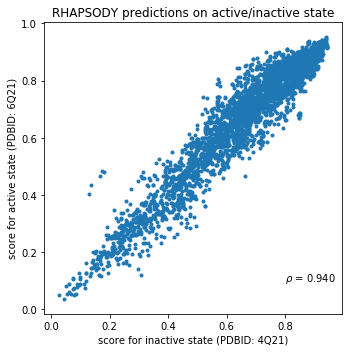

In [13]:
# import random forest scores
score_inactive = rh.getPredictions()['score']
score_active   = rh_active.getPredictions()['score']

fig, ax = plt.subplots(figsize=(5,5))

ax.scatter(score_inactive, score_active, marker='.')
ax.set_xlabel('score for inactive state (PDBID: 4Q21)')
ax.set_ylabel('score for active state (PDBID: 6Q21)')

# compute Spearman's correlation coefficient
sel = np.logical_and(~np.isnan(score_inactive), ~np.isnan(score_active))
rho = spearmanr(score_inactive[sel], score_active[sel])[0]

s = r'$\rho$'
ax.set_title('RHAPSODY predictions on active/inactive state')
ax.text(0.8, 0.1, f'{s} = {rho:5.3f}')

fig.tight_layout()
plt.savefig(f'local/figures/active_vs_inactive_correlation.png', dpi=300)

In general, predictions based on inactive *vs* active conformations are very similar. We can plot the *residue-averaged* prediction profiles on the respective structures to better highlight differences.

In [14]:
avg_prob = {}
avg_prob['inactive'] = rh.getResAvgPredictions()['path. prob.']
avg_prob['active'] = rh_active.getResAvgPredictions()['path. prob.']
avg_prob['difference'] = avg_prob['active'] - avg_prob['inactive']

# residue numbers
resids = rh.getResAvgPredictions()['PDB resid']

In [15]:
# import PDB structures
pdbs = {}
pdbs['inactive']   = pd.parsePDB('4q21', chain='A').select('protein and resid 2 to 166')
pdbs['active']     = pd.parsePDB('6q21', chain='A').select('protein and resid 2 to 166')
pdbs['difference'] = pdbs['active']

@> PDB file is found in the local folder (/home/lponzoni/.../4q21.pdb.gz).
@> 1447 atoms and 1 coordinate set(s) were parsed in 0.03s.
@> PDB file is found in the local folder (/home/lponzoni/.../6q21.pdb.gz).
@> 1484 atoms and 1 coordinate set(s) were parsed in 0.04s.


In [16]:
for case in ['inactive', 'active', 'difference']:
    pdb = pdbs[case]
    # replace the B-factor column in chain A with predictions
    PDBresids = pdb.getResnums()
    new_betas = np.zeros_like(PDBresids, dtype=float)
    for resid, prob in zip(resids, avg_prob[case]):
        if np.isnan(prob):
            prob = 0
        new_betas[PDBresids==resid] = prob
    # write modified PDB
    pdb.setBetas(new_betas)
    f = pd.writePDB(f'local/figures/mapped_pdb-{case}', pdb)

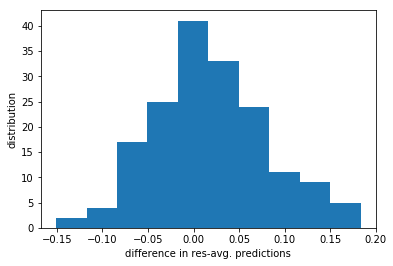

In [17]:
# plot the distribution of difference values
diff = avg_prob['difference']
plt.hist(diff[~np.isnan(diff)])
plt.ylabel('distribution')
plt.xlabel('difference in res-avg. predictions');

## Pathogenicity probability
The score returned by the random forest classifier is conveniently converted by Rhapsody in a "pathogencity probability", whose cutoff for classification lies at 0.5

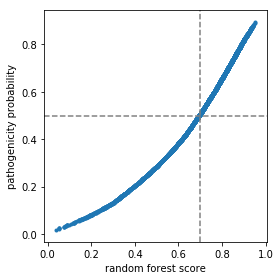

In [18]:
score = rh_active.getPredictions(classifier='main')['score']
pprob = rh_active.getPredictions(classifier='main')['path. prob.']
score_cutoff = rh_active.classifier['CV summary']['optimal cutoff']

fig, ax = plt.subplots(figsize=(4,4))

ax.scatter(score, pprob, marker='.')
ax.axvline(0.7, color='gray', ls='--')
ax.axhline(0.5, color='gray', ls='--')

ax.set_xlabel('random forest score')
ax.set_ylabel('pathogenicity probability')

fig.tight_layout()
plt.savefig(f'local/figures/score_vs_pprob.png', dpi=300)

## Comparison with experimental results from Bandaru et al.

In [19]:
# import data from file
data = {}

for f in glob.glob('data/*csv'):
    fname = os.path.basename(f, )
    case = fname.replace('.csv', '')
    with open(f, 'r') as _f:
        reader = csv.reader(_f)
        data[case] = list(reader)
        
exp_sequence = ''.join(data['attenuated_RAS'][1])

**NB:** The sequence used in the experiments is a substring of the Uniprot sequence:

In [20]:
acc = 'P01112'
sequence = pd.queryUniprot(acc)['sequence   0'].replace('\n', '')

In [21]:
print('Uniprot sequence length:', len(sequence))
print('Exp. sequence length:   ', len(exp_sequence))

Uniprot sequence length: 189
Exp. sequence length:    165


In [22]:
exp_sequence == sequence[1: len(exp_sequence)+1]

True

In [23]:
# convert data to dictionary
tables = {}

for case, d in data.items():
    resids = d[0][1:]
    wt_aas = d[1][1:]
    table = {}
    for line in d[2:]:
        mut_aa = line[0]
        for i, x in enumerate(line[1:]):
            resid = int(resids[i])
            wt_aa = wt_aas[i]
            table[f'P01112 {resid} {wt_aa} {mut_aa}'] = float(x)
    tables[case] = table

In [24]:
# the dictionary contains data from 4 different experimental setups
tables.keys()

dict_keys(['regulated_RAS', 'unregulated_RAS', 'attenuated_RAS', 'G12V_RAS'])

In [25]:
# put exp. data in array form and in the same order as Rhapsody predictions
SAV_coords = rh.getSAVcoords()

exp_scores = {}
for case, table in tables.items():
    a = np.zeros(len(SAV_coords))
    a[:] = np.nan
    for i, SAV in enumerate(SAV_coords):
        if SAV in table:
            a[i] = table[SAV]
    exp_scores[case] = a

# compute residue-averaged functional effects
avg_exp_scores = {}
for case, exp_score in exp_scores.items():
    avg_exp_scores[case] = np.nanmean(exp_score.reshape((-1, 19)), axis=1)

/home/lponzoni/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: Mean of empty slice
  app.launch_new_instance()


In [26]:
methods = ['Rhapsody (inactive state)', 
           'Rhapsody (active state)', 
           'EVmutation', 
           'PolyPhen-2']

# import computational scores
comput_scores = {
  'Rhapsody (inactive state)': rh.getPredictions()['path. prob.'], 
  'Rhapsody (active state)' :  rh_active.getPredictions()['path. prob.'], 
  'EVmutation' :               - rh.getPredictions()['EVmutation score'], 
  'PolyPhen-2' :               rh.getPredictions()['PolyPhen-2 score']
}

# import residue-averaged computational scores
avg_comput_scores = {
  'Rhapsody (inactive state)': rh.getResAvgPredictions()['path. prob.'], 
  'Rhapsody (active state)' :  rh_active.getResAvgPredictions()['path. prob.'], 
  'EVmutation' :               - rh.getResAvgPredictions()['EVmutation score'], 
  'PolyPhen-2' :               rh.getResAvgPredictions()['PolyPhen-2 score']
}

### Spearman correlation

In the following, we compute and plot the correlation between experimental measurements and computational predictions.

In [27]:
exp_comp_methods = ['regulated_RAS'] + methods

print(' '*18, end='')
for m in exp_comp_methods:
    m = m.replace('inactive state', 'in.')
    m = m.replace('active state', 'act.')
    print(f'{m:18}', end='')
print()
for i, m_i in enumerate(exp_comp_methods):
    m = m_i.replace('inactive state', 'in.')
    m = m.replace('active state', 'act.')
    print(f'{m:18} ', end='')
    if i == 0:
        s_i = exp_scores[m_i]
        a_i = avg_exp_scores[m_i]
    else:
        s_i = comput_scores[m_i]
        a_i = avg_comput_scores[m_i]
    for j, m_j in enumerate(exp_comp_methods):
        if j == 0:
            s_j = exp_scores[m_j]
            a_j = avg_exp_scores[m_j]
        else:
            s_j = comput_scores[m_j]
            a_j = avg_comput_scores[m_j]
        # compute Spearman's correlation
        if j > i:
            sel = np.logical_and(~np.isnan(s_i), ~np.isnan(s_j))
            rho = spearmanr(s_i[sel], s_j[sel])[0]
            s = f'{rho:5.3f}'
        elif j < i:
            sel = np.logical_and(~np.isnan(a_i), ~np.isnan(a_j))
            rho = spearmanr(a_i[sel], a_j[sel])[0]
            s = f'({rho:5.3f})'
        else:
            s = '-'
        print(f'{s:<18}', end='')
    print()

                  regulated_RAS     Rhapsody (in.)    Rhapsody (act.)   EVmutation        PolyPhen-2        
regulated_RAS      -                 -0.426            -0.428            -0.420            -0.364            
Rhapsody (in.)     (-0.603)          -                 0.939             0.715             0.820             
Rhapsody (act.)    (-0.570)          (0.939)           -                 0.716             0.812             
EVmutation         (-0.518)          (0.811)           (0.788)           -                 0.703             
PolyPhen-2         (-0.513)          (0.874)           (0.862)           (0.784)           -                 


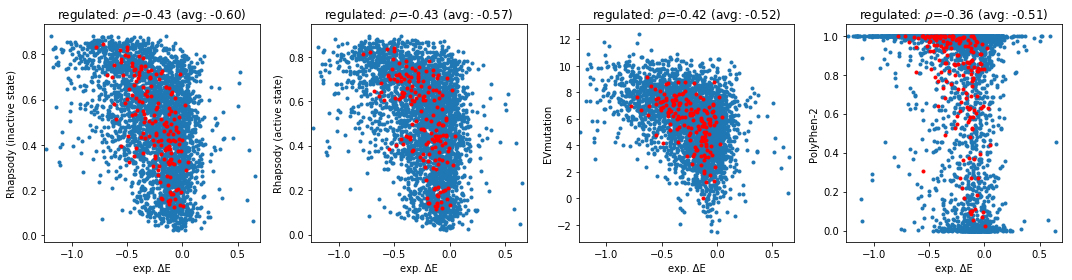

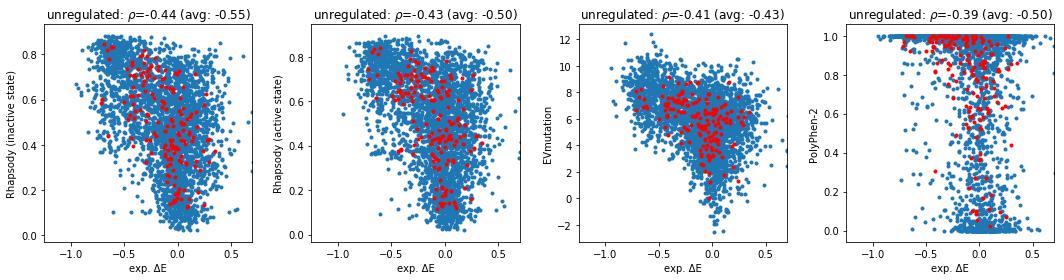

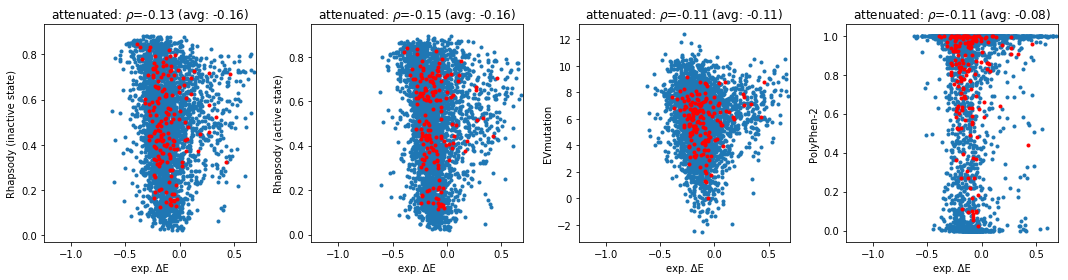

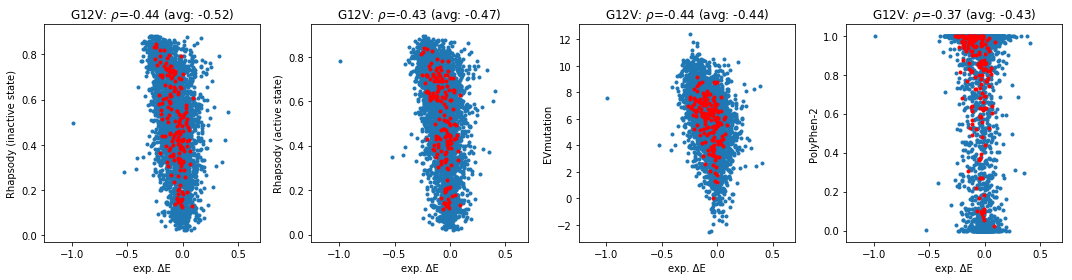

In [28]:
for case in exp_scores:
    exp_score     = exp_scores[case]
    avg_exp_score = avg_exp_scores[case]
    
    fig, axes = plt.subplots(1, 4, figsize=(15,4))
    
    for i, ax in enumerate(axes):
        method = methods[i]
        # individual fitness scores
        cs = comput_scores[method]
        ax.scatter(exp_score, cs, marker='.')
        sel = np.logical_and(~np.isnan(exp_score), ~np.isnan(cs))
        rho = spearmanr(exp_score[sel], cs[sel])[0]
        # residue-averaged fitness scores
        acs = avg_comput_scores[method]
        ax.scatter(avg_exp_score, acs, marker='.', c='r')
        sel = np.logical_and(~np.isnan(avg_exp_score), ~np.isnan(acs))
        rho_av = spearmanr(avg_exp_score[sel], acs[sel])[0]
        # print labels
        ax.set_ylabel(method)
        s = r'$\rho$'
        ax.set_title(f'{case[:-4]}: {s}={rho:5.2f} (avg: {rho_av:5.2f})')
        ax.set_xlim((-1.25, 0.7))
        ax.set_xlabel('exp. ΔE')

    fig.tight_layout()
    plt.savefig(f'local/figures/correlation-{case}.png', dpi=300)

Since the goal of Rhapsody is to identify mutations that impair the normal activity and interactions of proteins, specifically by taking into account changes to their internal structural dynamics, we can focus on the "regulated" case (its "wild-type" context) among those presented in the paper.
From the plots in the first line, we see that Rhapsody (computed on both inactive and active states) performs in general better than both EVmutation and PolyPhen-2. 

### ROCs, Precision-Recall curves and other metrics

We can also obtain a binary classification from the distribution of functional effects by setting a cutoff according to what is considered a "significant loss of function". We will choose the median as cutoff. This allows us to compute ROC and Precision-Recall curves and compare performances based on different metrics.

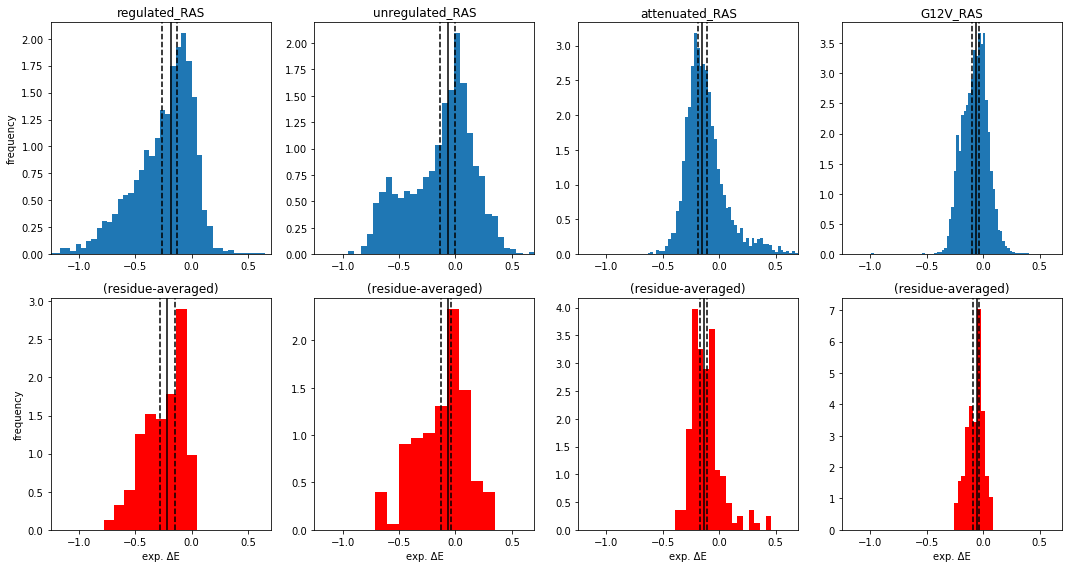

In [29]:
cutoff_qs = [40, 50, 60]
cutoff_qs.sort()

cutoffs = {}
avg_cutoffs = {}

fig, axes = plt.subplots(2, 4, figsize=(15,8))

for i, case in enumerate(exp_scores):
    exp_score = exp_scores[case]
    exp_score = exp_score[~np.isnan(exp_score)]
    avg_exp_score = avg_exp_scores[case]
    avg_exp_score = avg_exp_score[~np.isnan(avg_exp_score)]
    
    # cutoff definitions
    cutoffs[case]     = {q: np.nanpercentile(exp_score, q) for q in cutoff_qs}
    avg_cutoffs[case] = {q: np.nanpercentile(avg_exp_score, q) for q in cutoff_qs}
    
    ax1 = axes[0, i]
    ax2 = axes[1, i]
    
    ax1.hist(exp_score, density=True, bins='auto')
    ax2.hist(avg_exp_score, density=True, bins='auto', color='red')
    for q in cutoff_qs:
        cutoff     = cutoffs[case][q]
        avg_cutoff = avg_cutoffs[case][q]
        if q == cutoff_qs[1]:
            ax1.axvline(cutoff, color='k') 
            ax2.axvline(avg_cutoff, color='k') 
        else:
            ax1.axvline(cutoff, color='k', ls='--') 
            ax2.axvline(avg_cutoff, color='k', ls='--') 
    
    ax1.set_title(case)
    ax2.set_title('(residue-averaged)')
    ax1.set_xlim((-1.25, 0.7))
    ax2.set_xlim((-1.25, 0.7))
    ax2.set_xlabel('exp. ΔE')
    
axes[0,0].set_ylabel('frequency')
axes[1,0].set_ylabel('frequency')
    
fig.tight_layout()
fig.savefig(f'local/figures/histograms-cutoff.png', dpi=300)

In [30]:
cutoffs

{'regulated_RAS': {40: -0.2627257429396158,
  50: -0.185003117052718,
  60: -0.12880622092509258},
 'unregulated_RAS': {40: -0.1391366833582583,
  50: -0.064531249718215,
  60: -0.003961961465336603},
 'attenuated_RAS': {40: -0.18497620448400998,
  50: -0.149177777500935,
  60: -0.11280964083570642},
 'G12V_RAS': {40: -0.09607740790955578,
  50: -0.065299663607474,
  60: -0.03632001506460561}}

In [31]:
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import f1_score, matthews_corrcoef

metrics = {}

for case in exp_scores:
    
    metrics[case] = {}
    
    # experimental measurements (fitness effects)
    exp_score     = exp_scores[case]
    avg_exp_score = avg_exp_scores[case]

    # loop over computational methods 
    for method in methods:
                      
        # individual and residue-averaged computational predictions fitness effects
        comput_score = comput_scores[method]
        avg_comput_score = avg_comput_scores[method]
        
        # discard NaN values
        sel = np.logical_and(~np.isnan(exp_score), ~np.isnan(comput_score))
        avg_sel = np.logical_and(~np.isnan(avg_exp_score), ~np.isnan(avg_comput_score))

        m = {}
        
        # loop over cutoffs for experimental values
        for q in cutoff_qs:
            cutoff     = cutoffs[case][q]
            avg_cutoff = avg_cutoffs[case][q]
            
            m[q] = {}
            
            # binary classification and computational score for individual measurements
            exp_class = np.where(exp_score[sel] < cutoff, 1, 0)
            cs = comput_score[sel]
            # curves and metrics
            fpr, tpr, _   = roc_curve(exp_class, cs)
            prc, rec, _   = precision_recall_curve(exp_class, cs)
            m[q]['ROC']   = (fpr, tpr)
            m[q]['PRC']   = (prc, rec)
            m[q]['AUROC'] = roc_auc_score(exp_class, cs)
            m[q]['AUPRC'] = average_precision_score(exp_class, cs)

            # binary classification for residue-averaged measurements
            exp_class = np.where(avg_exp_score[avg_sel] < avg_cutoff, 1, 0)
            cs = avg_comput_score[avg_sel]
            # curves and metrics
            fpr, tpr, _   = roc_curve(exp_class, cs)
            prc, rec, _   = precision_recall_curve(exp_class, cs)
            m[q]['avg_ROC']   = (fpr, tpr)
            m[q]['avg_PRC']   = (prc, rec)
            m[q]['avg_AUROC'] = roc_auc_score(exp_class, cs)
            m[q]['avg_AUPRC'] = average_precision_score(exp_class, cs)

        metrics[case][method] = m

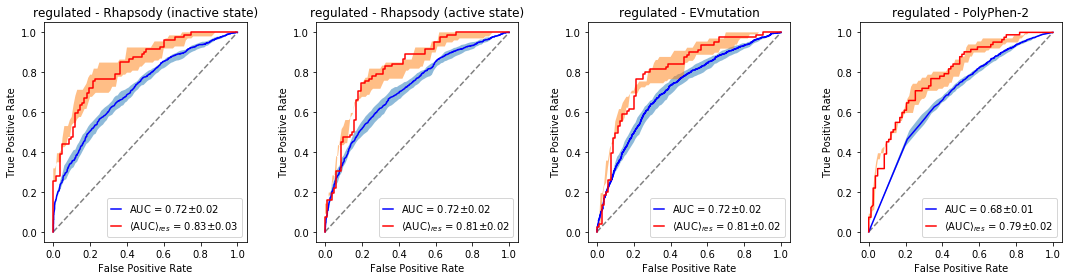

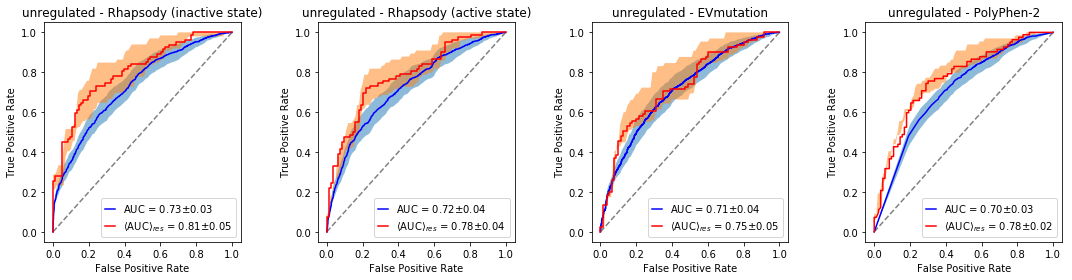

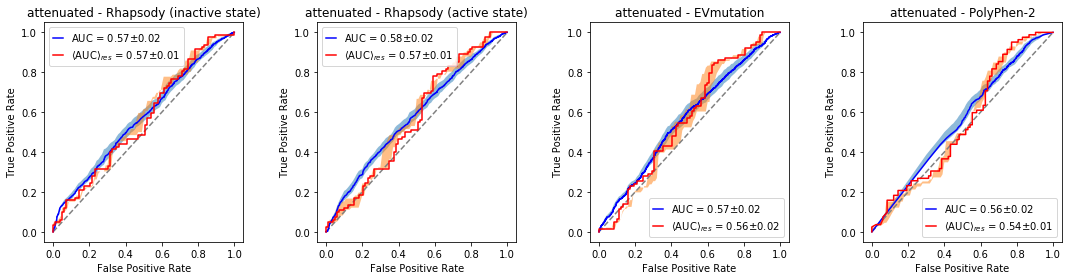

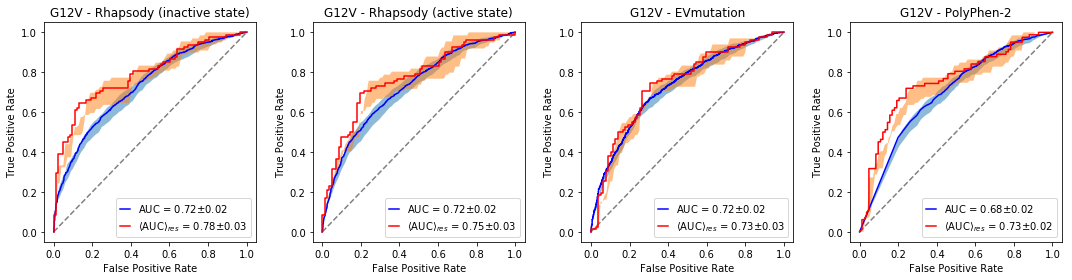

In [32]:
for case in exp_scores:

    fig, axes = plt.subplots(1, 4, figsize=(15,4))
    
    for i, ax in enumerate(axes):
        method = methods[i]
        
        m = metrics[case][method]
        q0, q1, q2 = cutoff_qs
        
        # random ROC
        ax.plot([0,1], [0,1], '--', color='gray')
        
        # plot for individual fitness effects
        aucs = [m[q]['AUROC'] for q in m.keys()]
        l = r'AUC = {:4.2f}$\pm${:4.2f}'.format(np.mean(aucs), np.std(aucs))
        ax.plot(m[q1]['ROC'][0], m[q1]['ROC'][1], 'b-', label=l)
        x_dense = np.arange(0,1,.01) 
        ax.fill_between(x_dense, np.interp(x_dense, m[q0]['ROC'][0], m[q0]['ROC'][1]), 
                                 np.interp(x_dense, m[q2]['ROC'][0], m[q2]['ROC'][1]), alpha=.5)

        # plot for residue-averaged fitness effects
        aucs = [m[q]['avg_AUROC'] for q in m.keys()]
        l = r'$\langle$AUC$\rangle _{res}$ = ' 
        l += r'{:4.2f}$\pm${:4.2f}'.format(np.mean(aucs), np.std(aucs)) 
        ax.plot(m[q1]['avg_ROC'][0], m[q1]['avg_ROC'][1], 'r-', label=l)
        x_dense = np.arange(0,1,.01) 
        ax.fill_between(x_dense, np.interp(x_dense, m[q0]['avg_ROC'][0], m[q0]['avg_ROC'][1]), 
                                 np.interp(x_dense, m[q2]['avg_ROC'][0], m[q2]['avg_ROC'][1]), alpha=.5)
        
        # set labels
        ax.set_title(f'{case[:-4]} - {method}')   
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.legend(handlelength=1)

    fig.tight_layout()
    fig.savefig(f'local/figures/ROC-{case}.png', dpi=300)

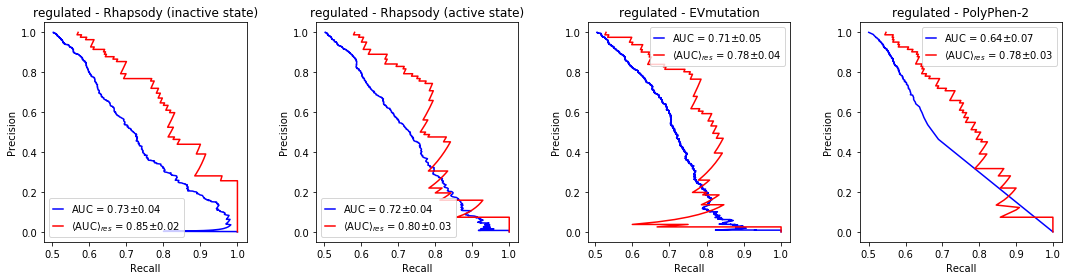

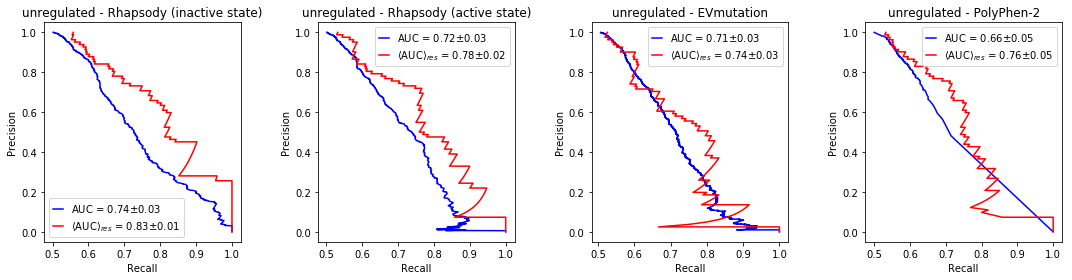

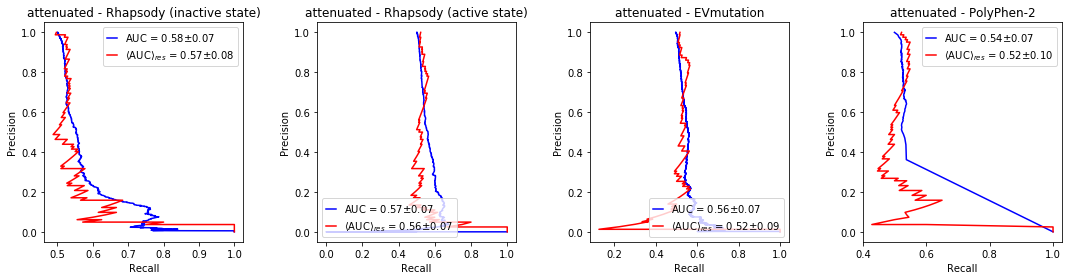

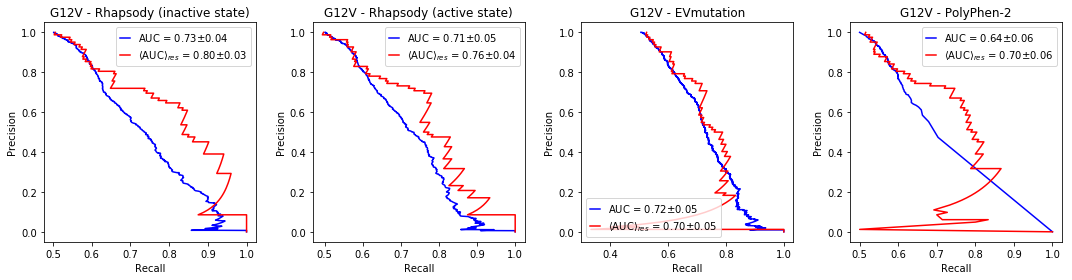

In [33]:
for case in exp_scores:

    fig, axes = plt.subplots(1, 4, figsize=(15,4))
    
    for i, ax in enumerate(axes):
        method = methods[i]
        
        m = metrics[case][method]
        q0, q1, q2 = cutoff_qs
        
        # plot for individual fitness effects
        aucs = [m[q]['AUPRC'] for q in cutoff_qs]
        l = r'AUC = {:4.2f}$\pm${:4.2f}'.format(np.mean(aucs), np.std(aucs))
        ax.plot(m[q1]['PRC'][0], m[q1]['PRC'][1], 'b-', label=l)

        # plot for residue-averaged fitness effects
        aucs = [m[q]['avg_AUPRC'] for q in cutoff_qs]
        l = r'$\langle$AUC$\rangle _{res}$ = ' 
        l += r'{:4.2f}$\pm${:4.2f}'.format(np.mean(aucs), np.std(aucs)) 
        ax.plot(m[q1]['avg_PRC'][0], m[q1]['avg_PRC'][1], 'r-', label=l)
        
        # set labels
        ax.set_title(f'{case[:-4]} - {method}')   
        ax.set_xlabel('Recall')
        ax.set_ylabel('Precision')
        ax.legend(handlelength=1)

    fig.tight_layout()
    fig.savefig(f'local/figures/PRC-{case}.png', dpi=300)

In the following, we apply an alternative definition of "deleterious" variants, that include not only loss-of-function mutations, but also gain-of-function mutations. We can do that by considering as "positive cases" those whose difference in fitness with respect to wild-type is greater than a certain threshold, in both directions.

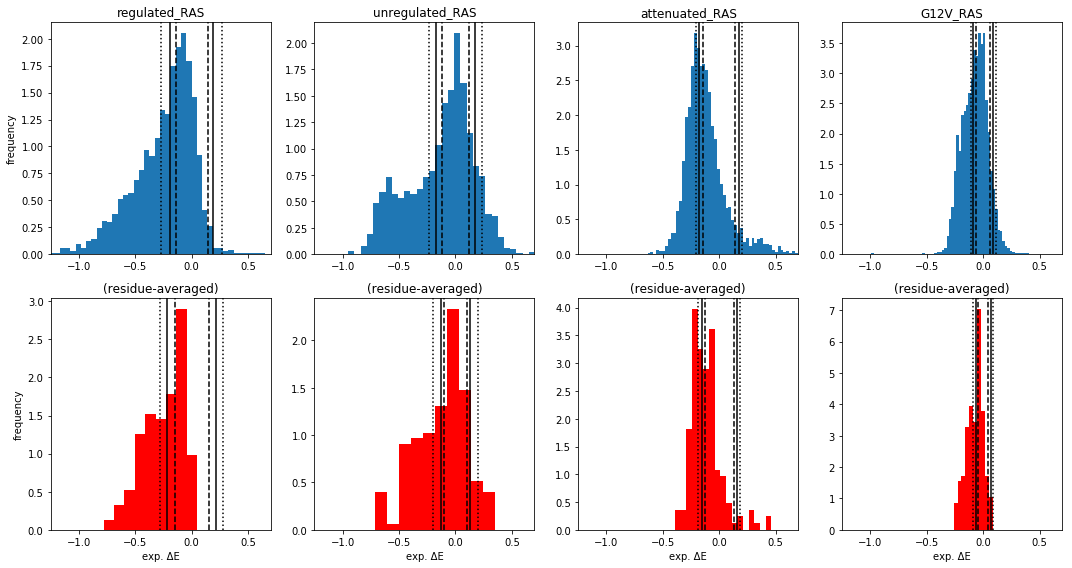

In [34]:
threshold_qs = [40, 50, 60]
threshold_qs.sort()

thresholds = {}
avg_thresholds = {}


fig, axes = plt.subplots(2, 4, figsize=(15,8))

for i, case in enumerate(exp_scores):
    exp_score = exp_scores[case]
    exp_score = exp_score[~np.isnan(exp_score)]
    avg_exp_score = avg_exp_scores[case]
    avg_exp_score = avg_exp_score[~np.isnan(avg_exp_score)]
    
    # threshold definitions
    thresholds[case]     = {q: np.nanpercentile(abs(exp_score), q) for q in cutoff_qs}
    avg_thresholds[case] = {q: np.nanpercentile(abs(avg_exp_score), q) for q in cutoff_qs}
    
    ax1 = axes[0, i]
    ax2 = axes[1, i]
    
    ax1.hist(exp_score, density=True, bins='auto')
    ax2.hist(avg_exp_score, density=True, bins='auto', color='red')

    for q, ls in zip(threshold_qs, ['--', '-', ':']):
        threshold     = thresholds[case][q]
        avg_threshold = avg_thresholds[case][q]
        ax1.axvline( threshold, color='k', ls=ls) 
        ax1.axvline(-threshold, color='k', ls=ls) 
        ax2.axvline( avg_threshold, color='k', ls=ls) 
        ax2.axvline(-avg_threshold, color='k', ls=ls) 
    
    ax1.set_title(case)
    ax2.set_title('(residue-averaged)')
    ax1.set_xlim((-1.25, 0.7))
    ax2.set_xlim((-1.25, 0.7))
    ax2.set_xlabel('exp. ΔE')
    
axes[0,0].set_ylabel('frequency')
axes[1,0].set_ylabel('frequency')

fig.tight_layout()
fig.savefig(f'local/figures/histograms-threshold.png', dpi=300)

In [35]:
thresholds

{'regulated_RAS': {40: 0.14224669024212144,
  50: 0.1932642529612,
  60: 0.2684421666548036},
 'unregulated_RAS': {40: 0.12258084873149042,
  50: 0.170601543523011,
  60: 0.23386959130022078},
 'attenuated_RAS': {40: 0.142329784270181,
  50: 0.17526896277679,
  60: 0.2046635357484472},
 'G12V_RAS': {40: 0.06454427247713701,
  50: 0.085167183460886,
  60: 0.11040889530293377}}

In [36]:
metrics_2 = {}

for case in exp_scores:
    
    metrics_2[case] = {}
    
    # experimental measurements (fitness effects)
    exp_score     = exp_scores[case]
    avg_exp_score = avg_exp_scores[case]

    # loop over computational methods 
    for method in methods:
                      
        # individual and residue-averaged computational predictions fitness effects
        comput_score = comput_scores[method]
        avg_comput_score = avg_comput_scores[method]
        
        # discard NaN values
        sel = np.logical_and(~np.isnan(exp_score), ~np.isnan(comput_score))
        avg_sel = np.logical_and(~np.isnan(avg_exp_score), ~np.isnan(avg_comput_score))

        m = {}
        
        # loop over thresholds for experimental values
        for q in threshold_qs:
            threshold     = thresholds[case][q]
            avg_threshold = avg_thresholds[case][q]
            
            m[q] = {}
            
            # binary classification and computational score for individual measurements
            exp_class = np.where(abs(exp_score[sel]) > threshold, 1, 0)
            cs = comput_score[sel]
            # curves and metrics
            fpr, tpr, _   = roc_curve(exp_class, cs)
            prc, rec, _   = precision_recall_curve(exp_class, cs)
            m[q]['ROC']   = (fpr, tpr)
            m[q]['PRC']   = (prc, rec)
            m[q]['AUROC'] = roc_auc_score(exp_class, cs)
            m[q]['AUPRC'] = average_precision_score(exp_class, cs)


            # binary classification for residue-averaged measurements
            exp_class = np.where(abs(avg_exp_score[avg_sel]) > avg_threshold, 1, 0)
            cs = avg_comput_score[avg_sel]
            # curves and metrics
            fpr, tpr, _   = roc_curve(exp_class, cs)
            prc, rec, _   = precision_recall_curve(exp_class, cs)
            m[q]['avg_ROC']   = (fpr, tpr)
            m[q]['avg_PRC']   = (prc, rec)
            m[q]['avg_AUROC'] = roc_auc_score(exp_class, cs)
            m[q]['avg_AUPRC'] = average_precision_score(exp_class, cs)

        metrics_2[case][method] = m

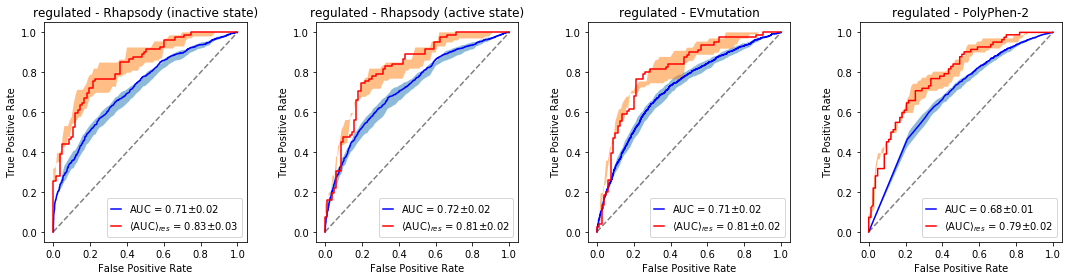

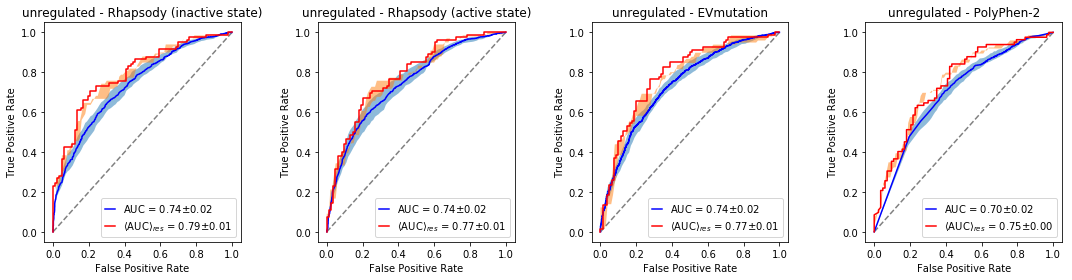

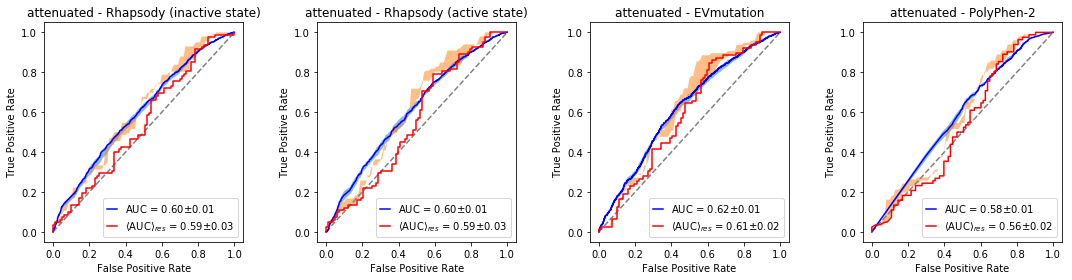

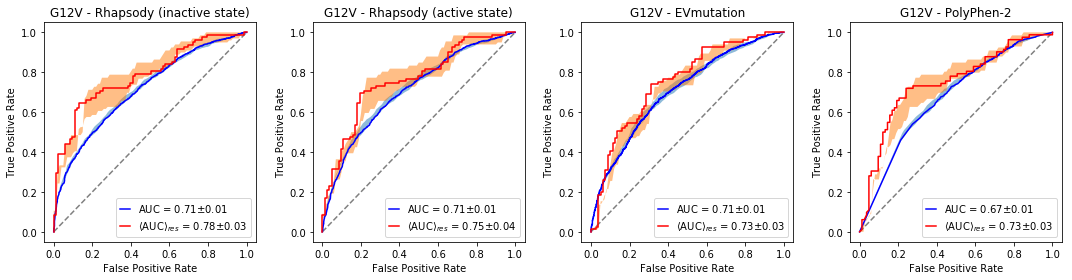

In [37]:
for case in exp_scores:

    fig, axes = plt.subplots(1, 4, figsize=(15,4))
    
    for i, ax in enumerate(axes):
        method = methods[i]
        
        m = metrics_2[case][method]
        q0, q1, q2 = threshold_qs
        
        # random ROC
        ax.plot([0,1], [0,1], '--', color='gray')
        
        # plot for individual fitness effects
        aucs = [m[q]['AUROC'] for q in m.keys()]
        l = r'AUC = {:4.2f}$\pm${:4.2f}'.format(np.mean(aucs), np.std(aucs))
        ax.plot(m[q1]['ROC'][0], m[q1]['ROC'][1], 'b-', label=l)
        x_dense = np.arange(0,1,.01) 
        ax.fill_between(x_dense, np.interp(x_dense, m[q0]['ROC'][0], m[q0]['ROC'][1]), 
                                 np.interp(x_dense, m[q2]['ROC'][0], m[q2]['ROC'][1]), alpha=.5)

        # plot for residue-averaged fitness effects
        aucs = [m[q]['avg_AUROC'] for q in m.keys()]
        l = r'$\langle$AUC$\rangle _{res}$ = ' 
        l += r'{:4.2f}$\pm${:4.2f}'.format(np.mean(aucs), np.std(aucs)) 
        ax.plot(m[q1]['avg_ROC'][0], m[q1]['avg_ROC'][1], 'r-', label=l)
        x_dense = np.arange(0,1,.01) 
        ax.fill_between(x_dense, np.interp(x_dense, m[q0]['avg_ROC'][0], m[q0]['avg_ROC'][1]), 
                                 np.interp(x_dense, m[q2]['avg_ROC'][0], m[q2]['avg_ROC'][1]), alpha=.5)
        
        # set labels
        ax.set_title(f'{case[:-4]} - {method}')   
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.legend(handlelength=1)

    fig.tight_layout()
    fig.savefig(f'local/figures/ROC-2-{case}.png', dpi=300)

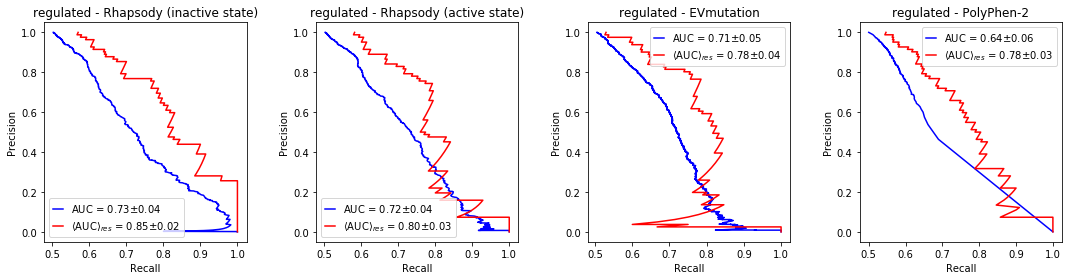

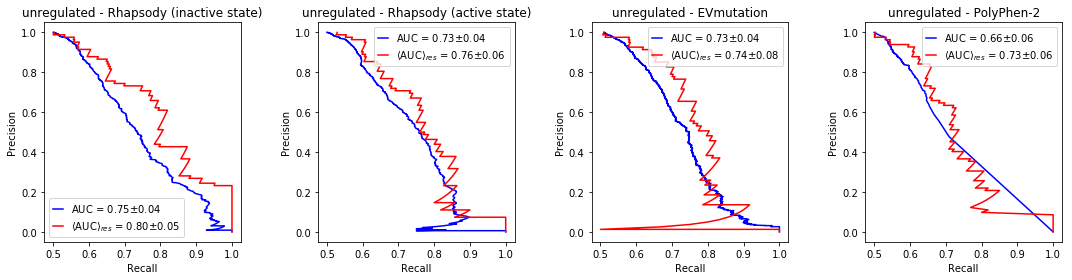

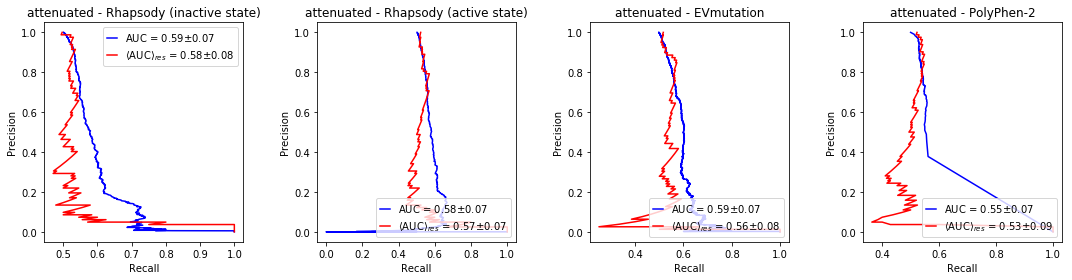

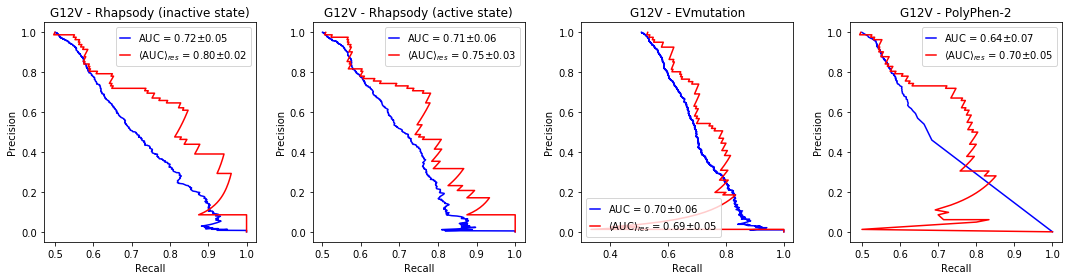

In [38]:
for case in exp_scores:

    fig, axes = plt.subplots(1, 4, figsize=(15,4))
    
    for i, ax in enumerate(axes):
        method = methods[i]
        
        m = metrics_2[case][method]
        q0, q1, q2 = threshold_qs
        
        # plot for individual fitness effects
        aucs = [m[q]['AUPRC'] for q in cutoff_qs]
        l = r'AUC = {:4.2f}$\pm${:4.2f}'.format(np.mean(aucs), np.std(aucs))
        ax.plot(m[q1]['PRC'][0], m[q1]['PRC'][1], 'b-', label=l)

        # plot for residue-averaged fitness effects
        aucs = [m[q]['avg_AUPRC'] for q in cutoff_qs]
        l = r'$\langle$AUC$\rangle _{res}$ = ' 
        l += r'{:4.2f}$\pm${:4.2f}'.format(np.mean(aucs), np.std(aucs)) 
        ax.plot(m[q1]['avg_PRC'][0], m[q1]['avg_PRC'][1], 'r-', label=l)
        
        # set labels
        ax.set_title(f'{case[:-4]} - {method}')   
        ax.set_xlabel('Recall')
        ax.set_ylabel('Precision')
        ax.legend(handlelength=1)

    fig.tight_layout()
    fig.savefig(f'local/figures/PRC-2-{case}.png', dpi=300)

### *In silico* saturation mutagenesis table
Experimental measurements (fitness scores) are reversed to make the comparison with computational profiles easier.

In [39]:
exp_score = - exp_scores['regulated_RAS']

In [40]:
rd.print_sat_mutagen_figure('local/figures/sat_mutagen-inactive-1', rh, 
                            extra_plot=exp_score, res_interval=(1,95))
rd.print_sat_mutagen_figure('local/figures/sat_mutagen-inactive-2', rh, 
                            extra_plot=exp_score, res_interval=(95,190))

@> Saturation mutagenesis figure saved to local/figures/sat_mutagen-inactive-1.png
@> Saturation mutagenesis figure saved to local/figures/sat_mutagen-inactive-2.png


In [41]:
rd.print_sat_mutagen_figure('local/figures/sat_mutagen-active-1', rh_active, 
                            extra_plot=exp_score, res_interval=(1,95))
rd.print_sat_mutagen_figure('local/figures/sat_mutagen-active-2', rh_active, 
                            extra_plot=exp_score, res_interval=(95,190))

@> Saturation mutagenesis figure saved to local/figures/sat_mutagen-active-1.png
@> Saturation mutagenesis figure saved to local/figures/sat_mutagen-active-2.png


We plot the secondary structure and solvent accessible surface area (SASA) in two strips to be paired with the saturation mutagenesis tables.

In [42]:
# compute secondary structure and SASA with DSSP
ag = pd.performDSSP('6q21')
os.remove('6q21.pdb')
os.remove('6q21.dssp')

@> PDB file is found in the local folder (6q21.pdb).
@> 6057 atoms and 1 coordinate set(s) were parsed in 0.09s.


In [43]:
SASAs = np.zeros(190)
SSTRs = np.zeros(190)
SASAs[:] = np.nan
SSTRs[:] = np.nan

ag_ca = ag['A'].ca
for resid, sasa, sstr in zip(ag_ca.getResnums(), 
                             ag_ca.getData('dssp_acc'), 
                             ag_ca.getSecstrs()):
    SASAs[resid-1] = sasa
    if sstr in list('GHI'): # helix
        _sstr = 2
    elif sstr in list('EB'): # strand
        _sstr = 1
    else: # loop
        _sstr = np.nan
    SSTRs[resid-1] = _sstr

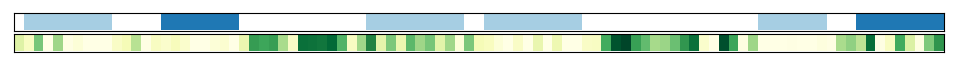

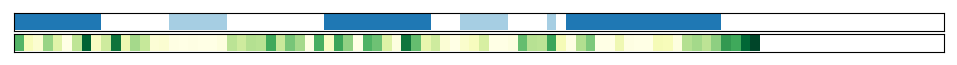

In [44]:
for i, (res_i, res_f) in enumerate([(1,95), (95,190)]):
    
    fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(12, 0.5))
    for ax in (ax0, ax1):
        ax.tick_params(axis='both', which='both', left=False, bottom=False, 
                       labelbottom=False, labelleft=False)
    # plot secondary structure
    SSTR_plot = SSTRs[res_i-1:res_f].reshape((1,-1))
    ax0.imshow(SSTR_plot, aspect='auto', cmap='Paired', vmax=12)
    # plot SASA
    SASA_plot = SASAs[res_i-1:res_f].reshape((1,-1))
    ax1.imshow(SASA_plot, aspect='auto', cmap='YlGn')
    fig.savefig(f'local/figures/sat_mutagen-active-{i+1}-strip', dip=300)

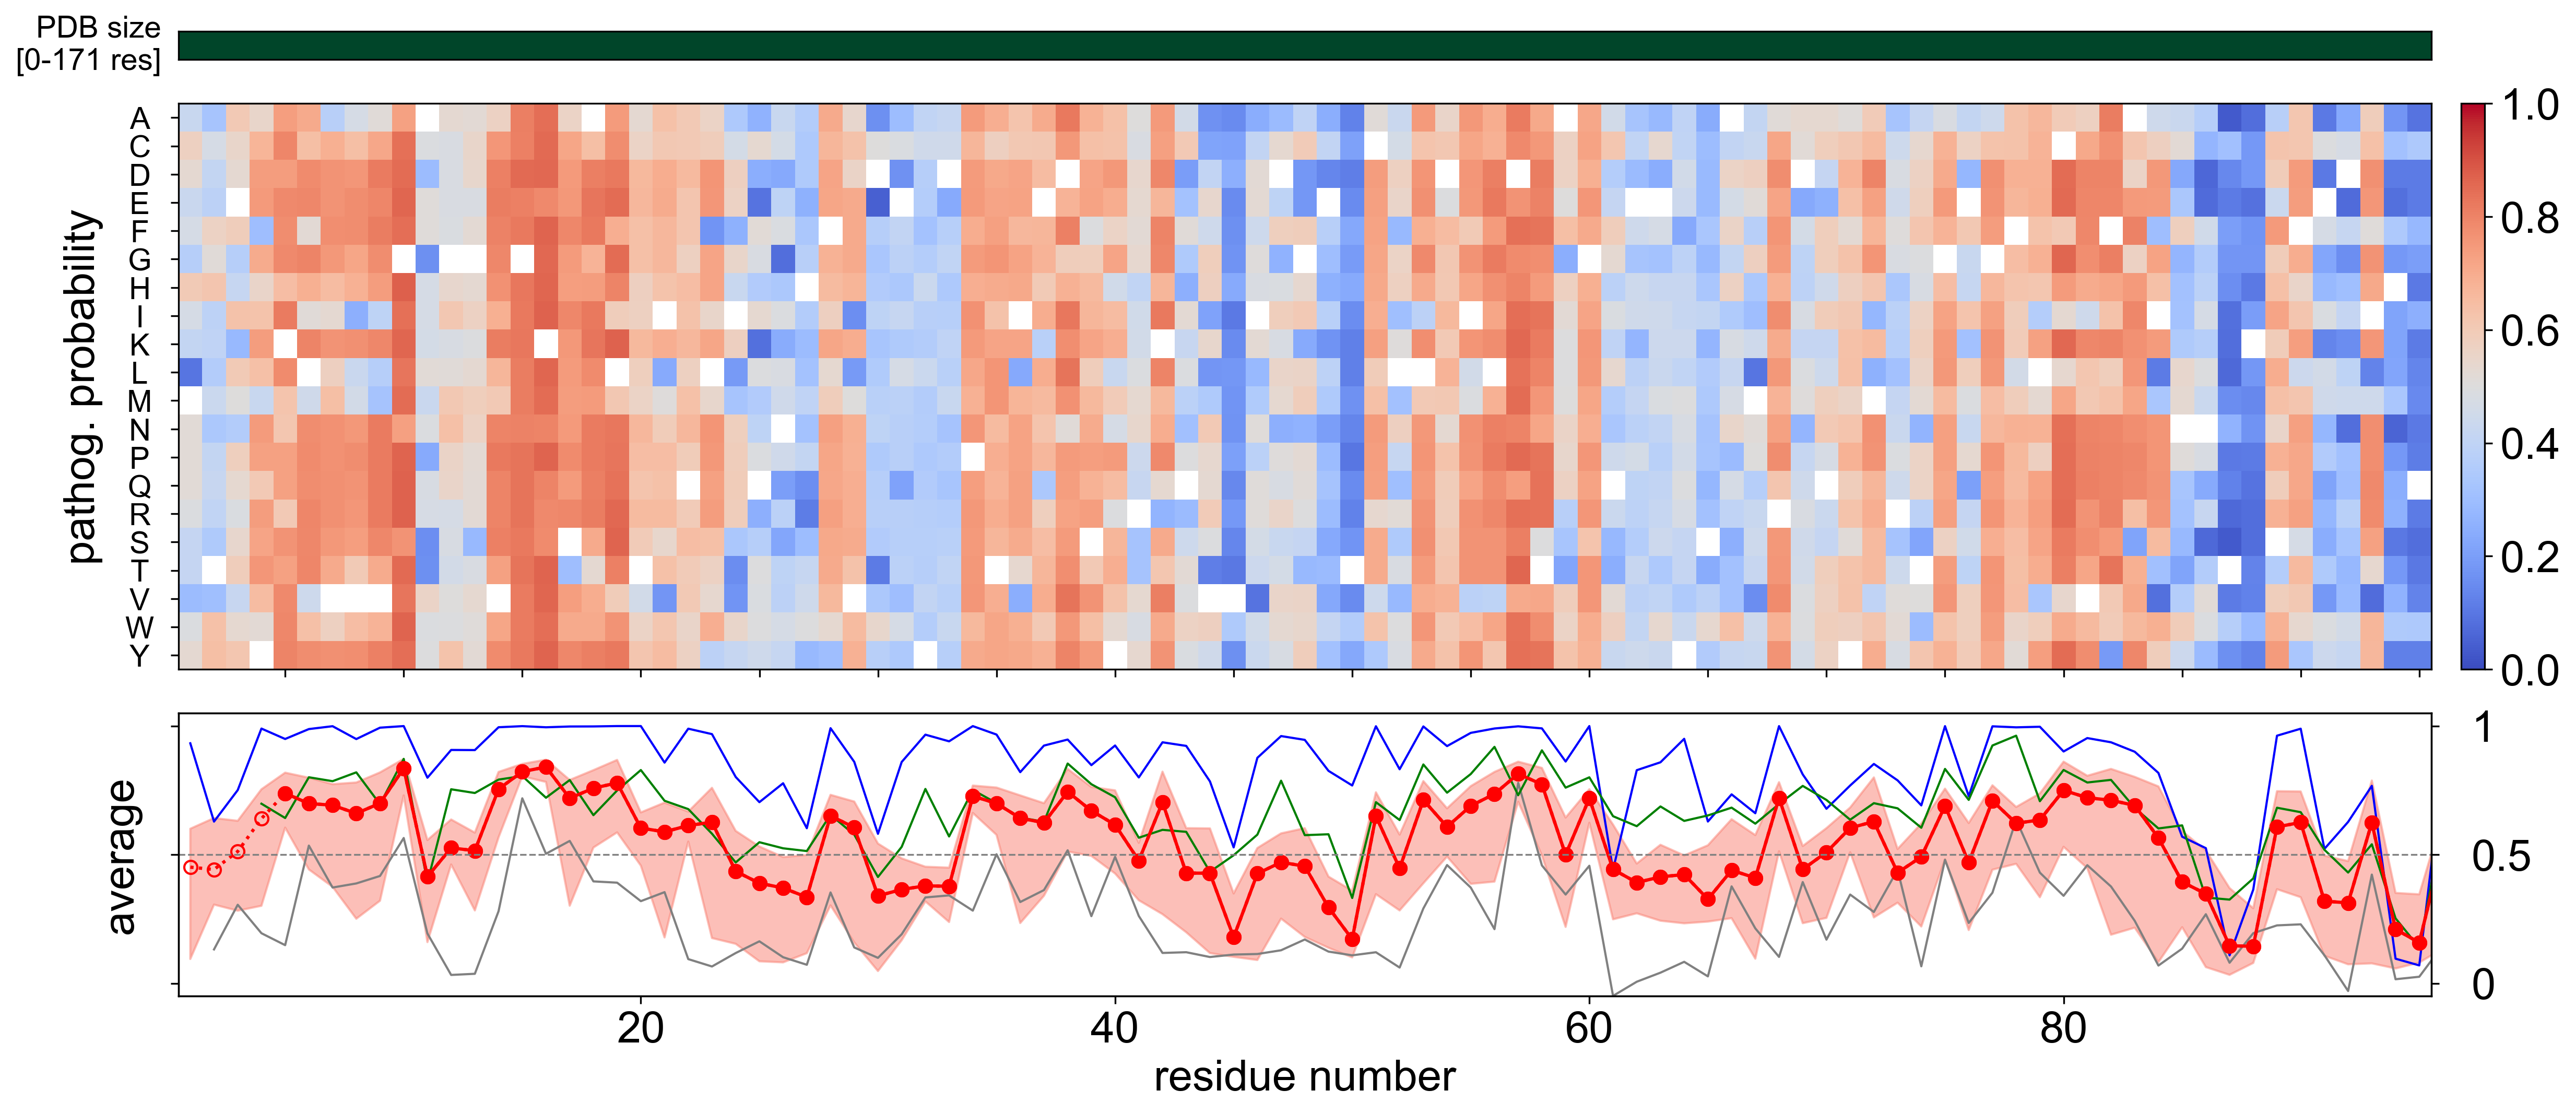

In [45]:
# example of saturation mutagenesis table 
from IPython.display import Image
Image('local/figures/sat_mutagen-active-1.png')

### Agreement with experimental measurements shown on PDB structure
We highlight on the 3D structure of RAS those residues were Rhapsody generally fails to provide correct predictions, in an attempt to identify the method's limitations.

/home/lponzoni/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in greater
  import sys
/home/lponzoni/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in less
  
/home/lponzoni/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in greater
  # This is added back by InteractiveShellApp.init_path()
/home/lponzoni/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in less
  if sys.path[0] == '':


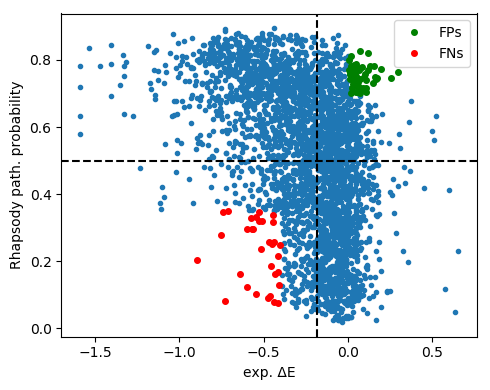

In [46]:
exp_score = exp_scores['regulated_RAS']
comput_score = rh_active.getPredictions()['path. prob.']

exp_cutoff    = np.nanmedian(exp_score)
comput_cutoff = 0.5

FPs = np.logical_and(exp_score > exp_cutoff, comput_score > comput_cutoff)
FNs = np.logical_and(exp_score < exp_cutoff, comput_score < comput_cutoff)

# We arbitrarily select two subsets with the least accurate predictions
worst_FPs = np.logical_and(exp_score > 0, comput_score > 0.7)
worst_FNs = np.logical_and(exp_score < -.4, comput_score < 0.35)

fig, ax = plt.subplots(figsize=(5,4))
ax.plot(exp_score, comput_score, '.')
ax.plot(exp_score[worst_FPs], comput_score[worst_FPs], 'g.', ms=8, label='FPs')
ax.plot(exp_score[worst_FNs], comput_score[worst_FNs], 'r.', ms=8, label='FNs')

ax.axvline(exp_cutoff, ls='--', c='k')
ax.axhline(comput_cutoff, ls='--', c='k')

ax.set_ylabel('Rhapsody path. probability')
ax.set_xlabel('exp. ΔE')

ax.legend()
fig.tight_layout()
plt.savefig(f'local/figures/scatter_plot-FPsFNs.png', dpi=300)

In [47]:
worst_FP_resids = set([int(s.split()[2]) for s in rh_active.getPDBcoords()['PDB SAV coords'][worst_FPs]])
worst_FN_resids = set([int(s.split()[2]) for s in rh_active.getPDBcoords()['PDB SAV coords'][worst_FNs]])
# the two sets are mutually exclusive
worst_FP_resids.intersection(worst_FN_resids)

set()

In [48]:
pdb = pd.parsePDB('6q21', chain='A').select('protein and resid 2 to 166')

# replace the B-factor column in chain A with Rhapsody predictions
PDBresids = pdb.getResnums()
new_betas = np.zeros_like(PDBresids, dtype=float)
for i, resid in enumerate(PDBresids):
    if resid in worst_FP_resids:
        beta = 1
    elif resid in worst_FN_resids:
        beta = -1
    else:
        beta = 0
    new_betas[i] = beta
# write modified PDB
pdb.setBetas(new_betas)
f = pd.writePDB(f'local/figures/mapped_pdb-FPsFNs', pdb)

@> PDB file is found in the local folder (/home/lponzoni/.../6q21.pdb.gz).
@> 1484 atoms and 1 coordinate set(s) were parsed in 0.04s.
